In [1]:
# Voxelmorph git cloned into this repo. Otherwise would need to !pip install voxelmporph
!pip install medpy
!pip install SimpleITK
!pip install -U scikit-image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# imports
%matplotlib inline
import os, sys
import glob

# third party imports
import numpy as np
import tensorflow as tf
# assert tf.__version__.startswith('2.')

import scipy.io as sio
# import tensorflow.keras.backend as K
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

import SimpleITK as sitk
import io
import zipfile

from skimage.metrics import hausdorff_distance

In [3]:
# vm_dir = '../input/voxelmorph-master/voxelmorph-master'
# sys.path.append(os.path.join(vm_dir, 'src')) # add source
# sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))
import medpy
# import networks
# from medpy.metric import dice
# import datagenerators
import neurite.neurite as ne
import voxelmorph.voxelmorph as vxm

from voxelmorph.voxelmorph.tf import networks

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

# Print out the number of GPUs
print("Num GPUs Available: ", len(gpus))

for gpu in gpus:
    print(gpu)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
MRFolder = 'L2R_Task1_MR'
CTFolder = 'L2R_Task1_CT'
MRCT_trainFolder = 'L2R_Task1_MRCT_Train'
MRCT_testFolder = 'L2R_Task1_MRCT_test'

############################### MR Folder #################################################################

# The subfolder within the parent folder that has the same name
MRsubfolder = os.path.join(MRFolder, os.path.basename(MRFolder))

# Initialize lists to store the data
MR_img_list = []
MR_seg_list = []

def extract_number_from_filename(filename):
    # Assuming the format is 'img00XX' or 'seg00XX', the number is always at the last 4 digits
    # Example: "img0001", "seg0040", etc.
    return int(filename[3:7])

# Traverse through the subfolder to find all .nii folders that contain .nii.gz files
for root, dirs, files in os.walk(MRsubfolder):
    # We want to look for folders that contain .nii.gz files
    for file in files:
        # Check if the file ends with .nii.gz
        if file.endswith('.nii.gz'):
            # Get the full file path
            file_path = os.path.join(root, file)

            # Check if the file name starts with "img" or "seg"
            if file.startswith('img'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'img' files
                MR_img_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to train data list (img group).")
            
            elif file.startswith('seg'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'seg' files
                MR_seg_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to segmentation data list (seg group).")

# Sort the lists by the extracted numeric value
MR_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
MR_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# Now extract the actual data arrays (second element of the tuple)
MRTrainImg = np.stack([x[1] for x in MR_img_list], axis=0)
MRTrainSeg = np.stack([x[1] for x in MR_seg_list], axis=0)

######################################### CT Folder #######################################################
# The subfolder within the parent folder that has the same name
CTsubfolder = os.path.join(CTFolder, os.path.basename(CTFolder))

# Initialize lists to store the data
CT_img_list = []
CT_seg_list = []

# Traverse through the subfolder to find all .nii folders that contain .nii.gz files
for root, dirs, files in os.walk(CTsubfolder):
    # We want to look for folders that contain .nii.gz files
    for file in files:
        # Check if the file ends with .nii.gz
        if file.endswith('.nii.gz'):
            # Get the full file path
            file_path = os.path.join(root, file)

            # Check if the file name starts with "img" or "seg"
            if file.startswith('img'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'img' files
                CT_img_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to train data list (img group).")
                
                # print(file)
            
            elif file.startswith('seg'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'seg' files
                CT_seg_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to segmentation data list (seg group).")

# Sort the lists by the extracted numeric value
CT_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
CT_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# Now extract the actual data arrays (second element of the tuple)
CTTrainImg = np.stack([x[1] for x in CT_img_list], axis=0)
CTTrainSeg = np.stack([x[1] for x in CT_seg_list], axis=0)                

# # Stack the lists into a single numpy array
# CTTrainImg = np.stack(MR_img_list, axis=0)
# CTTrainSeg = np.stack(MR_seg_list, axis=0)


################################################ CT and MR Mixed Train ##################################################

PairedTrainFolder = os.path.join(MRCT_trainFolder, 'Train')

# Initialize lists to store the data
pairedMR_img_list = []
pairedMR_seg_list = []
pairedCT_img_list = []
pairedCT_seg_list = []

# Traverse through the subfolder to find all .nii folders that contain .nii.gz files
for root, dirs, files in os.walk(PairedTrainFolder):
    
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    
    # We want to look for folders that contain .nii.gz files
    for file in files:
        # Check if the file ends with .nii.gz
        if file.endswith('CT.nii.gz'):
            # Get the full file path
            file_path = os.path.join(root, file)

            # Check if the file name starts with "img" or "seg"
            if file.startswith('img'):
                # Read the .nii.gz file using SimpleITK
                
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'img' files
                pairedCT_img_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to train data list (img group).")
            
            elif file.startswith('seg'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'seg' files
                pairedCT_seg_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to segmentation data list (seg group).")
        elif file.endswith('MR.nii.gz'):
            # Get the full file path
            file_path = os.path.join(root, file)

            # Check if the file name starts with "img" or "seg"
            if file.startswith('img'):
                # Read the .nii.gz file using SimpleITK
                
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'img' files
                pairedMR_img_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to train data list (img group).")
            
            elif file.startswith('seg'):
                # Read the .nii.gz file using SimpleITK
                img = sitk.ReadImage(file_path)
                
                # Convert the SimpleITK image to a numpy array
                img_data_array = sitk.GetArrayFromImage(img)
                
                # Append the numpy array to the list for 'seg' files
                pairedMR_seg_list.append((extract_number_from_filename(file), img_data_array))
                # print(f"Added {file} to segmentation data list (seg group).")

                
# Sort the lists by the extracted numeric value
pairedCT_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
pairedCT_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
pairedMR_img_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)
pairedMR_seg_list.sort(key=lambda x: x[0])  # Sort by the numeric part (first element of the tuple)

# Now extract the actual data arrays (second element of the tuple)
CTPairedTrainImg = np.stack([x[1] for x in pairedCT_img_list], axis=0)
CTPairedTrainSeg = np.stack([x[1] for x in pairedCT_seg_list], axis=0)   
MRPairedTrainImg = np.stack([x[1] for x in pairedMR_img_list], axis=0)
MRPairedTrainSeg = np.stack([x[1] for x in pairedMR_seg_list], axis=0)
               

# # Stack the lists into a single numpy array
# MRPairedTrainImg = np.stack(pairedMR_img_list, axis=0)
# MRPairedTrainSeg = np.stack(pairedMR_seg_list, axis=0)
# CTPairedTrainImg = np.stack(pairedCT_img_list, axis=0)
# CTPairedTrainSeg = np.stack(pairedCT_seg_list, axis=0)


#################################################### Make Testing Loading ###################################


In [6]:
print(MRTrainImg.shape)
print(CTTrainImg.shape)
print(MRPairedTrainImg.shape)
print(CTPairedTrainImg.shape)

print(MRTrainSeg.shape)
print(CTTrainSeg.shape)
print(MRPairedTrainSeg.shape)
print(CTPairedTrainSeg.shape)

print(type(MRTrainImg[0,0,0,0]))
print(type(MRTrainSeg[0,0,0,0]))

(40, 192, 160, 192)
(50, 192, 160, 192)
(8, 192, 160, 192)
(8, 192, 160, 192)
(40, 192, 160, 192)
(50, 192, 160, 192)
(8, 192, 160, 192)
(8, 192, 160, 192)
<class 'numpy.float32'>
<class 'numpy.int16'>


In [7]:
# MRTrainSeg = tf.cast(MRTrainSeg, tf.float32)
# CTTrainSeg = tf.cast(CTTrainSeg, tf.float32)
# MRPairedTrainSeg = tf.cast(MRPairedTrainSeg, tf.float32)
# CTPairedTrainSeg = tf.cast(CTPairedTrainSeg, tf.float32)



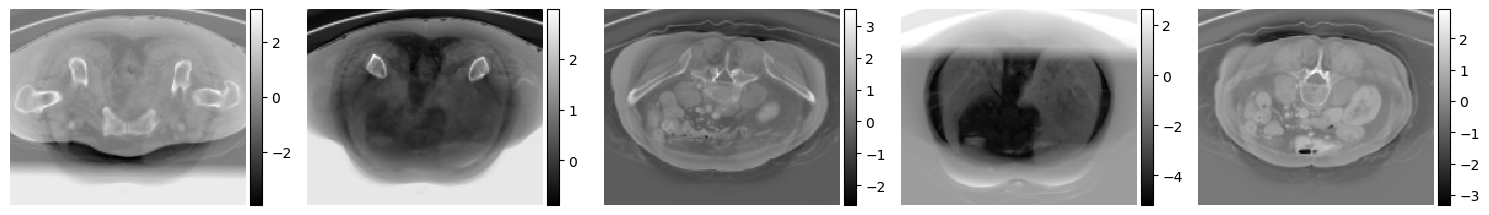

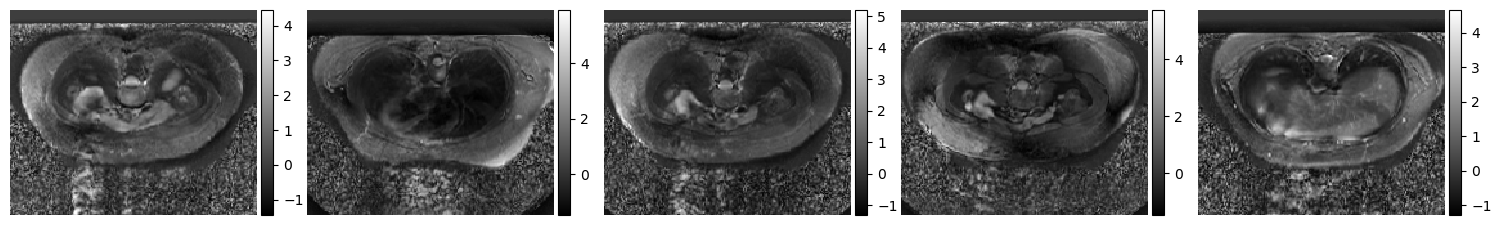

In [39]:
# View images
nb_vis = 5
trnSamp = np.squeeze(CTTrainImg[30,:,:,:])
idx = np.random.randint(0, trnSamp.shape[0], [5,])
example_digits = [f for f in trnSamp[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

nb_vis = 5
trnSamp = np.squeeze(MRTrainImg[30,:,:,:])
idx = np.random.randint(0, trnSamp.shape[0], [5,])
example_digits = [f for f in trnSamp[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# Make a Image 2 Image Translator to apply to the moving CT images using the paired MR-CT images

# Set up simple registration for baseline

In [9]:
# Set up sizes of inputs and architecture

vol_size=(192,160,192)


nf_enc=[32, 32, 32, 32]
nf_dec=[32, 32, 32, 32, 32, 16]
nb_features = [nf_enc, nf_dec]

# Find number of labels
labelList = np.unique(MRTrainSeg)
labelNum = len(labelList)
print(labelNum)

5


In [40]:
# def vxm_data_generator(moved_data, fixed_data, moved_segmentations, fixed_segmentations, batch_size=4):
#     """
#     Generator that takes in data of size [N, H, W, D], and yields data for
#     our custom vxm model in sequential pairs instead of random sampling.

#     inputs:  moving [bs, H, W, D], fixed image [bs, H, W, D]
#     outputs: moved image [bs, H, W, D], zero-gradient [bs, H, W, 3]
#     """

#     # preliminary sizing
#     N = moved_data.shape[0]  # Number of moved images (N)
#     M = fixed_data.shape[0]  # Number of fixed images (M)
#     vol_shape = moved_data.shape[1:]  # extract data shape (H, W, D)
#     ndims = len(vol_shape)

#     # Prepare a zero array the size of the deformation
#     zero_phi = np.zeros([batch_size, *vol_shape, ndims])

#     # Generate all unique image pairs (i, j) 
#     pairs = [(i, j) for i in range(N) for j in range(M)]

#     # Iterate through pairs in batches
#     num_batches = len(pairs) // batch_size
#     pair_idx = 0
    
#     while True:
#         # Select a batch of pairs
#         batch_pairs = pairs[pair_idx:pair_idx + batch_size]

#         # Prepare inputs for the batch
#         moving_images = np.array([moved_data[i, ..., np.newaxis] for i, j in batch_pairs])
#         fixed_images = np.array([fixed_data[j, ..., np.newaxis] for i, j in batch_pairs])
        
#         # Prepare corresponding segmentations for the batch
#         moving_segmentations = np.array([moved_segmentations[i, ..., np.newaxis] for i, j in batch_pairs])
#         fixed_segmentations = np.array([fixed_segmentations[j, ..., np.newaxis] for i, j in batch_pairs])
        
#         inputs = [moving_images, fixed_images]
#         outputs = [fixed_images, zero_phi, moving_segmentations, fixed_segmentations]

#         yield (inputs, outputs)

#         # Update the pair index for the next batch
#         pair_idx = (pair_idx + batch_size) % len(pairs)
#         if pair_idx == 0:
#             # If we have iterated through all pairs, restart the loop
#             pass
        


################################## One Hot Encoding for Masks ###############################################
def one_hot_encode(masks, num_classes=5):
    """
    Convert a set of segmentation masks to one-hot encoded format.
    
    Args:
        masks (np.ndarray): Segmentation mask of shape [N, H, W, D] (integer values)
        num_classes (int): Number of classes to one-hot encode

    Returns:
        np.ndarray: One-hot encoded mask of shape [N, H, W, D, num_classes]
    """
    # Create a one-hot encoded version of the mask
    one_hot_masks = np.eye(num_classes)[masks]  # This will create a one-hot encoding
    return one_hot_masks


################################## Data Generation for Semisupervised ########################################

def vxm_data_generator(moved_data, fixed_data, moved_segmentations, fixed_segmentations, batch_size=4):
    """
    Generator for VxmDenseSemiSupervisedSeg. This generator provides batches of image pairs and 
    corresponding segmentations for training the model.
    
    inputs:  
        moved_data: Moving images of shape [N, H, W, D]  
        fixed_data: Fixed images of shape [N, H, W, D]  
        moved_segmentations: Segmentation masks for the moving images [N, H, W, D, num_classes]
        fixed_segmentations: Segmentation masks for the fixed images [N, H, W, D, num_classes]
        
    outputs:
        [moving_images, fixed_images, moving_segmentations] -> model input
        [transformed_moving_image, flow_field, transformed_moving_segmentation] -> model output
    """
    
    N = moved_data.shape[0]  # Number of moving images
    M = fixed_data.shape[0]  # Number of fixed images
    vol_shape = moved_data.shape[1:]  # Extract the shape of the volume (H, W, D)
    ndims = len(vol_shape)  # Number of spatial dimensions (usually 3)

    # Prepare a zero array the size of the deformation (flow field)
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    # Generate all unique image pairs (i, j) 
    pairs = [(i, j) for i in range(N) for j in range(M)]

    num_batches = len(pairs) // batch_size
    pair_idx = 0
  
    
    while True:
        # Select a batch of pairs
        batch_pairs = pairs[pair_idx:pair_idx + batch_size]
        
        if len(batch_pairs) < batch_size:
            # If the last batch is smaller than the batch size, reset pair_idx to 0
            pair_idx = 0
            batch_pairs = pairs[pair_idx:pair_idx + batch_size]

        # Prepare the moving and fixed images for the batch
        moving_images = np.array([moved_data[i, ..., np.newaxis] for i, j in batch_pairs])
        fixed_images = np.array([fixed_data[j, ..., np.newaxis] for i, j in batch_pairs])
        
        # Prepare the corresponding moving and fixed segmentations for the batch
        moving_segmentations = np.array([moved_segmentations[i, ..., :] for i, j in batch_pairs])  # multi-class mask
        fixing_segmentations = np.array([fixed_segmentations[j, ..., :] for i, j in batch_pairs])  # multi-class mask
        
        # One-hot encode the segmentations
        moving_segmentations = one_hot_encode(moving_segmentations, num_classes=5)
        fixing_segmentations = one_hot_encode(fixing_segmentations, num_classes=5)
        
         # Debugging step: print the shapes to confirm correctness
        # print(f"moving_images shape: {moving_images.shape}")
        # print(f"fixed_images shape: {fixed_images.shape}")
        # print(f"moving_segmentations shape: {moving_segmentations.shape}")
        # print(f"fixed_segmentations shape: {fixing_segmentations.shape}")
        # print(f"zero_phi shape: {zero_phi.shape}")

        
        # Prepare inputs and outputs
        inputs = [moving_images, fixed_images, moving_segmentations]
        outputs = [fixed_images, zero_phi, fixing_segmentations]  # Moving segmentation is not used directly
        
        # Yield the batch
        yield (inputs, outputs)

        
        # Update the pair index for the next batch
        pair_idx = (pair_idx + batch_size) % len(pairs)
        if pair_idx == 0:
            # If we have iterated through all pairs, restart the loop
            pass
        

        
def get_batch_from_generator(generator, batch_number):
    for i, (inputs, outputs) in enumerate(generator):
        if i == batch_number:
            return inputs, outputs
    return None

In [41]:
from sklearn.preprocessing import StandardScaler

ssdScaler = StandardScaler()

def ssdProcess(fullData):
    processed = fullData.reshape(fullData.shape[0], fullData.shape[1], -1)
    its = fullData.shape[0]
    
    for iii in range(its):
        processed[iii,:,:] = ssdScaler.fit_transform(processed[iii,:,:])
        
    processed = processed.reshape(fullData.shape)
    
    return processed

MRTrainProc = ssdProcess(MRTrainImg)
CTTrainProc = ssdProcess(CTTrainImg)
MRPairedTrainProc = ssdProcess(MRPairedTrainImg)
CTPairedTrainProc = ssdProcess(CTPairedTrainImg)


In [42]:
# Losses
# class diceLoss:
#     """
#     N-D Dice loss for multi-class segmentation (4D input, ignoring background class 0).
#     This version works with integer segmentation masks (non one-hot encoded).
#     It ignores the background class (class 0).
#     """

#     def loss(self, y_true, y_pred, num_classes=5):
#         # Ensure y_true and y_pred are TensorFlow tensors and cast to float32
#         y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
#         y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

#         # Get the number of spatial dimensions (excluding batch dimension)
#         ndims = len(y_pred.shape) - 1  # Subtract 1 for batch dimension
#         vol_axes = list(range(1, ndims + 1))  # Spatial dimensions (depth, height, width for 3D)

#         # Initialize variable to accumulate Dice scores
#         total_dice = 0.0
#         valid_classes = 0  # Track how many classes we actually compute Dice for (ignoring class 0)

#         # Loop over each class (assuming values are from 0 to num_classes-1)
#         for c in range(1, num_classes):  # Start from 1 to ignore class 0 (background)
#             # Create binary masks for current class
#             y_true_c = tf.cast(tf.equal(y_true, c), dtype=tf.float32)
#             y_pred_c = tf.cast(tf.equal(y_pred, c), dtype=tf.float32)

#             # Compute the numerator (2 * intersection)
#             top = 2 * tf.reduce_sum(y_true_c * y_pred_c, axis=vol_axes)

#             # Compute the denominator (union)
#             bottom = tf.reduce_sum(y_true_c + y_pred_c, axis=vol_axes)

#             # Compute the Dice coefficient for this class
#             dice_c = tf.reduce_mean(tf.math.divide_no_nan(top, bottom))

#             # Accumulate the Dice score
#             total_dice += dice_c
#             valid_classes += 1  # Increment valid classes count

#         # Return the average Dice score across all classes (ignoring class 0)
#         return -total_dice / valid_classes  # Average over valid classes (ignoring background class)

# class CustomLoss(tf.keras.losses.Loss):
#     def __init__(self, lam=1.0):
#         super().__init__()
#         self.lam = lam  # Regularization weight for image similarity loss

#     def dice_loss(self, y_true, y_pred, num_classes=5):
#         # Compute Dice loss for segmentation (ignoring background)
#         smooth = 1e-6  # Small constant to avoid division by zero
#         intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#         union = tf.reduce_sum(y_true, axis=(1, 2, 3)) + tf.reduce_sum(y_pred, axis=(1, 2, 3))
#         dice = 2.0 * intersection / (union + smooth)
#         return 1 - tf.reduce_mean(dice)  # Return 1 - dice because we want to minimize loss

#     def ssd_loss(self, y_true, y_pred):
#         # Compute sum of squared differences (SSD) for image similarity
#         return tf.reduce_mean(tf.square(y_true - y_pred))  # SSD over the batch

#     def call(self, y_true, y_pred):
#         fixed_images, fixed_segmentations = y_true
#         transformed_images, transformed_segmentations = y_pred

#         # Compute Dice loss (segmentation)
#         dice = self.dice_loss(fixed_segmentations, transformed_segmentations)
#         # Compute SSD loss (image similarity)
#         ssd = self.ssd_loss(fixed_images, transformed_images)
        
#         # Combine losses
#         total_loss = dice + self.lam * ssd
#         return total_loss

In [49]:
tf.keras.backend.clear_session()
model1 = networks.VxmDenseSemiSupervisedSeg(inshape=vol_size, nb_unet_features=nb_features, nb_labels=5, int_resolution=1, seg_resolution=1)

transform_img = vxm.networks.Transform(inshape=vol_size, interp_method='linear')
transform_seg = vxm.networks.Transform(inshape=vol_size, interp_method='nearest')

# model1.compile(optimizer='Adam', loss=vxm.losses.Dice().loss)
# model1.summary()

print('input shape: ', ', '.join([str(t.shape) for t in model1.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in model1.outputs]))

input shape:  (None, 192, 160, 192, 1), (None, 192, 160, 192, 1), (None, 192, 160, 192, 5)
output shape: (None, 192, 160, 192, 1), (None, 192, 160, 192, 3), (None, 192, 160, 192, 5)


In [50]:
# pairs = [(i, j) for i in range(10) for j in range(20)]
# # print(pairs[0:3])
# pair_idx = 0
# bse = 2
# batch_pairs = pairs[pair_idx:pair_idx + bse]
# print(batch_pairs)

In [51]:
losses = [vxm.losses.MutualInformation().loss, vxm.losses.Grad('l2').loss, vxm.losses.Dice().loss]
# , vxm.losses.Dice().loss
# vxm.losses.Grad('l2').loss
# vxm.losses.MutualInformation().loss
l1 = 0.2
l2 = 0
l3 = 1
loss_weights = [l1, l2, l3]

batch_size = 1
train_generator = vxm_data_generator(CTPairedTrainProc, MRPairedTrainProc, CTPairedTrainSeg, MRPairedTrainSeg, batch_size=batch_size)
# val_generator = vxm_data_generator(CTPairedTrainProc, MRPairedTrainProc, CTPairedTrainSeg, MRPairedTrainSeg, batch_size = batch_size)


tf.Tensor(449.99994, shape=(), dtype=float32)


In [52]:
model1.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [53]:
from tensorflow.keras import callbacks
# callback1 = callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

In [ ]:
nb_epochs = 15
steps_per_epoch = 150

hist = model1.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                  verbose=2)

# hist = model1.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, 
#                   validation_data = val_generator,
#                   callbacks = callback1,
#                   verbose=2)

Epoch 1/15


In [14]:

# Define the batch size
batch_size = 1  # Adjust as needed

train_generator = vxm_data_generator(MRTrainProc, MRTrainProc, MRTrainSeg, MRTrainSeg, batch_size=batch_size)

# Define the number of epochs
epochs = 100

# Set up an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Define your loss functions (e.g., Dice loss for segmentation)
seg_loss_fn = diceLoss().loss
img_loss_fn = vxm.losses.MSE().loss
lam = 0.3

for epoch in range(epochs):
    for batch in train_generator:
        moving_images, fixed_images = batch[0]  # moving and fixed images
        __, __, moving_segmentations, fixed_segmentations = batch[1]  # moving and fixed segmentations
        
        # Use GradientTape to compute gradients
        with tf.GradientTape() as tape:
            tape.watch(model1.trainable_variables)  # Watch the model's trainable variables
            
            # Forward pass through the model
            pred_flow = model1([moving_images, fixed_images])  # Moving image and fixed image

            pred_warp = pred_flow[1]

            # Apply the transformation
            transformed_moving_batch = transform_img([moving_images, pred_warp])
            transformed_seg_batch = transform_seg([moving_segmentations, pred_warp])

            transformed_seg_batch = np.squeeze(transformed_seg_batch)
            fixed_segmentations = np.squeeze(fixed_segmentations)
            transformed_moving_batch = np.squeeze(transformed_moving_batch)
            fixed_images = np.squeeze(fixed_images)


            # Compute Dice loss (for segmentation)
            seg_loss = seg_loss_fn(transformed_seg_batch, fixed_segmentations)  # Dice loss for segmentations
            
            print(seg_loss)

            # Example of an image loss (you may have other losses)
            image_loss = img_loss_fn(transformed_moving_batch, fixed_images)  # Example image similarity loss (SSD)
            
            print(image_loss)

            # Total loss: combine the losses
            total_loss = lam*seg_loss + image_loss

        # Compute gradients and update the model
        gradients = tape.gradient(total_loss, model1.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model1.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.numpy()}")

2024-11-26 15:58:28.879012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800


tf.Tensor(-0.37109375, shape=(), dtype=float32)
tf.Tensor(5.704383e-08, shape=(), dtype=float32)


ValueError: No gradients provided for any variable: (['vxm_dense_unet_enc_conv_0_0/kernel:0', 'vxm_dense_unet_enc_conv_0_0/bias:0', 'vxm_dense_unet_enc_conv_1_0/kernel:0', 'vxm_dense_unet_enc_conv_1_0/bias:0', 'vxm_dense_unet_enc_conv_2_0/kernel:0', 'vxm_dense_unet_enc_conv_2_0/bias:0', 'vxm_dense_unet_enc_conv_3_0/kernel:0', 'vxm_dense_unet_enc_conv_3_0/bias:0', 'vxm_dense_unet_dec_conv_3_0/kernel:0', 'vxm_dense_unet_dec_conv_3_0/bias:0', 'vxm_dense_unet_dec_conv_2_0/kernel:0', 'vxm_dense_unet_dec_conv_2_0/bias:0', 'vxm_dense_unet_dec_conv_1_0/kernel:0', 'vxm_dense_unet_dec_conv_1_0/bias:0', 'vxm_dense_unet_dec_conv_0_0/kernel:0', 'vxm_dense_unet_dec_conv_0_0/bias:0', 'vxm_dense_unet_dec_final_conv_0/kernel:0', 'vxm_dense_unet_dec_final_conv_0/bias:0', 'vxm_dense_unet_dec_final_conv_1/kernel:0', 'vxm_dense_unet_dec_final_conv_1/bias:0', 'vxm_dense_flow/kernel:0', 'vxm_dense_flow/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'vxm_dense_unet_enc_conv_0_0/kernel:0' shape=(3, 3, 3, 2, 32) dtype=float32, numpy=
array([[[[[-0.087349  , -0.29961443, -0.30253303, ...,  0.30587792,
           -0.33864698,  0.07602034],
          [ 0.18771097, -0.23912151, -0.01298543, ..., -0.1407441 ,
            0.22535124, -0.02614721]],

         [[ 0.10467687, -0.00235363,  0.3607001 , ..., -0.20571704,
           -0.37507242,  0.17057535],
          [-0.03162318,  0.05376795, -0.31116274, ...,  0.15377538,
            0.01360872, -0.05023648]],

         [[ 0.12122153,  0.02686748,  0.16321461, ...,  0.25650325,
            0.31618062,  0.1064278 ],
          [ 0.16735308,  0.115654  ,  0.23611456, ..., -0.11029769,
           -0.25199616, -0.07354181]]],


        [[[-0.18904227,  0.12521368,  0.385156  , ..., -0.17876948,
           -0.20455244, -0.18986881],
          [-0.07348949,  0.02953928, -0.1564939 , ..., -0.2431318 ,
           -0.11651943,  0.0945268 ]],

         [[-0.0025913 , -0.1901486 ,  0.07849557, ..., -0.2096443 ,
            0.01168824, -0.21414551],
          [-0.13433428,  0.13536267, -0.02677041, ...,  0.3614105 ,
            0.05478036, -0.21785556]],

         [[-0.12841573, -0.01485147,  0.08767407, ...,  0.3036319 ,
           -0.33880156, -0.20105995],
          [ 0.04922751,  0.25519565, -0.02548742, ..., -0.14994404,
           -0.16350795,  0.11919937]]],


        [[[ 0.02359935,  0.16054378,  0.06497049, ...,  0.19743808,
           -0.3561925 , -0.17593351],
          [-0.04452699, -0.0457462 ,  0.10228872, ..., -0.2014427 ,
            0.07209147,  0.13426055]],

         [[-0.10582953,  0.3649015 , -0.26049507, ...,  0.08658716,
            0.25550532, -0.29961714],
          [-0.13809977, -0.1057296 , -0.22379704, ..., -0.15584335,
           -0.11999016, -0.03019048]],

         [[-0.08158278,  0.01084885,  0.29178175, ..., -0.03793316,
            0.06387604,  0.2514502 ],
          [ 0.09814988,  0.03531393, -0.22999339, ..., -0.10975468,
            0.28676006,  0.2216925 ]]]],



       [[[[ 0.3118364 ,  0.34928915,  0.13322349, ...,  0.22402494,
            0.09377132, -0.17051384],
          [-0.03149313,  0.08772129, -0.06110646, ...,  0.04168848,
            0.27286676, -0.32501313]],

         [[ 0.06288489, -0.27869323,  0.02348856, ...,  0.27899826,
           -0.09841707, -0.132861  ],
          [-0.17649888, -0.3999861 ,  0.1913581 , ..., -0.43138516,
            0.02764565,  0.38362157]],

         [[ 0.16777211, -0.36948532, -0.03377616, ...,  0.2121475 ,
            0.13051857, -0.17810754],
          [-0.3062328 , -0.11041809,  0.0228401 , ...,  0.22004029,
            0.07576113, -0.22657408]]],


        [[[-0.0122425 ,  0.06774282, -0.01833476, ..., -0.17402492,
            0.15151535,  0.02659726],
          [ 0.13916022,  0.04140897,  0.2772819 , ...,  0.09970924,
           -0.20420274,  0.23764066]],

         [[ 0.16447745,  0.17737292,  0.32692167, ...,  0.30911744,
            0.01835309, -0.30540767],
          [ 0.33651006,  0.02069876,  0.29295737, ...,  0.12738447,
           -0.04546138, -0.30346957]],

         [[ 0.10738311,  0.12277098,  0.23860559, ..., -0.2583495 ,
            0.33827984,  0.04362586],
          [-0.26233816,  0.09016912,  0.28554994, ...,  0.13027123,
           -0.31452695,  0.00219077]]],


        [[[ 0.05728623, -0.0534642 , -0.43426836, ...,  0.08162377,
           -0.02367594,  0.06059417],
          [-0.0722486 , -0.23427626, -0.13718954, ...,  0.1553764 ,
            0.27804145,  0.17210262]],

         [[ 0.22740903,  0.056923  ,  0.18054856, ..., -0.03877619,
            0.22022696, -0.1645021 ],
          [-0.07717085, -0.12519291,  0.07736236, ..., -0.42438087,
            0.26410928, -0.35100716]],

         [[ 0.20700374, -0.29217738, -0.21329609, ...,  0.06498917,
           -0.12330315, -0.09782293],
          [-0.30720294, -0.32318997,  0.22816694, ...,  0.31942433,
            0.0079187 ,  0.047272  ]]]],



       [[[[-0.09378001,  0.05874811,  0.35872534, ...,  0.05616544,
           -0.2520399 , -0.07002842],
          [ 0.15826753,  0.04457815, -0.07284816, ...,  0.00669755,
           -0.12283875, -0.2287955 ]],

         [[-0.3783812 ,  0.04870318, -0.303572  , ..., -0.0808396 ,
           -0.17472515, -0.11429882],
          [ 0.01887035,  0.19398887, -0.08228353, ..., -0.31935853,
           -0.2589942 , -0.20071587]],

         [[-0.24604595,  0.10312991,  0.31301442, ...,  0.14443885,
            0.06116082, -0.41401118],
          [-0.04838497, -0.03586192, -0.3473501 , ..., -0.11305204,
            0.02851502, -0.17019409]]],


        [[[-0.0313598 , -0.1501058 ,  0.3156653 , ..., -0.4061823 ,
           -0.0723838 , -0.13775915],
          [ 0.25463203,  0.00606156,  0.28417823, ..., -0.10846147,
           -0.0986714 , -0.24414715]],

         [[-0.35241246, -0.35754785, -0.18333884, ...,  0.03256382,
           -0.23820488,  0.01441456],
          [-0.05965654, -0.04652905, -0.1453565 , ...,  0.2523286 ,
            0.28319058,  0.2723745 ]],

         [[-0.01173947, -0.02558894,  0.08172402, ...,  0.01599217,
            0.18454699,  0.14907077],
          [-0.31875515,  0.27228326, -0.03073281, ..., -0.0221147 ,
            0.3366866 ,  0.19845556]]],


        [[[ 0.04523864, -0.16395572,  0.23853984, ...,  0.04354681,
            0.07644626,  0.0593682 ],
          [-0.11322181,  0.03010628,  0.13408202, ...,  0.13872194,
           -0.28394136, -0.0499549 ]],

         [[-0.0036196 ,  0.09350499, -0.39736968, ...,  0.19155051,
           -0.02848072,  0.19024637],
          [ 0.2709696 , -0.04591663,  0.4265874 , ..., -0.12524474,
            0.23893596, -0.1645559 ]],

         [[-0.264094  ,  0.16432282, -0.0011997 , ...,  0.2878161 ,
            0.12292748,  0.14130226],
          [-0.07916926,  0.03575976, -0.16104944, ..., -0.12655406,
            0.21424371, -0.0656278 ]]]]], dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_0_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_1_0/kernel:0' shape=(3, 3, 3, 32, 32) dtype=float32, numpy=
array([[[[[-0.05856902,  0.01311833, -0.01026502, ..., -0.00486637,
            0.05438804, -0.0232366 ],
          [ 0.02946489, -0.04559683,  0.00319016, ...,  0.01498466,
           -0.01721895, -0.01498762],
          [ 0.04411104, -0.05723204, -0.04238019, ...,  0.0805283 ,
           -0.04646749,  0.01394771],
          ...,
          [-0.00394273,  0.01817622,  0.0909033 , ...,  0.04963641,
           -0.02626213,  0.0040774 ],
          [ 0.02485399, -0.0437934 ,  0.09990748, ..., -0.01828761,
           -0.03246623, -0.02973748],
          [-0.04268779, -0.04969842, -0.0143068 , ..., -0.02759364,
           -0.00114517,  0.07361598]],

         [[-0.05724681, -0.03428082, -0.05411324, ..., -0.02146236,
            0.04224354,  0.0666424 ],
          [ 0.00888748,  0.00517669, -0.06860191, ..., -0.078126  ,
           -0.06490085,  0.03142311],
          [ 0.0564217 , -0.04089241, -0.04608457, ...,  0.1015958 ,
           -0.00095595,  0.04791356],
          ...,
          [ 0.06526607, -0.00885662,  0.07808741, ...,  0.10007197,
            0.06760575,  0.01335731],
          [-0.03858217, -0.00755272,  0.01365431, ...,  0.08222982,
           -0.0342129 , -0.00049164],
          [ 0.01706221,  0.04704339,  0.05985908, ...,  0.053706  ,
           -0.00473043,  0.0743688 ]],

         [[-0.01133597, -0.07931785, -0.04771667, ...,  0.00188406,
            0.03212355, -0.01869205],
          [-0.03209564,  0.00442944,  0.07890795, ...,  0.0409028 ,
           -0.04612208, -0.09236445],
          [-0.04635187, -0.05289977,  0.02232236, ..., -0.00256661,
           -0.09571195, -0.00795445],
          ...,
          [-0.04549662,  0.01445588,  0.06260386, ..., -0.01312669,
           -0.08840913,  0.00059623],
          [ 0.00287612, -0.02927838, -0.06491952, ...,  0.00438754,
            0.08246896,  0.0094822 ],
          [ 0.04714751,  0.02761599, -0.09205203, ..., -0.06163305,
           -0.01431013, -0.01430557]]],


        [[[ 0.04775761, -0.06312188, -0.01141469, ..., -0.02243765,
            0.01222315,  0.01539107],
          [-0.02429579,  0.05165092, -0.0606684 , ..., -0.02260184,
           -0.03035858, -0.02140264],
          [-0.02101161, -0.01730455, -0.0274696 , ...,  0.04716352,
           -0.00971649,  0.02170781],
          ...,
          [ 0.04425972, -0.02972037,  0.06713871, ...,  0.02050415,
           -0.05377824,  0.02595804],
          [-0.09872577,  0.0727744 , -0.01966032, ...,  0.09839483,
           -0.01110681,  0.02795178],
          [-0.08888841,  0.00422781, -0.00780829, ...,  0.08356908,
           -0.02665932,  0.01887011]],

         [[ 0.05416199,  0.00578003,  0.06628513, ...,  0.09356692,
           -0.09483499, -0.01177293],
          [ 0.09015657, -0.0626008 , -0.05111019, ...,  0.03658738,
            0.01008212, -0.08112146],
          [ 0.0868789 ,  0.03064009, -0.00142263, ..., -0.01667057,
           -0.0382809 , -0.03041604],
          ...,
          [ 0.020648  , -0.01113411,  0.0319842 , ..., -0.02929982,
            0.00177666,  0.07926457],
          [-0.06630781,  0.03519354,  0.01244576, ..., -0.01252502,
            0.01794142, -0.03260503],
          [ 0.07418539, -0.08989743,  0.0082731 , ...,  0.03642088,
            0.09305871,  0.08552223]],

         [[-0.00237739, -0.09023502,  0.05087559, ..., -0.0287015 ,
           -0.03213253, -0.0587195 ],
          [ 0.02506008, -0.05537768, -0.04545503, ...,  0.05111821,
           -0.05442789, -0.03860603],
          [-0.05761041, -0.05840144, -0.00071343, ..., -0.02116663,
           -0.02785404,  0.06713539],
          ...,
          [-0.0135977 ,  0.053089  , -0.02181194, ..., -0.02058821,
           -0.01703607, -0.00321907],
          [ 0.01515936,  0.06821891, -0.00011872, ..., -0.09300098,
            0.0841573 ,  0.07039189],
          [-0.00190327, -0.03638233,  0.08153176, ..., -0.05063029,
           -0.00815368, -0.02783098]]],


        [[[-0.0204323 , -0.02483304,  0.05805781, ...,  0.09360808,
           -0.01923195, -0.01429925],
          [-0.05750984, -0.02244875,  0.06989796, ...,  0.00827427,
            0.04321535,  0.02501251],
          [ 0.08866417, -0.06347448, -0.0580651 , ...,  0.02256764,
            0.09016737, -0.01996914],
          ...,
          [ 0.00289587,  0.0096128 ,  0.00397943, ..., -0.0391997 ,
            0.02002218, -0.02296256],
          [-0.094159  ,  0.00860407, -0.00098714, ..., -0.01665577,
           -0.03128268,  0.08561356],
          [-0.04824954, -0.07568094, -0.04862595, ..., -0.05137045,
           -0.02911102,  0.07596581]],

         [[ 0.00528377, -0.01434949,  0.05363216, ..., -0.09643916,
           -0.03586799,  0.02999233],
          [-0.02625526,  0.04280359, -0.04604609, ..., -0.02960286,
            0.0036672 ,  0.02990375],
          [ 0.04990178, -0.07556251,  0.05480938, ..., -0.07381328,
            0.01588829, -0.0149437 ],
          ...,
          [-0.01812696,  0.03619863,  0.0373568 , ...,  0.02470161,
           -0.0547865 ,  0.04235295],
          [-0.02076426, -0.00853182,  0.01536164, ..., -0.06125192,
           -0.02755133, -0.01633346],
          [-0.02254477, -0.10260802, -0.00442118, ...,  0.03685225,
            0.00560265,  0.08232952]],

         [[-0.00555554, -0.0526073 , -0.0953086 , ...,  0.0157832 ,
           -0.01951819,  0.09639878],
          [-0.01025554, -0.01451931, -0.07448126, ..., -0.05017372,
            0.04469565, -0.10656238],
          [ 0.08734949, -0.00687162,  0.0035282 , ..., -0.0623439 ,
            0.04692632, -0.02301385],
          ...,
          [-0.02787198, -0.03526874,  0.00335595, ...,  0.01804609,
           -0.00350786, -0.02140491],
          [ 0.06720715, -0.03502407, -0.02051417, ...,  0.03745414,
            0.07411469,  0.0108193 ],
          [-0.02254504,  0.03054335, -0.08894584, ...,  0.03224866,
           -0.0497576 ,  0.04838869]]]],



       [[[[-0.01199166, -0.0265614 ,  0.03071548, ..., -0.01308145,
           -0.03654959, -0.0835802 ],
          [-0.10341176,  0.04100399, -0.00859159, ..., -0.02722224,
            0.05259465, -0.00866626],
          [-0.01766501,  0.03307734,  0.00356518, ...,  0.02232239,
           -0.04838229,  0.04201547],
          ...,
          [ 0.01175783, -0.09375964, -0.00089241, ..., -0.02987139,
            0.02786611,  0.01339488],
          [-0.02242003, -0.04911862,  0.03684139, ..., -0.01923814,
            0.00532084,  0.08802272],
          [ 0.08642287,  0.07005807, -0.0322191 , ..., -0.00327239,
           -0.1015273 , -0.0087878 ]],

         [[ 0.00910949,  0.04550041, -0.02397868, ...,  0.03055717,
            0.04007958, -0.01007455],
          [ 0.03321404, -0.05528321,  0.05609559, ..., -0.00493625,
           -0.05761614, -0.08891032],
          [-0.00980293, -0.04591724,  0.03019008, ...,  0.04273995,
            0.01132039,  0.02857177],
          ...,
          [-0.05448156, -0.04745788, -0.00482796, ...,  0.00984755,
           -0.03375055,  0.05678397],
          [ 0.10286272,  0.06238893, -0.0541683 , ...,  0.01518693,
           -0.00799114,  0.04489221],
          [-0.0649202 ,  0.0358856 , -0.01647287, ..., -0.05128764,
           -0.08117266, -0.09423387]],

         [[ 0.0104842 ,  0.05145169, -0.05104487, ...,  0.0195976 ,
            0.00451095,  0.00926513],
          [ 0.02770515, -0.01537686,  0.03057962, ...,  0.0348518 ,
           -0.03272075, -0.0017058 ],
          [ 0.05486071, -0.10371019,  0.01550148, ...,  0.01486228,
            0.0414083 , -0.01238137],
          ...,
          [-0.02122656, -0.07527444,  0.07741424, ...,  0.03990338,
           -0.05803718, -0.00627835],
          [ 0.04700419,  0.03575305,  0.01954092, ...,  0.07971936,
            0.05804339,  0.00509875],
          [-0.04468703, -0.09807725,  0.00509605, ..., -0.07024996,
            0.07620567,  0.07307193]]],


        [[[-0.05698172, -0.04343888,  0.02386746, ...,  0.04589498,
            0.03786599,  0.04116533],
          [-0.00897104, -0.10149086, -0.05063926, ...,  0.05990062,
           -0.01840943, -0.09801453],
          [ 0.02415033,  0.02397191, -0.07728843, ..., -0.02500021,
            0.08848903, -0.07120765],
          ...,
          [ 0.00621525,  0.03281729, -0.07108216, ...,  0.01320606,
           -0.01345902, -0.00199049],
          [-0.03288355, -0.05164542, -0.02190086, ..., -0.10272991,
            0.06550336,  0.01905367],
          [-0.04896427, -0.08576949,  0.05593997, ...,  0.08690827,
           -0.0380211 ,  0.00324435]],

         [[-0.07303651, -0.07435369, -0.0692926 , ...,  0.03068616,
           -0.09316625, -0.03706352],
          [-0.05622199, -0.00817846, -0.03138843, ...,  0.02568837,
            0.02850495,  0.06000843],
          [ 0.05238844, -0.08208632, -0.00547645, ...,  0.0061162 ,
           -0.0551352 , -0.07295296],
          ...,
          [-0.07093884,  0.05854305, -0.01125296, ..., -0.04203441,
            0.00581094,  0.05773357],
          [ 0.0174254 , -0.00391531,  0.04139577, ..., -0.0067688 ,
            0.04442787,  0.00377515],
          [-0.09404216, -0.05790597, -0.06055755, ...,  0.011336  ,
            0.03177296,  0.03784616]],

         [[ 0.00751731, -0.03793624,  0.10715794, ...,  0.04366821,
           -0.03090251, -0.01111637],
          [-0.01501277,  0.07140025, -0.01602482, ..., -0.02302631,
           -0.01238784, -0.04351581],
          [ 0.02630331, -0.06853375, -0.06012592, ...,  0.01105479,
           -0.01226764, -0.00819147],
          ...,
          [-0.02464997,  0.04029895,  0.08363604, ...,  0.03973326,
            0.05348663,  0.05268786],
          [-0.06020639,  0.03370213,  0.02752125, ...,  0.03992828,
            0.0719009 , -0.00314265],
          [ 0.08582152, -0.05618325, -0.04424148, ..., -0.00976015,
            0.02648195, -0.01624301]]],


        [[[ 0.04904844, -0.00134039, -0.00601069, ..., -0.02814216,
           -0.04911834, -0.05624215],
          [-0.0837808 ,  0.0523948 , -0.03468845, ...,  0.05557444,
           -0.00385528, -0.00943165],
          [ 0.04477089, -0.05715514,  0.06350338, ..., -0.0123159 ,
           -0.01437283, -0.04417102],
          ...,
          [-0.01259936,  0.04686324, -0.02744469, ..., -0.02359106,
            0.07094726,  0.02124407],
          [ 0.07134756,  0.03812268, -0.05606804, ...,  0.05297743,
           -0.01703805,  0.06692611],
          [-0.0216459 ,  0.0733836 , -0.01165907, ..., -0.04546496,
            0.07664666, -0.05432131]],

         [[-0.00709571,  0.10899667,  0.05661036, ...,  0.10221668,
           -0.06942199,  0.01407376],
          [ 0.08254393,  0.07759656,  0.04784603, ...,  0.02193518,
            0.05391558,  0.02846957],
          [ 0.10318282,  0.0677335 , -0.10155284, ..., -0.06674249,
            0.03088417,  0.00185147],
          ...,
          [ 0.00702617, -0.00478976,  0.07746526, ...,  0.01351907,
            0.04798788, -0.02789628],
          [-0.05650539,  0.06004358, -0.02911377, ...,  0.01468937,
           -0.06812081,  0.01210564],
          [ 0.09231492,  0.00275861,  0.01326971, ...,  0.0392254 ,
           -0.03483888,  0.06198426]],

         [[ 0.02312844,  0.04835885, -0.02501861, ...,  0.06852542,
           -0.00842529,  0.03654338],
          [-0.03011608, -0.07346378,  0.02695844, ...,  0.10271683,
           -0.07875832, -0.00287283],
          [-0.06195956,  0.02303398, -0.0200555 , ...,  0.04570656,
           -0.03660603, -0.00232342],
          ...,
          [ 0.00350053, -0.04290538,  0.01405723, ...,  0.01972092,
           -0.03607849,  0.06224734],
          [-0.03848048,  0.02063562, -0.07000396, ..., -0.03421629,
           -0.0378883 ,  0.03265159],
          [-0.04311588, -0.04259336, -0.05499746, ..., -0.05910217,
            0.02068947, -0.05773377]]]],



       [[[[-0.03105963, -0.02987297,  0.04792937, ...,  0.04026807,
            0.07136349, -0.04281659],
          [ 0.0053673 ,  0.01934172,  0.03038397, ...,  0.06044056,
           -0.01325645,  0.0418264 ],
          [-0.06116215, -0.02717504,  0.05980806, ...,  0.03464319,
            0.00708288,  0.00682175],
          ...,
          [ 0.00214064,  0.03719838,  0.05964809, ..., -0.09280722,
            0.00442438,  0.0206358 ],
          [-0.10448708,  0.02999094,  0.06037799, ..., -0.02696527,
            0.00664074, -0.05020856],
          [-0.09897686,  0.05602688,  0.01442168, ...,  0.03414167,
           -0.02952295, -0.03454599]],

         [[ 0.0365441 ,  0.02208846, -0.10145605, ..., -0.08430314,
            0.01038503,  0.03048806],
          [ 0.05978028,  0.01771757, -0.01499335, ..., -0.02931783,
           -0.10602254,  0.00263526],
          [ 0.07314448,  0.05860452,  0.06025128, ..., -0.07256535,
            0.09905205,  0.09262605],
          ...,
          [ 0.00180713, -0.05217687,  0.02991147, ..., -0.03899632,
           -0.04057564,  0.0420822 ],
          [ 0.0274534 ,  0.00798308,  0.05859344, ..., -0.01684641,
            0.03967518,  0.01914599],
          [-0.03690917, -0.02204366, -0.00076767, ..., -0.00840858,
           -0.07429312, -0.06765004]],

         [[ 0.0329929 ,  0.02974894, -0.00371581, ..., -0.03633008,
            0.05301734, -0.10896403],
          [ 0.08086919, -0.03048727,  0.02116897, ..., -0.03289112,
            0.02732078,  0.05427384],
          [-0.01729879,  0.05386474,  0.06389204, ..., -0.01605691,
           -0.02974804, -0.00481044],
          ...,
          [ 0.00184933, -0.00499099,  0.02755013, ..., -0.09307937,
            0.07322167, -0.09201165],
          [ 0.00192614, -0.01339988,  0.00869476, ..., -0.00177707,
           -0.03505594,  0.00017254],
          [ 0.03520763, -0.01970646, -0.03963212, ...,  0.01508399,
            0.04702963,  0.03508441]]],


        [[[-0.02780732,  0.06685987,  0.05910821, ...,  0.04883098,
           -0.01051285, -0.01049873],
          [-0.01897614, -0.02496506, -0.10249879, ..., -0.02620671,
            0.0510161 , -0.00062969],
          [-0.05981594, -0.05028326,  0.02466582, ..., -0.02244172,
            0.07293705, -0.02384775],
          ...,
          [ 0.03296614, -0.04897399, -0.01188822, ..., -0.04878004,
           -0.02220032, -0.02709563],
          [-0.00371198, -0.07562999,  0.02473786, ..., -0.00923384,
            0.00677651,  0.08169658],
          [-0.03329441, -0.07821312,  0.10597047, ...,  0.0238727 ,
            0.00598229, -0.07573836]],

         [[-0.01426312, -0.02558941, -0.0200038 , ..., -0.01470391,
           -0.05429895,  0.04872007],
          [ 0.05715027, -0.04459362, -0.01184021, ..., -0.02401899,
            0.06617378,  0.01558482],
          [-0.01099338, -0.03086539, -0.05695891, ...,  0.03999327,
           -0.01829299, -0.02286578],
          ...,
          [-0.05376775,  0.04258801,  0.10137467, ..., -0.00937851,
            0.01825391, -0.07569066],
          [ 0.0942975 , -0.00239417, -0.06272209, ...,  0.00884268,
           -0.03234438,  0.08840552],
          [ 0.00460569,  0.00631592, -0.00244203, ...,  0.04013207,
            0.00793406,  0.03755528]],

         [[ 0.1023083 , -0.02534912,  0.01039774, ...,  0.05141788,
            0.02316866, -0.01638452],
          [-0.01376032, -0.00692698,  0.00551754, ...,  0.00412422,
            0.02289497,  0.03282823],
          [-0.03183616, -0.08720417,  0.00017591, ..., -0.06413671,
            0.04805123,  0.06904094],
          ...,
          [-0.04448628,  0.02324309,  0.06940588, ..., -0.06900284,
           -0.05378136,  0.00940752],
          [-0.05299961,  0.07781076, -0.06148723, ...,  0.07644395,
            0.00194522,  0.02295285],
          [ 0.00932447,  0.02794464, -0.03848196, ..., -0.01832918,
            0.06657895, -0.05850243]]],


        [[[ 0.01384893, -0.04460429, -0.02868535, ...,  0.0912929 ,
           -0.00222726, -0.03474227],
          [ 0.07568397, -0.0032825 , -0.03683785, ..., -0.00323914,
           -0.01072741,  0.01368691],
          [-0.05851187,  0.00271498,  0.08630126, ...,  0.07635015,
            0.06153905,  0.03287216],
          ...,
          [-0.026427  ,  0.10200611, -0.00837278, ...,  0.07882538,
            0.02313455, -0.05616432],
          [ 0.06645783, -0.01709486,  0.03877914, ...,  0.05870541,
            0.00324389, -0.06249629],
          [-0.02731872,  0.01426124,  0.02469621, ..., -0.01369459,
           -0.03218304, -0.04682295]],

         [[-0.01345725, -0.00644158, -0.01237298, ...,  0.02703924,
            0.03551056,  0.02574901],
          [-0.04495565,  0.05453348, -0.01947644, ..., -0.08533661,
           -0.05835143,  0.04168545],
          [-0.03809774, -0.04850431, -0.0188091 , ...,  0.01423767,
           -0.03215935, -0.02877782],
          ...,
          [-0.0351354 , -0.03944233, -0.04051576, ...,  0.04629527,
           -0.0076002 ,  0.09554461],
          [-0.07005721, -0.07700338,  0.00784014, ..., -0.03888072,
            0.03426015,  0.0267768 ],
          [-0.0218867 , -0.04977528,  0.02917935, ..., -0.01787609,
            0.04297969, -0.06044873]],

         [[ 0.00378975, -0.07219373,  0.02628121, ..., -0.01776288,
            0.0334956 ,  0.00223293],
          [-0.10527817, -0.04136673,  0.00021984, ...,  0.03258855,
            0.01574211,  0.02702801],
          [ 0.02647669,  0.04464923,  0.05062398, ...,  0.07031704,
           -0.03731683, -0.0298849 ],
          ...,
          [-0.01255349,  0.04726085,  0.06234472, ...,  0.01770035,
           -0.02259341,  0.00107853],
          [ 0.07698519,  0.0486144 ,  0.00144029, ...,  0.03725027,
           -0.06389775,  0.09405537],
          [ 0.02176493,  0.00961852,  0.03426788, ...,  0.061877  ,
           -0.0172764 , -0.06677938]]]]], dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_1_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_2_0/kernel:0' shape=(3, 3, 3, 32, 32) dtype=float32, numpy=
array([[[[[ 0.0033968 ,  0.03826163, -0.06186325, ..., -0.00140062,
            0.04519736, -0.01377082],
          [-0.02043417, -0.0156781 ,  0.09838147, ..., -0.05729416,
           -0.0192714 , -0.1087206 ],
          [ 0.08876744,  0.08460913,  0.00803975, ...,  0.00164342,
            0.04945283,  0.05726122],
          ...,
          [ 0.00640084,  0.00088506,  0.08265766, ...,  0.06608737,
           -0.04332475, -0.00312362],
          [-0.06030871,  0.05088773,  0.10348663, ...,  0.08172204,
            0.05385638,  0.04574882],
          [ 0.08034848,  0.00649323,  0.02736993, ...,  0.02817207,
           -0.04115497,  0.01381685]],

         [[-0.08664982,  0.01195955, -0.02586671, ..., -0.01052041,
            0.04777792,  0.09076846],
          [-0.04266215,  0.04757799,  0.08744009, ...,  0.06031625,
            0.03860238,  0.01770316],
          [-0.01803252,  0.01827817, -0.07083049, ..., -0.03548459,
           -0.03295317,  0.00693948],
          ...,
          [-0.07487614, -0.00932593, -0.0302581 , ..., -0.0391709 ,
           -0.03161084,  0.02686347],
          [-0.02942446, -0.03821735,  0.03215552, ...,  0.03152354,
           -0.008087  , -0.06781118],
          [-0.08095159,  0.05106137,  0.0047511 , ...,  0.05377239,
            0.01676217,  0.04336595]],

         [[-0.0247581 , -0.0090159 , -0.02833693, ..., -0.05331897,
           -0.09360633, -0.0593472 ],
          [-0.02464638,  0.05744677, -0.06883428, ...,  0.01123879,
           -0.01637645, -0.04061149],
          [-0.0837792 ,  0.04792438,  0.0486073 , ...,  0.03139195,
           -0.10074228,  0.03183979],
          ...,
          [-0.05593548, -0.03441454, -0.06413849, ..., -0.01458904,
            0.07258472,  0.01086429],
          [ 0.0022431 ,  0.01277322, -0.02460519, ...,  0.05755794,
           -0.04304624,  0.05717254],
          [ 0.04053566,  0.05942104, -0.03383611, ...,  0.04943699,
            0.09735155,  0.01589262]]],


        [[[ 0.07021593, -0.01484092, -0.02275418, ...,  0.00908293,
           -0.01221109, -0.07500428],
          [ 0.05031196, -0.01704727,  0.04115881, ..., -0.08129879,
            0.03557807,  0.02405877],
          [ 0.00852869, -0.0297893 , -0.01006725, ..., -0.08544616,
           -0.01694794, -0.09914668],
          ...,
          [ 0.08301652,  0.07796203, -0.09685024, ..., -0.03980397,
           -0.06204571,  0.04496619],
          [-0.00384353, -0.05392013,  0.09250961, ...,  0.04169215,
            0.03200333,  0.01722807],
          [ 0.03802153,  0.02616447, -0.03445041, ..., -0.01743069,
            0.02822334, -0.03555835]],

         [[ 0.00829068,  0.0229518 ,  0.01101981, ..., -0.07206307,
            0.01900136,  0.00233501],
          [ 0.04516466, -0.00765639,  0.02438505, ..., -0.03162834,
           -0.06679676, -0.01249304],
          [ 0.01701212,  0.05767372, -0.03897258, ..., -0.02312606,
            0.06903753,  0.05898791],
          ...,
          [-0.01323807, -0.03156494, -0.01606145, ...,  0.04134691,
           -0.10424045, -0.00832229],
          [-0.04804934, -0.03039576,  0.09177718, ..., -0.01201416,
            0.04325373,  0.07194849],
          [-0.00955769, -0.03437315, -0.03502389, ..., -0.00258184,
            0.01368174,  0.00119967]],

         [[ 0.05361111,  0.00942568, -0.03278159, ...,  0.02112029,
           -0.01240089,  0.06352718],
          [ 0.09176271,  0.1081646 , -0.0144373 , ...,  0.01562129,
            0.06276029, -0.02078018],
          [-0.01364702, -0.10628429,  0.03656412, ..., -0.01650724,
           -0.00636495,  0.04440854],
          ...,
          [-0.03717159, -0.00689043, -0.06612244, ...,  0.087458  ,
           -0.01578084,  0.00141227],
          [ 0.00226864, -0.01143746,  0.01062191, ...,  0.09250845,
            0.02446588, -0.02873503],
          [ 0.08068842,  0.04833345, -0.07676803, ..., -0.04195843,
            0.07171751,  0.04711296]]],


        [[[ 0.0877599 ,  0.02708449,  0.04119118, ...,  0.0651921 ,
           -0.02494071,  0.01440957],
          [-0.03113152,  0.0530688 ,  0.04690481, ...,  0.02873915,
           -0.07065106, -0.07225024],
          [ 0.00993068, -0.00259729,  0.03026018, ...,  0.09686223,
            0.04556977,  0.09170908],
          ...,
          [-0.08199704, -0.05831057, -0.07360368, ...,  0.05142632,
            0.04388556, -0.04642942],
          [-0.03488692,  0.04225555,  0.0626425 , ..., -0.08717916,
           -0.03861267,  0.08624959],
          [ 0.02284845, -0.03379408,  0.00682271, ..., -0.01698752,
           -0.00431116,  0.00816778]],

         [[ 0.00189702, -0.01847899, -0.02523706, ..., -0.00827134,
            0.09612827, -0.03353294],
          [-0.04841758,  0.04273098,  0.03915166, ..., -0.0184287 ,
            0.05026424,  0.00098867],
          [ 0.05247715,  0.02488457, -0.05130071, ...,  0.02793757,
           -0.03173548, -0.01183844],
          ...,
          [-0.00781407,  0.05797867,  0.05104737, ...,  0.09723932,
           -0.05542333,  0.02159566],
          [-0.0303561 , -0.00415079,  0.10010161, ..., -0.01543391,
           -0.09540519,  0.030477  ],
          [ 0.10678195, -0.02622508,  0.07425127, ..., -0.03453682,
           -0.01654288, -0.01169444]],

         [[-0.01902331,  0.09880514,  0.00987345, ...,  0.08239906,
           -0.03795511,  0.040216  ],
          [-0.01007182,  0.02247025, -0.00487938, ...,  0.02598203,
           -0.10887825,  0.01218279],
          [-0.02233618, -0.02721167, -0.04816042, ...,  0.02936225,
            0.00759173,  0.03969131],
          ...,
          [-0.05162614,  0.00712613,  0.05861826, ...,  0.01567421,
           -0.05819563,  0.02200961],
          [ 0.05183049, -0.02105444,  0.01921833, ..., -0.05806469,
           -0.06859865, -0.02531478],
          [ 0.05299173,  0.01379917,  0.06689192, ..., -0.05050043,
           -0.03473501,  0.01968624]]]],



       [[[[-0.01205855, -0.04504027,  0.01735418, ..., -0.07244565,
           -0.03066542, -0.00550024],
          [-0.00286842, -0.00411204,  0.03719601, ..., -0.06690477,
            0.08873303,  0.03853145],
          [-0.00196903, -0.00862862,  0.08069092, ..., -0.05265017,
           -0.04604527, -0.10461997],
          ...,
          [-0.06313347,  0.0289484 , -0.0011114 , ...,  0.06998355,
            0.01415723, -0.03709091],
          [-0.02646254, -0.06762062, -0.09503268, ..., -0.05553111,
           -0.09388964, -0.01013555],
          [ 0.03227994,  0.03003458,  0.01688727, ...,  0.01127089,
            0.01420927,  0.02977045]],

         [[-0.04104027, -0.03769232,  0.06898569, ..., -0.05094239,
           -0.0008149 ,  0.10155509],
          [ 0.04228731,  0.00504671, -0.06744065, ..., -0.04566073,
           -0.00047939, -0.0042065 ],
          [ 0.01561843,  0.03479913, -0.0175982 , ..., -0.02904918,
            0.00153997,  0.08864574],
          ...,
          [ 0.09226462,  0.03914722,  0.07688526, ..., -0.04639859,
           -0.07782947,  0.03558795],
          [-0.01718567, -0.01839033,  0.02917926, ..., -0.06483338,
            0.0776557 ,  0.01247815],
          [ 0.07712441,  0.03521431, -0.0544541 , ..., -0.01619308,
            0.0200571 , -0.01675973]],

         [[-0.0224301 , -0.00913518, -0.04668491, ...,  0.06530646,
            0.08184346, -0.0676875 ],
          [ 0.0428446 , -0.01660253, -0.06958098, ...,  0.04021826,
           -0.00854567, -0.02794166],
          [ 0.08431835,  0.05516492, -0.04243597, ..., -0.01953159,
           -0.04807804,  0.02837932],
          ...,
          [-0.06849003, -0.02915875, -0.09342366, ..., -0.04062804,
           -0.06731016, -0.03910353],
          [ 0.02747854, -0.02952859, -0.02680544, ...,  0.04431884,
           -0.01374837, -0.06420697],
          [ 0.09572848, -0.09515759,  0.08855264, ...,  0.00179001,
           -0.0290046 ,  0.05042292]]],


        [[[-0.05134008,  0.07305412,  0.00077744, ...,  0.07950889,
           -0.08401828,  0.00767476],
          [ 0.04859009, -0.04354765, -0.02738226, ...,  0.03390398,
           -0.00166076,  0.08178156],
          [-0.08430093, -0.01692016,  0.02572289, ..., -0.04103662,
           -0.03150742, -0.01666137],
          ...,
          [-0.02470286, -0.08691868, -0.0100107 , ..., -0.04430892,
           -0.0754135 , -0.00245733],
          [ 0.01540725, -0.00647637,  0.01036958, ..., -0.0128349 ,
           -0.02126124, -0.02490224],
          [ 0.07896115, -0.05187114, -0.00433205, ..., -0.02164377,
           -0.07405134,  0.07004943]],

         [[-0.05250142, -0.07062655, -0.08303209, ..., -0.01551655,
            0.03624017, -0.03103915],
          [ 0.05732062,  0.05250123,  0.07866705, ..., -0.00020137,
           -0.01339439,  0.03157412],
          [-0.00218459,  0.06571107, -0.08145529, ..., -0.01741735,
           -0.02101868,  0.00447733],
          ...,
          [-0.0450608 , -0.0908876 ,  0.01174848, ...,  0.00812892,
            0.02586731,  0.02485939],
          [-0.03461472, -0.00681364,  0.02661997, ...,  0.02669147,
            0.00103787,  0.1004716 ],
          [-0.04834278,  0.00596103, -0.09205007, ...,  0.02567117,
           -0.07374721, -0.05669105]],

         [[ 0.05685477,  0.00576056, -0.03115965, ..., -0.0485784 ,
           -0.03869154,  0.01639579],
          [-0.047509  , -0.01690236,  0.04362461, ...,  0.04103801,
           -0.02252372, -0.04891888],
          [-0.01749438,  0.06691958, -0.08766601, ..., -0.01402669,
            0.027528  ,  0.00645119],
          ...,
          [ 0.01149746, -0.01920003,  0.10048451, ..., -0.08412424,
            0.00616607,  0.01456054],
          [-0.02277164, -0.09118836, -0.02407   , ..., -0.03440563,
            0.07880034,  0.06762554],
          [-0.05031814,  0.0498653 , -0.01213897, ..., -0.04089789,
            0.10462879, -0.01878506]]],


        [[[ 0.08135248,  0.02146805,  0.05146992, ...,  0.00132645,
           -0.00493065,  0.10523704],
          [-0.08545282, -0.02499593, -0.00604117, ...,  0.07168012,
           -0.02482968, -0.05061715],
          [ 0.1073371 ,  0.06054198,  0.07074366, ..., -0.03689133,
           -0.03302164, -0.03473619],
          ...,
          [-0.00532805,  0.03018192,  0.00982041, ..., -0.04934635,
            0.07083204,  0.01018562],
          [ 0.0885525 , -0.04257346,  0.02110151, ...,  0.0754834 ,
           -0.0243531 ,  0.01508239],
          [-0.02763945, -0.09229588, -0.07471961, ...,  0.02443666,
           -0.07759186, -0.07097444]],

         [[ 0.03556978, -0.05674567, -0.02245785, ..., -0.10490087,
           -0.06692797,  0.02687487],
          [ 0.01654142, -0.03996042,  0.06766341, ...,  0.04591321,
            0.02536999, -0.06467843],
          [-0.02505445, -0.00408248, -0.01318684, ..., -0.07153826,
            0.04625716, -0.05597883],
          ...,
          [-0.00390034, -0.03341263,  0.09431465, ..., -0.08402486,
           -0.05926628,  0.02499592],
          [ 0.02416462, -0.03428996,  0.07308074, ..., -0.02259326,
           -0.02443174,  0.013532  ],
          [-0.04124711, -0.08574665, -0.03349265, ...,  0.0087906 ,
           -0.01793654, -0.0108614 ]],

         [[-0.0305298 ,  0.08382601,  0.02649934, ..., -0.05067486,
           -0.02169202, -0.05328168],
          [-0.05998933,  0.00477066, -0.00945342, ..., -0.08011303,
            0.00225438, -0.0107536 ],
          [-0.00395787, -0.03055665,  0.06450845, ...,  0.01713219,
            0.02545444,  0.05532457],
          ...,
          [-0.06214145,  0.05005125,  0.00955273, ...,  0.10461884,
           -0.02498282,  0.08357362],
          [-0.09042636,  0.07713888,  0.05653836, ...,  0.09184159,
            0.00910599,  0.0174022 ],
          [-0.05019107,  0.00615702,  0.04723045, ..., -0.06053523,
           -0.0046665 , -0.09408429]]]],



       [[[[ 0.0049287 ,  0.06755535, -0.00517209, ...,  0.01383919,
           -0.07592297, -0.04068353],
          [ 0.05099311, -0.05303993,  0.00753041, ..., -0.02989171,
           -0.04666749,  0.03012804],
          [ 0.06601704,  0.01825107, -0.03828718, ..., -0.07740194,
            0.06170199, -0.1077702 ],
          ...,
          [ 0.0409011 , -0.04934881,  0.06606819, ...,  0.09363206,
           -0.02555765, -0.02254041],
          [ 0.03735869, -0.03773476,  0.03603078, ...,  0.02276497,
            0.03293367,  0.04154388],
          [ 0.02521741,  0.00040445,  0.04965792, ..., -0.05176276,
            0.07940933,  0.01948555]],

         [[-0.08806498,  0.00487852,  0.05690694, ..., -0.00472389,
           -0.03363505, -0.02389724],
          [-0.00137097,  0.05834451,  0.02788444, ..., -0.03565908,
            0.00269006, -0.10876075],
          [-0.01838042,  0.01540774, -0.01091599, ..., -0.0255562 ,
           -0.01369377, -0.02695532],
          ...,
          [ 0.06257124, -0.09475987, -0.04060761, ...,  0.02040369,
           -0.00992226,  0.03561129],
          [-0.01751549, -0.06382199, -0.0105536 , ...,  0.01353928,
           -0.0332226 , -0.06004   ],
          [-0.00345963,  0.00944232, -0.02347348, ..., -0.05358946,
           -0.0182876 , -0.06844944]],

         [[-0.02155583,  0.07127908,  0.08461029, ..., -0.05460929,
            0.04215094, -0.01216641],
          [ 0.01151952, -0.0654494 ,  0.02042395, ...,  0.00490957,
            0.09302779, -0.03566737],
          [-0.02211271,  0.07672111,  0.00551927, ...,  0.06211297,
            0.04004005, -0.04809438],
          ...,
          [ 0.00194192,  0.06911874,  0.00136409, ...,  0.04675975,
           -0.01961764,  0.04248647],
          [ 0.00694917,  0.00738977,  0.04927131, ..., -0.04223172,
            0.03638812,  0.07034189],
          [-0.00509481, -0.08207361,  0.03776291, ..., -0.07597505,
           -0.02094022, -0.01800913]]],


        [[[ 0.07239404,  0.01507106,  0.07250477, ..., -0.02159947,
            0.03384249, -0.06094557],
          [-0.04545367, -0.01094777, -0.03887359, ...,  0.09050368,
           -0.00412221, -0.00640097],
          [-0.10145302,  0.1054848 ,  0.05551991, ...,  0.07524364,
            0.04313577,  0.0651972 ],
          ...,
          [ 0.00979205, -0.06663385, -0.02547516, ...,  0.04049453,
            0.02309103,  0.00707786],
          [-0.02527257,  0.04570509,  0.0169805 , ...,  0.02010395,
           -0.07840618, -0.01174358],
          [-0.02165447, -0.02489398,  0.04218396, ..., -0.1078366 ,
           -0.02402121, -0.06022572]],

         [[-0.0299818 , -0.01748188, -0.00194835, ...,  0.0246678 ,
           -0.06474949,  0.03145085],
          [-0.00470693,  0.07084157,  0.0259324 , ...,  0.0371828 ,
           -0.02139465,  0.03403241],
          [ 0.00747291,  0.01584473,  0.02240137, ..., -0.065653  ,
           -0.02713624, -0.02061628],
          ...,
          [ 0.01640186, -0.01701495,  0.01872215, ...,  0.04889222,
           -0.03641063, -0.08889537],
          [ 0.02810176, -0.05644732, -0.03682084, ..., -0.05913736,
            0.02445565, -0.08922926],
          [ 0.03008862, -0.03377936,  0.04972019, ..., -0.0315401 ,
           -0.04350819,  0.04088458]],

         [[-0.00177624,  0.01041502,  0.04349326, ..., -0.02725844,
            0.06255984, -0.00241454],
          [ 0.02391406, -0.01934293,  0.08355292, ...,  0.05125936,
            0.05370569,  0.04122744],
          [-0.02676059, -0.01890251, -0.00644151, ..., -0.02900951,
           -0.03072582, -0.04617773],
          ...,
          [-0.01570519, -0.06216122, -0.08758959, ..., -0.02861141,
            0.01218036,  0.04161084],
          [ 0.00156222, -0.06505411, -0.01360292, ...,  0.0487479 ,
           -0.04849225, -0.06015561],
          [ 0.01769583,  0.07104338, -0.06345651, ..., -0.07184045,
           -0.01927521, -0.05617959]]],


        [[[-0.01485961,  0.06155715,  0.03171771, ..., -0.02672937,
           -0.04380602,  0.04508761],
          [-0.09627689, -0.06287442, -0.0263566 , ..., -0.02417244,
           -0.08057304, -0.04471612],
          [-0.01438786,  0.04099514,  0.07507089, ...,  0.0679395 ,
           -0.08720464,  0.07755511],
          ...,
          [ 0.03632599, -0.01238445, -0.05127401, ..., -0.03566937,
           -0.0477078 , -0.03453093],
          [ 0.04195356, -0.0307753 ,  0.05212826, ..., -0.0364386 ,
            0.0039687 , -0.03288703],
          [ 0.03603397, -0.01323178,  0.01247196, ..., -0.03350762,
            0.02467937,  0.01139255]],

         [[ 0.07980733, -0.01076511, -0.02344408, ...,  0.08012793,
           -0.08254145,  0.00484468],
          [-0.00019581,  0.01734954,  0.05356828, ..., -0.00622534,
            0.02786495,  0.00674573],
          [-0.00571508, -0.00607831,  0.01669476, ...,  0.02716384,
            0.02317841,  0.06389797],
          ...,
          [-0.10671219,  0.05435036, -0.0175904 , ..., -0.01335527,
           -0.01386326, -0.04273929],
          [-0.04296393, -0.01277602, -0.01735155, ...,  0.04102271,
            0.06787439,  0.01819738],
          [-0.01329837, -0.04274907, -0.03332639, ..., -0.01803143,
            0.06859601,  0.02642122]],

         [[ 0.052231  ,  0.00958547,  0.0379628 , ..., -0.05529545,
            0.08816054,  0.04754294],
          [-0.01914568, -0.02478381, -0.06404467, ..., -0.05693239,
           -0.01751765, -0.0723258 ],
          [-0.05911732, -0.10052835, -0.06282426, ..., -0.04072178,
           -0.0512867 , -0.03329465],
          ...,
          [-0.03806319, -0.03812078, -0.03764021, ...,  0.02190824,
           -0.10651439, -0.01818523],
          [-0.10913146,  0.0311676 , -0.02137941, ..., -0.04485197,
            0.00686706, -0.01181984],
          [-0.04446495, -0.00930242,  0.05171076, ..., -0.04938135,
            0.01639191, -0.05271139]]]]], dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_2_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_3_0/kernel:0' shape=(3, 3, 3, 32, 32) dtype=float32, numpy=
array([[[[[ 9.70844403e-02,  7.84937516e-02,  4.58638370e-02, ...,
           -5.17517589e-02,  1.09333182e-02,  1.53694963e-02],
          [ 5.07049402e-03, -8.70956779e-02,  4.92357500e-02, ...,
           -5.89413801e-03,  3.25387791e-02, -2.30974220e-02],
          [ 2.06226874e-02, -3.39593068e-02,  5.51129207e-02, ...,
           -5.67291230e-02, -7.86809158e-03, -1.14693744e-02],
          ...,
          [-9.18912329e-03, -7.34325824e-03, -2.39660963e-02, ...,
           -4.47433069e-02, -2.83635128e-02, -2.89875213e-02],
          [-7.44156986e-02,  4.19420376e-02,  2.00986341e-02, ...,
            2.11572163e-02, -8.96943435e-02,  2.49927547e-02],
          [ 1.83153444e-03, -5.74795119e-02, -2.72085331e-02, ...,
           -1.75569132e-02, -3.35128978e-02, -1.04702683e-03]],

         [[ 3.91253158e-02, -1.36764087e-02,  8.04744661e-02, ...,
           -4.93315756e-02, -8.93410202e-03, -1.22038769e-02],
          [ 1.01668127e-01, -7.18024448e-02, -1.44537948e-02, ...,
            3.21372561e-02,  6.69647157e-02, -8.72158930e-02],
          [-3.56717501e-03,  1.20807718e-02, -4.53205295e-02, ...,
           -4.90552038e-02, -5.93464598e-02, -6.90035755e-03],
          ...,
          [-5.03401924e-03,  3.96112688e-02,  5.37594184e-02, ...,
           -8.15625563e-02,  1.69615690e-02, -6.71952143e-02],
          [ 8.25326890e-03, -3.70645225e-02,  4.71427366e-02, ...,
            5.84869683e-02, -1.96813829e-02, -1.83619633e-02],
          [-1.48352394e-02,  2.63812952e-02, -4.12895307e-02, ...,
            5.77866696e-02,  8.88860971e-03,  1.85326226e-02]],

         [[-2.89021451e-02, -7.57277980e-02, -6.75774068e-02, ...,
           -3.05091571e-02,  5.60357310e-02,  4.65063713e-02],
          [ 2.27181949e-02,  2.55475156e-02,  4.26959544e-02, ...,
           -3.17834318e-02,  5.86618260e-02, -7.96770379e-02],
          [ 5.52268289e-02, -8.88669118e-02, -4.99167591e-02, ...,
           -5.99891432e-02, -3.18676680e-02,  3.96879297e-03],
          ...,
          [ 2.80248486e-02, -2.18848903e-02, -1.74244475e-02, ...,
            1.58070251e-02,  2.48760986e-03,  2.20638253e-02],
          [-2.55416483e-02, -3.62326242e-02,  6.11592643e-02, ...,
           -5.37497811e-02,  1.55705810e-02, -4.44339551e-02],
          [-3.29328477e-02,  3.05286758e-02, -6.20246716e-02, ...,
            8.93523265e-03,  9.58971083e-02, -5.46843372e-03]]],


        [[[ 4.24053147e-02, -2.69762110e-02,  4.83601280e-02, ...,
           -8.87544826e-03,  1.52123692e-02, -2.29190825e-03],
          [-1.02035413e-02, -7.64793828e-02, -7.55286217e-02, ...,
           -2.86412239e-02, -4.87649031e-02,  5.53582748e-03],
          [-6.27606586e-02, -1.31050749e-02, -1.20049641e-02, ...,
           -5.56068160e-02, -9.13623907e-03,  3.45651992e-02],
          ...,
          [ 7.60219991e-03,  5.16198277e-02, -2.83534285e-02, ...,
            3.38112712e-02,  2.56524552e-02, -4.16006632e-02],
          [ 5.78908995e-02, -9.32490528e-02,  3.54571268e-02, ...,
           -1.55809466e-02,  2.11130697e-02, -3.84638682e-02],
          [ 2.02797186e-02,  2.38128379e-02, -1.37357842e-02, ...,
            2.27303877e-02,  8.49029496e-02, -1.24054151e-02]],

         [[ 8.29548463e-02,  2.34606564e-02, -6.25237599e-02, ...,
           -1.62420571e-02,  1.29492786e-02,  4.52709682e-02],
          [-7.97403082e-02, -5.21074086e-02, -9.26930532e-02, ...,
            4.59552631e-02,  6.20721541e-02, -6.29575327e-02],
          [ 1.02157399e-01, -1.32329110e-03,  4.81481552e-02, ...,
            1.45523921e-02,  1.04582869e-02,  4.73449454e-02],
          ...,
          [-4.98077422e-02,  2.90177166e-02, -7.18676522e-02, ...,
            4.67641801e-02,  8.32194686e-02, -2.15030964e-02],
          [-3.94921266e-02,  8.21107626e-03, -7.23389164e-02, ...,
            1.01962708e-01, -1.02822505e-01, -6.07937351e-02],
          [-6.49160221e-02, -2.67104562e-02,  4.45232056e-02, ...,
           -8.63850564e-02,  5.54028414e-02,  7.63050765e-02]],

         [[-6.35508448e-02,  1.98474452e-02, -2.38666553e-02, ...,
            8.35119635e-02,  3.27796824e-02, -4.27067429e-02],
          [-8.41389596e-02,  3.72737497e-02, -5.75264357e-02, ...,
           -8.50018412e-02,  3.61890979e-02,  3.30138542e-02],
          [-7.26700276e-02,  3.24287973e-02, -1.21167870e-02, ...,
           -1.33820781e-02, -1.55673437e-02,  7.80584812e-02],
          ...,
          [-5.69683798e-02, -4.43969555e-02, -3.09667848e-02, ...,
            3.63524929e-02, -8.48133001e-04, -8.78165439e-02],
          [ 6.63563088e-02,  2.04324834e-02,  2.25582048e-02, ...,
            3.26589532e-02, -6.27337545e-02,  1.78171154e-02],
          [-3.92305180e-02,  1.91515498e-02, -8.15408602e-02, ...,
            2.97677554e-02,  2.04393417e-02,  5.91521561e-02]]],


        [[[ 2.73874011e-02,  8.04424062e-02, -2.62474408e-03, ...,
            5.70461638e-02,  4.75235209e-02, -1.83159392e-02],
          [-3.51110175e-02,  5.21050952e-02,  2.22533271e-02, ...,
           -2.52052769e-02,  1.57311559e-02,  4.61019315e-02],
          [ 1.03868432e-01,  1.48349453e-03,  2.12165061e-02, ...,
           -6.26796186e-02,  2.12032814e-02,  4.51180302e-02],
          ...,
          [-2.64870618e-02,  6.61265627e-02,  5.69907799e-02, ...,
           -3.77616882e-02,  2.95122922e-03,  2.01479550e-02],
          [-3.53764258e-02,  2.82714292e-02, -4.77882987e-03, ...,
            2.45682541e-02, -4.80684973e-02,  2.08251942e-02],
          [ 4.48696502e-03,  4.87779006e-02, -4.34617177e-02, ...,
            1.77172143e-02, -7.97630753e-03, -1.59240887e-02]],

         [[-1.21433623e-02,  6.93271458e-02,  8.31498355e-02, ...,
            2.87319608e-02, -5.77215524e-03,  8.38359669e-02],
          [-1.88638847e-02,  5.78920182e-04, -3.96174528e-02, ...,
           -7.10207447e-02, -7.32572451e-02,  3.82350497e-02],
          [-8.89755879e-03, -3.41801345e-02,  9.64356661e-02, ...,
            3.15735713e-02, -7.04623908e-02, -3.92098762e-02],
          ...,
          [-2.47151256e-02, -8.21254402e-02,  2.37965863e-02, ...,
           -7.67557183e-03, -2.26463210e-02, -2.43305657e-02],
          [ 7.51046464e-02, -6.71390966e-02, -3.52705899e-03, ...,
            8.75797197e-02, -4.14530002e-02, -2.39327103e-02],
          [-1.40715251e-02,  5.36670499e-02,  6.79938868e-02, ...,
           -8.38990510e-02,  5.92703931e-02, -8.35515000e-03]],

         [[ 1.56255830e-02, -1.70855951e-02, -1.03502989e-01, ...,
           -1.01500146e-01, -1.92302950e-02, -3.73720229e-02],
          [ 8.67717154e-03, -2.50303559e-03, -7.28017688e-02, ...,
           -9.18553472e-02,  2.55141850e-03, -5.26334941e-02],
          [-5.95604181e-02, -2.57779863e-02, -1.91350263e-02, ...,
            3.22816297e-02,  2.33174618e-02, -8.30544457e-02],
          ...,
          [-1.82913372e-03, -3.14578973e-03, -3.66633153e-03, ...,
            8.08448344e-02, -1.25986896e-02, -5.14971316e-02],
          [ 2.40717307e-02, -4.83117551e-02,  2.96716485e-02, ...,
           -1.68399829e-02, -4.22863103e-02,  3.01966667e-02],
          [-9.93292332e-02,  9.65321362e-02, -3.27181742e-02, ...,
            4.83216457e-02,  6.81288317e-02, -3.76725532e-02]]]],



       [[[[-6.39412627e-02,  2.69246791e-02, -4.69601601e-02, ...,
           -7.19171437e-03,  1.77348498e-03,  2.73949709e-02],
          [ 2.62345355e-02, -1.77372899e-02,  1.64085217e-02, ...,
           -3.90345640e-02,  7.25342780e-02, -1.77884642e-02],
          [-2.55610850e-02,  7.50210360e-02,  5.56660928e-02, ...,
           -8.89192373e-02, -4.71840315e-02, -2.89857779e-02],
          ...,
          [-4.67223153e-02,  2.81891190e-02, -4.45967987e-02, ...,
            3.65801938e-02, -1.15349982e-02,  7.32750520e-02],
          [-1.60880759e-02,  1.10963890e-02, -4.81532374e-03, ...,
            8.92041922e-02,  8.25671852e-02,  1.02438167e-01],
          [ 1.71058159e-02, -1.85769740e-02, -4.67310548e-02, ...,
           -6.46784231e-02,  8.73459578e-02, -5.46051860e-02]],

         [[-1.96706373e-02, -1.16475746e-02, -4.79381680e-02, ...,
           -3.77639756e-02,  9.70831588e-02,  8.33098218e-02],
          [ 2.01899726e-02, -7.93358386e-02, -1.59752872e-02, ...,
           -1.52471652e-02,  3.22178155e-02, -5.92939975e-03],
          [ 9.47874933e-02, -4.14655134e-02, -2.90015060e-03, ...,
           -1.65290479e-03,  4.28114012e-02,  1.20142130e-02],
          ...,
          [-4.74722357e-03,  6.00305423e-02,  6.85944185e-02, ...,
            6.77162111e-02, -9.59745049e-03, -1.27266748e-02],
          [ 1.63721689e-03,  6.86029121e-02,  7.31055140e-02, ...,
           -1.62269156e-02,  9.49503109e-03, -1.64851621e-02],
          [-2.36572456e-02,  4.79501626e-03, -6.99869841e-02, ...,
           -3.61964554e-02, -6.68518767e-02,  4.81781624e-02]],

         [[-6.16413653e-02, -4.08002958e-02,  7.02772196e-03, ...,
           -1.75138633e-03, -3.85938771e-02, -2.18802057e-02],
          [-8.69996324e-02,  1.94375850e-02, -1.05648361e-01, ...,
           -7.95436054e-02, -1.92869070e-03, -3.61016318e-02],
          [ 4.01742719e-02, -2.22355016e-02, -4.19260487e-02, ...,
            1.80515461e-02,  1.36287762e-02, -5.09449765e-02],
          ...,
          [ 5.79709671e-02,  1.00523457e-02, -1.92655139e-02, ...,
           -1.08240312e-02, -5.85819185e-02,  1.94061529e-02],
          [-8.04782957e-02,  1.19607290e-02, -1.51857063e-02, ...,
            2.30654851e-02,  4.54231985e-02, -1.41727533e-02],
          [-4.19465862e-02,  6.04313016e-02,  6.62202984e-02, ...,
            2.03640480e-02,  8.95292440e-04,  3.49384025e-02]]],


        [[[-5.90679720e-02,  2.75910366e-02,  6.04099408e-02, ...,
            3.42044160e-02, -4.38055992e-02,  2.88562551e-02],
          [-7.78243467e-02,  8.18008110e-02, -3.14911013e-03, ...,
           -1.72919724e-02, -7.77423009e-03, -1.03185121e-02],
          [-4.64549027e-02,  1.03616510e-02, -1.05998687e-01, ...,
            4.56615463e-02, -6.02612905e-02,  4.12609018e-02],
          ...,
          [ 3.38835940e-02, -2.15690285e-02, -6.46146983e-02, ...,
            5.13638183e-02,  5.01301326e-02,  9.24483035e-03],
          [-4.79743583e-03,  6.03582300e-02, -2.71085650e-02, ...,
            4.63056825e-02, -4.55427682e-03,  6.06069937e-02],
          [ 3.41092162e-02, -3.82163078e-02,  1.49836647e-03, ...,
            8.85875449e-02, -4.84903622e-03, -4.49059494e-02]],

         [[ 9.54350159e-02,  8.65459617e-04,  2.16013473e-02, ...,
           -5.81501722e-02,  3.23663913e-02,  4.39877016e-03],
          [-8.32898393e-02,  1.86664164e-02,  9.21289809e-03, ...,
            2.59738695e-02, -4.44363058e-02,  7.41510689e-02],
          [-1.76895317e-02, -3.78078893e-02,  5.80529273e-02, ...,
            1.88371364e-03, -1.51925525e-02, -6.15683049e-02],
          ...,
          [-1.03942432e-01,  3.10450085e-02, -3.72371040e-02, ...,
            6.62997067e-02, -8.02948475e-02, -9.61008918e-05],
          [ 7.96667710e-02, -1.67636108e-02, -1.01349503e-01, ...,
            9.79618505e-02, -9.44309286e-04,  1.35826813e-02],
          [ 1.09542934e-02, -5.07381894e-02,  6.76274076e-02, ...,
           -2.57431623e-02,  8.47463831e-02, -6.12348169e-02]],

         [[ 7.17349797e-02,  3.46086286e-02, -1.97565947e-02, ...,
           -1.87513754e-02,  2.09004451e-02, -2.02702984e-04],
          [ 4.13951976e-03,  3.37544009e-02,  5.85717661e-03, ...,
           -2.11301669e-02,  3.43281589e-02, -3.51981781e-02],
          [-2.28328463e-02, -3.46929803e-02,  6.78339303e-02, ...,
           -3.87332379e-03,  6.24505617e-02, -8.07668921e-03],
          ...,
          [ 1.00770235e-01, -8.58682767e-02, -2.26896703e-02, ...,
            2.06371881e-02,  9.68936738e-03,  5.19922264e-02],
          [-4.51057078e-03, -4.86415252e-02,  4.38743234e-02, ...,
            2.96813110e-03,  1.06422797e-01,  2.64012367e-02],
          [ 9.29576345e-03, -1.05308173e-02, -3.18938345e-02, ...,
           -1.37847401e-02,  8.41687471e-02, -5.81565313e-02]]],


        [[[-5.70026711e-02, -7.44664925e-04, -2.10587159e-02, ...,
           -4.78210859e-02,  4.06413265e-02, -5.72229028e-02],
          [-6.40589818e-02,  5.68084493e-02,  5.72695513e-04, ...,
           -9.90960747e-02,  3.24090011e-02,  4.89751473e-02],
          [-7.64734531e-03,  1.22549748e-02, -4.36517224e-02, ...,
           -1.02047525e-01,  2.42438819e-02,  1.86852552e-03],
          ...,
          [-7.00914627e-03, -2.59576198e-02,  9.12033394e-03, ...,
            3.11792828e-02,  1.46800568e-02,  3.06094605e-02],
          [-7.54369423e-02,  7.04073235e-02,  3.47542055e-02, ...,
           -2.25179940e-02,  1.97322331e-02,  1.27730360e-02],
          [-4.53625396e-02, -7.26305973e-03, -1.15801189e-02, ...,
            2.13112477e-02, -7.07000867e-02, -7.16195330e-02]],

         [[ 5.32214679e-02,  1.28600588e-02, -3.63629758e-02, ...,
            3.79702225e-02,  4.81364876e-03, -2.38193888e-02],
          [-1.99267995e-02, -4.79450636e-02, -6.72769025e-02, ...,
            2.39992589e-02, -1.46595519e-02,  1.36688696e-02],
          [ 1.05309095e-02,  4.90537053e-03, -1.06130578e-01, ...,
           -7.24266022e-02, -5.81201538e-02,  5.18243909e-02],
          ...,
          [-5.45900874e-02, -2.91023087e-02,  7.86249433e-03, ...,
           -8.77650827e-03, -3.74547988e-02,  7.35768154e-02],
          [ 1.57006383e-02,  3.68538387e-02,  2.48982869e-02, ...,
           -2.14390419e-02, -4.42153960e-02, -8.49402323e-03],
          [ 1.22251371e-02,  1.47320498e-02,  3.25444676e-02, ...,
            7.65632242e-02, -4.86625843e-02,  7.95212239e-02]],

         [[-2.55060513e-02, -6.60550222e-02,  9.41232871e-03, ...,
           -9.39602870e-03,  2.80891564e-02, -1.16078195e-03],
          [ 2.21092384e-02, -1.00658484e-01,  6.83707818e-02, ...,
            5.73989265e-02, -1.25185596e-02, -7.31317420e-03],
          [ 7.53555000e-02,  2.49558371e-02,  1.69300269e-02, ...,
           -2.94686053e-02, -3.75116877e-02,  6.38021110e-03],
          ...,
          [-4.27273400e-02,  4.08248417e-02, -6.84861690e-02, ...,
           -7.61823282e-02, -6.94981683e-03,  2.84302551e-02],
          [-3.39525864e-02, -7.88283050e-02, -1.26553886e-02, ...,
            5.03401412e-03, -5.18287867e-02,  5.70413694e-02],
          [ 9.51561518e-03,  2.59806272e-02, -6.72893003e-02, ...,
            6.57869205e-02,  3.33204009e-02, -5.21089658e-02]]]],



       [[[[-7.88234398e-02, -1.07681155e-01, -9.64745581e-02, ...,
            3.61817479e-02,  6.26179799e-02,  8.61266162e-03],
          [ 1.52564114e-02, -2.86192168e-02,  1.44194439e-02, ...,
            2.33515631e-02,  9.42476094e-03, -7.31005371e-02],
          [-9.31950957e-02,  1.06843889e-01, -1.72063485e-02, ...,
            1.58682205e-02,  5.26229106e-02,  7.07937330e-02],
          ...,
          [ 4.57097888e-02, -3.71935293e-02,  3.86489220e-02, ...,
           -7.25664049e-02,  4.52269800e-02,  3.97809446e-02],
          [ 4.17519771e-02, -5.63193951e-03,  3.96528915e-02, ...,
            1.48536116e-02,  3.34771946e-02,  5.32713756e-02],
          [-4.04714867e-02, -7.27144703e-02, -8.03047866e-02, ...,
            8.17399248e-02,  8.90204087e-02, -2.97167897e-02]],

         [[ 9.65290610e-03, -7.54741533e-03,  1.12772221e-02, ...,
            9.29102302e-04, -7.78008951e-03, -1.67565569e-02],
          [-7.56424367e-02,  7.11011291e-02,  1.75212957e-02, ...,
           -1.41397631e-02, -3.86542827e-02, -6.01787940e-02],
          [-2.75665205e-02, -3.33475182e-03,  1.67105405e-03, ...,
            5.12529397e-04, -1.40640410e-02, -2.03649327e-02],
          ...,
          [-3.66852209e-02,  2.29783393e-02,  1.23260235e-02, ...,
           -6.23995699e-02, -7.15095624e-02, -3.89961782e-03],
          [ 3.71004008e-02, -5.04124165e-02, -2.62212530e-02, ...,
           -1.84057578e-02,  7.93497823e-03,  2.82157548e-02],
          [ 6.91787601e-02, -6.83482662e-02, -7.79046789e-02, ...,
           -9.74812880e-02,  8.44539553e-02, -2.93472945e-03]],

         [[-4.42930721e-02,  1.06964195e-02, -8.03800598e-02, ...,
            1.28902495e-02,  8.78896043e-02,  9.54763219e-03],
          [ 1.02521363e-03, -1.04122743e-01, -8.46724436e-02, ...,
            7.48714954e-02, -1.10482788e-02, -4.13147174e-02],
          [ 4.21644337e-02, -1.27503397e-02, -4.08567600e-02, ...,
           -3.07594873e-02, -2.87808273e-02, -7.70248994e-02],
          ...,
          [-4.02870663e-02, -3.29069458e-02,  3.89937907e-02, ...,
           -8.14792176e-04, -8.20184872e-02,  3.88293639e-02],
          [-2.77641881e-03,  3.49790417e-02,  8.13637748e-02, ...,
            9.47390273e-02,  1.27576087e-02,  1.94348991e-02],
          [-5.80572374e-02, -6.51747435e-02,  4.54822276e-03, ...,
           -3.16826813e-02,  2.82954630e-02, -6.15050122e-02]]],


        [[[ 6.73532635e-02, -1.62384659e-02,  7.01555833e-02, ...,
           -2.99715661e-02,  1.13407355e-02,  1.20688984e-02],
          [ 5.18702727e-04,  9.19828005e-03, -2.34537362e-03, ...,
            1.22936266e-02, -1.88147649e-02,  8.21040757e-03],
          [-1.57737564e-02, -4.36681043e-03, -1.91498194e-02, ...,
           -3.30792777e-02,  1.17591089e-02,  5.44740744e-02],
          ...,
          [ 5.05041704e-02, -8.93994719e-02,  6.06132075e-02, ...,
            3.67671112e-03,  1.08446917e-02,  3.95037122e-02],
          [-3.98386642e-02, -3.21241766e-02, -3.39877158e-02, ...,
            9.41675678e-02,  8.12000409e-02, -8.26408938e-02],
          [ 1.53382672e-02,  3.43313217e-02, -9.04237479e-03, ...,
            8.28645658e-03, -9.37972367e-02,  1.74181946e-02]],

         [[-2.68685855e-02,  9.28477272e-02,  6.91928640e-02, ...,
            5.74605633e-03, -2.81227380e-02, -5.18687367e-02],
          [ 7.75763765e-02, -1.73772089e-02,  3.06753255e-02, ...,
            4.77794744e-03, -1.28269950e-02, -2.42276937e-02],
          [ 6.39379844e-02,  4.10579219e-02,  9.51644685e-03, ...,
            1.58286467e-02,  6.15732633e-02, -7.52771944e-02],
          ...,
          [-1.19787287e-02,  3.64429341e-03,  6.00599162e-02, ...,
           -6.66586682e-02, -2.16167346e-02,  1.02107070e-01],
          [-5.28931394e-02,  1.03889173e-02,  2.62566749e-02, ...,
            9.29417983e-02,  2.72431923e-03, -6.60033524e-02],
          [-6.98194727e-02,  5.31985313e-02, -2.22599246e-02, ...,
           -7.79621303e-02,  9.25355107e-02, -5.54038510e-02]],

         [[ 1.42052211e-03, -3.09860725e-02,  1.30644049e-02, ...,
            4.60541546e-02,  1.96658708e-02,  1.06867347e-02],
          [-1.71101466e-02,  4.22018021e-02, -3.52547802e-02, ...,
            2.64537204e-02, -4.10909485e-03,  3.47499698e-02],
          [-5.33489287e-02, -1.43924262e-02, -2.54511796e-02, ...,
           -2.81938165e-03, -8.17002282e-02,  3.63449492e-02],
          ...,
          [-2.54102983e-02,  3.17821503e-02,  2.38544084e-02, ...,
           -2.78374879e-03,  3.23733836e-02,  3.04365642e-02],
          [ 7.48723596e-02,  3.29857282e-02, -4.48958166e-02, ...,
            8.50588456e-02, -9.90200881e-03,  3.04542985e-02],
          [ 8.60543847e-02, -1.62870474e-02, -2.25545485e-02, ...,
            4.82652616e-03, -4.15058918e-02,  6.57510757e-02]]],


        [[[ 7.00409058e-03, -3.47492322e-02, -6.35898784e-02, ...,
            5.19072115e-02,  5.63852489e-02, -6.24780059e-02],
          [ 4.87295352e-02, -5.36186360e-02,  4.06263135e-02, ...,
            2.40532849e-02, -2.55524609e-02, -3.01778223e-02],
          [-1.03274584e-01,  1.08304890e-02, -4.66344468e-02, ...,
            2.30789129e-02,  3.41204251e-03, -4.28605266e-02],
          ...,
          [ 6.66809157e-02, -9.75543633e-02, -4.92591932e-02, ...,
           -3.44971158e-02,  2.73122662e-03,  3.57194468e-02],
          [ 7.27335513e-02,  8.95974338e-02, -1.12990169e-02, ...,
            2.18740907e-02, -2.45533884e-02, -1.12429149e-02],
          [-1.08563174e-02, -5.65769523e-02,  6.02969453e-02, ...,
           -1.49101159e-02,  6.34847954e-02, -3.09574381e-02]],

         [[-3.14787403e-02,  6.48951903e-02,  2.37293970e-02, ...,
           -6.10456988e-02,  6.81539811e-03,  6.32465780e-02],
          [ 1.34854503e-02, -2.74496078e-02,  5.28175617e-04, ...,
           -6.74216524e-02, -3.00171450e-02,  9.00897942e-03],
          [-5.95706236e-03, -9.22661126e-02,  3.57243456e-02, ...,
            6.47778735e-02,  8.86330940e-03, -2.55522113e-02],
          ...,
          [ 5.82767557e-03,  4.84771505e-02, -3.80807882e-03, ...,
           -5.46139739e-02, -3.83759700e-02, -5.28656831e-03],
          [ 8.45958441e-02,  2.08517574e-02,  8.47443566e-03, ...,
            3.62024978e-02,  1.59969106e-02, -7.03095598e-03],
          [-3.33392136e-02, -3.23764570e-02, -1.97076388e-02, ...,
            1.45025337e-02,  6.39338419e-03,  4.24110331e-02]],

         [[ 1.75125804e-02,  2.77479980e-02,  3.93724106e-02, ...,
           -3.05288006e-02,  2.49326369e-03,  2.76983026e-02],
          [ 4.02236320e-02,  1.03751412e-02, -2.46165507e-02, ...,
            4.28777449e-02,  2.55511664e-02,  4.14183177e-03],
          [ 6.29861429e-02, -2.82144686e-03,  9.47782211e-03, ...,
            3.12091056e-02,  5.24520464e-02,  3.67441005e-03],
          ...,
          [-3.44904214e-02, -6.28799871e-02,  8.15139040e-02, ...,
           -4.89974692e-02,  3.02381273e-02, -4.05712686e-02],
          [ 6.95435479e-02,  1.04595937e-01,  4.56104465e-02, ...,
           -1.20055377e-02, -4.10092529e-03,  5.46188876e-02],
          [ 2.41161566e-02,  2.82181278e-02,  3.40976268e-02, ...,
            5.68620414e-02,  7.91586488e-02, -9.18673873e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_enc_conv_3_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_3_0/kernel:0' shape=(3, 3, 3, 32, 32) dtype=float32, numpy=
array([[[[[-4.98623773e-02, -7.64643028e-02, -7.22621605e-02, ...,
           -7.18704909e-02, -6.70002997e-02,  2.44223326e-02],
          [ 5.56977019e-02,  2.27014665e-02, -3.05518880e-02, ...,
            8.13026577e-02, -1.51473815e-02,  4.81079780e-02],
          [ 3.68883051e-02, -6.32740036e-02,  5.73093351e-03, ...,
           -1.07901981e-02,  7.40948319e-02,  3.50803882e-02],
          ...,
          [-5.26508279e-02,  3.87599599e-03, -1.63500849e-02, ...,
           -6.08870164e-02,  3.04663125e-02, -8.02310333e-02],
          [-2.46917047e-02, -6.83910633e-03, -1.00182537e-02, ...,
            9.03258026e-02,  8.73101950e-02,  5.73905408e-02],
          [ 6.72001345e-03, -4.55759559e-03,  9.30561125e-02, ...,
            9.58632305e-02,  2.37412192e-02, -3.54189128e-02]],

         [[-7.65429586e-02,  1.88368503e-02, -1.92538146e-02, ...,
            5.42284036e-03, -6.18797950e-02,  3.78186181e-02],
          [ 5.96772581e-02, -3.95822013e-03,  7.20767444e-03, ...,
            2.25323942e-02,  8.83839354e-02,  4.83841784e-02],
          [ 4.05614637e-02,  2.70084906e-02,  4.04237397e-02, ...,
           -6.06217347e-02, -9.84210521e-02, -5.11518307e-02],
          ...,
          [-2.33323667e-02, -8.09944794e-02,  8.28231424e-02, ...,
            1.16828401e-02,  3.90595831e-02, -9.55651142e-03],
          [-1.11117645e-03, -1.06934756e-02,  8.25704411e-02, ...,
           -3.14987488e-02, -3.26495431e-03,  3.18490714e-02],
          [-7.52004050e-03,  1.66753493e-02,  4.51654047e-02, ...,
           -1.77517366e-02, -8.93617347e-02, -5.93663156e-02]],

         [[-5.56717664e-02,  5.05027175e-02, -4.58191223e-02, ...,
            9.98322293e-02,  3.55189927e-02,  8.16985890e-02],
          [-3.76788117e-02,  2.88413912e-02, -7.62343779e-02, ...,
           -3.40433903e-02, -7.46822134e-02,  2.13291980e-02],
          [ 1.54804625e-03,  1.64836564e-03, -8.84573087e-02, ...,
           -1.23080211e-02, -2.25254446e-02,  1.58183705e-02],
          ...,
          [ 1.52506735e-02, -4.23103832e-02,  5.92418090e-02, ...,
           -5.64562418e-02,  5.44834249e-02, -3.18692485e-03],
          [ 6.45625740e-02,  6.71958476e-02, -2.98136612e-03, ...,
            8.97466950e-03, -8.07980821e-03, -4.05696034e-02],
          [-7.53495917e-02,  4.60276566e-02,  4.17825952e-02, ...,
           -4.64783385e-02, -2.45900024e-02, -6.42840341e-02]]],


        [[[ 7.03152567e-02,  1.58095695e-02, -2.01703422e-02, ...,
            4.89922194e-03, -3.41519946e-03, -3.47254938e-03],
          [ 4.04463373e-02, -6.73114285e-02, -6.50181323e-02, ...,
           -9.01086479e-02, -2.02254932e-02, -6.38569817e-02],
          [ 5.22301123e-02, -5.28159663e-02,  1.02154158e-01, ...,
            6.44530579e-02,  1.52702844e-02,  1.91024505e-02],
          ...,
          [ 2.48945151e-02,  3.41406204e-02, -4.05981429e-02, ...,
           -2.11206693e-02, -3.44034471e-02,  3.55322799e-03],
          [-1.63615937e-03,  4.46437523e-02,  4.74330299e-02, ...,
            3.50303985e-02,  1.99670345e-02,  9.58942920e-02],
          [-1.62918959e-02,  2.81025190e-02, -5.07998280e-02, ...,
           -3.91713195e-02, -3.84771600e-02, -2.56959302e-03]],

         [[ 3.19795385e-02, -5.93465194e-02,  4.09287261e-03, ...,
           -1.46057643e-02,  6.76466571e-03, -1.87028311e-02],
          [-4.48183976e-02,  3.17619299e-03,  4.48534004e-02, ...,
           -3.02104279e-02,  4.81308922e-02,  8.35452154e-02],
          [ 3.03637385e-02, -2.73427442e-02, -1.17295526e-03, ...,
           -6.94088116e-02, -7.16848299e-02, -2.95906141e-02],
          ...,
          [ 6.76259249e-02,  2.10269485e-02,  3.44292372e-02, ...,
           -5.43704294e-02, -2.18527280e-02, -4.23068590e-02],
          [ 9.12899598e-02, -1.79012399e-02, -7.92371184e-02, ...,
            5.53315096e-02,  3.00685409e-03, -6.89774975e-02],
          [-2.46594623e-02,  5.52275330e-02, -2.42614858e-02, ...,
           -6.50019348e-02,  1.06347566e-02,  8.71108770e-02]],

         [[ 6.10255711e-02,  3.42770666e-02, -2.20027613e-03, ...,
            1.95878018e-02,  2.00246572e-02,  5.19330539e-02],
          [ 1.97538431e-03, -8.03012997e-02, -5.34397177e-02, ...,
           -4.74696383e-02,  3.04040797e-02, -2.88719069e-02],
          [ 5.55526316e-02, -5.82333989e-02, -8.73076990e-02, ...,
           -1.30074052e-02,  8.14252533e-03,  3.49003598e-02],
          ...,
          [ 5.27204052e-02, -1.09231081e-02, -5.20239491e-03, ...,
            4.71343920e-02, -3.74606811e-02,  2.95964275e-02],
          [ 3.09480447e-02,  5.96089959e-02,  8.85555893e-02, ...,
           -6.51445538e-02,  2.58230027e-02, -2.98077799e-02],
          [ 5.44616356e-02, -8.48685279e-02,  3.10952850e-02, ...,
            5.84970675e-02,  3.97428870e-02, -8.83986279e-02]]],


        [[[-7.23665431e-02,  3.06602176e-02,  4.25601788e-02, ...,
           -2.06096806e-02,  1.06345236e-01,  5.41237630e-02],
          [-3.49735133e-02, -1.57028399e-02, -1.83745346e-03, ...,
            1.21201668e-02,  4.18128595e-02, -2.44683605e-02],
          [-7.96348676e-02, -8.28703307e-03,  1.08654355e-03, ...,
            3.91096761e-03, -3.87102887e-02, -2.86946837e-02],
          ...,
          [-3.99617925e-02,  2.04229709e-02,  2.55306941e-02, ...,
            4.15758602e-03, -6.48427531e-02, -8.85211863e-03],
          [-1.83899421e-02,  1.12396171e-02, -4.99891564e-02, ...,
           -3.14456522e-02, -2.39107180e-02,  4.49456424e-02],
          [-3.70199680e-02, -2.23760847e-02,  6.63852468e-02, ...,
           -9.42069106e-03,  5.68635352e-02,  8.98656696e-02]],

         [[-2.56394576e-02,  8.00138712e-02, -2.02283096e-02, ...,
           -9.45431995e-04,  9.40613300e-02,  7.62224644e-02],
          [ 2.41134670e-02,  1.24464100e-02, -3.77080441e-02, ...,
           -9.95591469e-03,  5.05256429e-02, -4.47206125e-02],
          [ 1.00698009e-01,  1.92903783e-02, -3.62042189e-02, ...,
            3.08624236e-03,  9.32307690e-02,  2.42136233e-02],
          ...,
          [ 1.10931396e-02,  4.81744260e-02, -2.69045755e-02, ...,
           -4.26779054e-02,  1.39655182e-02,  3.26831453e-02],
          [ 2.11382844e-02, -1.23404879e-02,  2.34225802e-02, ...,
            5.85635304e-02, -2.30508912e-02,  5.93869388e-02],
          [ 6.55740798e-02,  3.56274769e-02, -8.94397311e-03, ...,
           -4.99993339e-02, -8.40099230e-02,  6.46196678e-02]],

         [[-8.25396404e-02,  2.33384725e-02, -5.86447679e-02, ...,
            6.08470440e-02,  1.01033300e-02, -5.82744107e-02],
          [-1.40980771e-02, -2.34797280e-02,  5.44006601e-02, ...,
            1.36980824e-02, -7.80192614e-02,  1.75698306e-02],
          [-5.11119403e-02,  7.78268129e-02, -3.23332474e-02, ...,
            3.92968208e-03, -5.34973256e-02, -5.47087006e-03],
          ...,
          [-1.81023998e-03,  1.48322922e-03, -7.64004216e-02, ...,
            2.01826114e-02, -1.54266879e-02, -2.75527891e-02],
          [ 4.74770963e-02, -1.54763311e-02, -3.02857608e-02, ...,
           -5.62052876e-02, -1.63882058e-02,  5.31493053e-02],
          [-3.10034622e-02,  7.41448030e-02, -1.01264948e-02, ...,
            7.45860934e-02,  5.80324940e-02,  4.70310822e-02]]]],



       [[[[-3.21810432e-02, -8.85429159e-02,  3.12386472e-02, ...,
            2.23409478e-02,  2.62770765e-02, -7.75581673e-02],
          [ 1.90209281e-02, -5.38438559e-03, -2.13740245e-02, ...,
           -4.73870300e-02,  2.49274373e-02,  3.92955169e-03],
          [ 7.11452141e-02, -3.75105627e-03, -4.88756560e-02, ...,
           -3.48758809e-02,  5.05634248e-02,  1.69534031e-02],
          ...,
          [ 1.71809755e-02,  5.42050637e-02,  6.04551546e-02, ...,
           -9.30007100e-02, -5.08308858e-02, -1.47669287e-02],
          [ 6.50656521e-02,  2.87613049e-02, -5.71693620e-03, ...,
           -6.91926181e-02,  5.50704785e-02,  1.00188106e-02],
          [-3.78479459e-03,  8.00352246e-02, -4.76105027e-02, ...,
            6.55461475e-02, -3.47475812e-04, -4.60955920e-03]],

         [[ 1.89437240e-03,  7.19427094e-02,  3.86213996e-02, ...,
            8.31161216e-02, -3.91028970e-02,  9.88333859e-03],
          [-7.89725333e-02, -3.41488682e-02, -6.55882061e-03, ...,
            5.06755225e-02, -8.47925618e-03,  8.03954154e-02],
          [ 5.74755780e-02, -1.07714899e-01,  4.20705825e-02, ...,
            4.04271483e-02,  7.25675449e-02, -1.01630889e-01],
          ...,
          [ 6.70475438e-02,  4.18602116e-02, -3.85688007e-04, ...,
           -2.19031479e-02,  8.94895196e-02, -3.64657715e-02],
          [ 9.56963897e-02,  7.08393753e-02,  2.49791928e-02, ...,
           -6.19856454e-02, -5.00542484e-02, -6.38247514e-03],
          [-4.37982716e-02,  1.05368653e-02, -2.76832376e-02, ...,
           -3.13285738e-02, -8.31495598e-03,  8.08474887e-03]],

         [[ 5.26600517e-02, -1.21272486e-02, -3.41450572e-02, ...,
           -2.28713881e-02, -2.60770116e-02, -2.44016722e-02],
          [-1.54891042e-02,  6.09042272e-02, -1.44636594e-02, ...,
           -1.34598166e-02,  1.09562771e-02,  7.26719387e-03],
          [ 7.64557198e-02, -1.46831768e-02, -2.35517006e-02, ...,
            6.91378862e-02, -2.12051887e-02,  3.20760943e-02],
          ...,
          [-1.79264005e-02,  9.88459811e-02,  5.27810380e-02, ...,
           -5.76219931e-02, -1.21345297e-02,  4.68191914e-02],
          [ 2.09055711e-02,  1.53591679e-02,  7.55298212e-02, ...,
            4.41564545e-02,  9.69208255e-02,  2.12757215e-02],
          [-5.51027730e-02,  2.07669530e-02, -2.51490660e-02, ...,
           -2.59676408e-02,  3.16839553e-02,  2.53907926e-02]]],


        [[[-2.07776614e-02, -1.36556774e-02, -1.99338626e-02, ...,
           -3.30235101e-02,  6.14156574e-02,  3.43886539e-02],
          [ 2.18053479e-02, -5.57949096e-02, -6.68201223e-02, ...,
            3.96159552e-02,  3.27090099e-02, -6.28152043e-02],
          [ 3.25256065e-02,  6.63077757e-02, -2.18689884e-03, ...,
           -2.60107312e-02,  1.01366729e-01, -5.16655929e-02],
          ...,
          [-7.85037037e-03, -4.14375972e-04, -9.92512777e-02, ...,
           -4.49938700e-02, -1.59592144e-02,  3.38392183e-02],
          [-4.37361225e-02,  5.56919836e-02,  5.21687849e-04, ...,
            2.88797412e-02, -2.21493002e-02, -6.78020790e-02],
          [ 2.13130135e-02, -9.15145874e-02, -1.68063398e-02, ...,
           -4.94745933e-03,  7.44686574e-02, -4.42209393e-02]],

         [[-1.61921661e-02,  1.23589681e-02, -4.00795266e-02, ...,
            3.06520574e-02,  3.84011446e-03, -5.41900843e-02],
          [ 5.80717549e-02, -8.44325870e-04,  4.10607457e-02, ...,
            8.68704170e-02, -1.07076645e-01, -5.04156612e-02],
          [ 7.09629506e-02,  6.65782616e-02,  1.09642148e-02, ...,
            4.93343454e-03, -4.10084389e-02, -4.97198738e-02],
          ...,
          [ 4.67936918e-02,  3.81017588e-02, -9.61639956e-02, ...,
           -3.77192311e-02, -2.98218839e-02,  2.43554804e-02],
          [-2.37281509e-02,  2.41401307e-02, -3.47165652e-02, ...,
            5.60497753e-02,  2.05927691e-03, -3.98154370e-02],
          [ 7.27712214e-02,  1.03638686e-01,  8.34352747e-02, ...,
            3.80032025e-02,  6.36040717e-02, -4.48254049e-02]],

         [[-2.57447716e-02,  2.93472651e-02, -6.17560185e-02, ...,
            1.50280434e-03,  3.02565433e-02, -5.66458935e-03],
          [ 8.04233644e-03,  4.09898609e-02,  9.08413809e-03, ...,
            1.85619462e-02, -3.29321474e-02,  3.71994898e-02],
          [-5.74433766e-02,  8.63617659e-02, -3.51869990e-03, ...,
            2.54256688e-02, -3.91036458e-02,  3.76158138e-03],
          ...,
          [ 3.85412872e-02, -8.87472928e-03,  6.86173514e-02, ...,
           -9.96638387e-02, -2.52750143e-03,  3.16857547e-02],
          [-3.68175954e-02, -9.03544277e-02, -1.71687212e-02, ...,
           -1.94334649e-02,  4.21662293e-02,  7.57043017e-03],
          [ 7.72646395e-03,  4.08851206e-02,  3.83796841e-02, ...,
            1.36068370e-02,  7.33418856e-03,  2.95699183e-02]]],


        [[[-1.59125794e-02, -1.82233043e-02, -6.98315958e-03, ...,
           -3.65070030e-02,  2.20588427e-02, -7.95837417e-02],
          [ 8.71423557e-02,  4.65880483e-02, -5.53700104e-02, ...,
           -5.01096956e-02,  4.72407751e-02,  4.83343452e-02],
          [-1.18403314e-02, -9.45534557e-02,  4.45460267e-02, ...,
           -2.95444243e-02,  6.55721128e-02, -8.50281492e-02],
          ...,
          [-4.02495861e-02, -5.36015034e-02, -3.74902748e-02, ...,
           -5.29666841e-02, -4.36421931e-02, -6.48948597e-03],
          [-7.88582489e-03, -1.19594345e-02,  5.74589446e-02, ...,
           -9.85368788e-02,  7.82236923e-03, -2.73798201e-02],
          [ 5.27814105e-02,  9.94097069e-03, -1.49131399e-02, ...,
            4.63149808e-02, -4.97412160e-02,  1.74608175e-02]],

         [[-2.89419275e-02, -2.63450984e-02,  7.35622793e-02, ...,
           -1.43909892e-02,  4.39469144e-02, -1.90518685e-02],
          [ 7.40373060e-02, -9.16067436e-02,  1.34549802e-02, ...,
           -4.48374525e-02, -2.84185372e-02, -4.92312759e-03],
          [ 8.71536210e-02, -7.23395646e-02, -5.38978949e-02, ...,
            2.25373846e-03, -1.56954452e-02, -6.59436453e-03],
          ...,
          [ 1.56731922e-02, -6.80135712e-02,  5.42840287e-02, ...,
           -5.07597625e-02,  7.02124834e-02, -3.72860208e-02],
          [-1.60241667e-02, -8.19756184e-03, -6.35452271e-02, ...,
            1.93044655e-02,  2.71946564e-02,  9.61417109e-02],
          [-4.96023558e-02,  2.36218926e-02,  3.91034363e-03, ...,
           -5.48509918e-02,  1.18794281e-03, -2.64638867e-02]],

         [[ 3.51905264e-02,  1.27634658e-02, -2.35580355e-02, ...,
           -2.61208527e-02,  2.54686959e-02, -2.23500039e-02],
          [-9.28015113e-02, -1.03625074e-01,  1.17684044e-02, ...,
            6.47119014e-03,  7.40214204e-03, -2.16446873e-02],
          [ 3.12264580e-02,  4.16340344e-02,  3.65728624e-02, ...,
           -7.46353865e-02, -7.03948438e-02,  8.76996759e-03],
          ...,
          [-6.00313619e-02, -6.36802539e-02,  5.03179692e-02, ...,
            1.31455734e-02, -4.82169539e-02, -7.23819658e-02],
          [ 1.01670168e-01,  7.04838857e-02,  1.45493336e-02, ...,
           -4.81943786e-02, -8.57399125e-03, -3.23658474e-02],
          [ 1.82260759e-02, -1.43089043e-02, -1.56093640e-02, ...,
            2.39929799e-02, -2.29528937e-02,  5.20344526e-02]]]],



       [[[[-2.39540115e-02, -5.30819371e-02,  2.03176830e-02, ...,
           -2.05457006e-02,  3.10396329e-02, -3.87856737e-02],
          [-3.25876288e-02,  4.39905003e-02,  1.69319790e-02, ...,
            2.14502513e-02, -1.00225560e-01, -7.27946684e-02],
          [-8.11784118e-02, -2.60432865e-02, -8.32190290e-02, ...,
           -5.01898490e-02,  2.92576458e-02, -2.04651952e-02],
          ...,
          [-1.71324667e-02,  3.20908427e-02, -4.11754437e-02, ...,
            2.21063755e-02,  4.58740294e-02, -2.45766249e-03],
          [-1.71746854e-02, -3.16777751e-02, -5.03036520e-03, ...,
            1.82825439e-02,  9.25570279e-02,  1.20842699e-02],
          [ 8.98241326e-02,  5.94266877e-02, -6.29189983e-03, ...,
            2.06681173e-02, -2.69077178e-02,  7.63529316e-02]],

         [[-8.34730566e-02, -6.25885203e-02,  1.08514661e-02, ...,
            2.55422909e-02,  8.37835893e-02, -1.58288591e-02],
          [ 3.45325135e-02, -9.92015004e-02, -1.09882681e-02, ...,
            3.39567512e-02, -2.57785860e-02,  1.23771178e-02],
          [ 7.16472343e-02,  8.01539272e-02,  1.64638739e-02, ...,
           -5.87476371e-03,  3.27704549e-02, -5.18403314e-02],
          ...,
          [-9.02011991e-02, -4.39166538e-02,  4.41997638e-03, ...,
           -4.81190858e-03, -3.34456330e-03, -2.48400662e-02],
          [ 5.59864976e-02,  1.41576584e-02, -3.36471014e-02, ...,
            5.68099581e-02, -1.33719193e-02,  9.14827287e-02],
          [-4.02052142e-02,  3.50218154e-02,  2.49269120e-02, ...,
           -3.01934779e-02,  1.72540508e-02,  6.90032393e-02]],

         [[ 1.75069962e-02, -8.03359002e-02,  5.13889045e-02, ...,
            3.78086494e-04, -6.28572479e-02,  3.33333053e-02],
          [-4.33391146e-02, -8.42265189e-02,  4.90261056e-02, ...,
            8.01785961e-02, -3.69521938e-02,  4.89352420e-02],
          [ 2.75543761e-02, -7.90164471e-02,  1.82855073e-02, ...,
            8.46918393e-03, -2.55097020e-02,  4.76830378e-02],
          ...,
          [-4.08011414e-02,  4.59418036e-02,  1.70022454e-02, ...,
            5.17783090e-02, -3.64671201e-02, -3.47527154e-02],
          [ 6.58595040e-02, -1.27576375e-02, -6.51847944e-02, ...,
            3.11043542e-02, -9.08618048e-02, -7.51297474e-02],
          [-9.47532654e-02, -6.33057356e-02,  3.34298946e-02, ...,
            4.45586853e-02,  6.00582501e-03,  3.62140872e-02]]],


        [[[-4.38035764e-02,  3.62603664e-02, -8.29660594e-02, ...,
            7.28555992e-02,  8.02837759e-02, -2.68217037e-03],
          [-6.43075630e-02,  1.69723062e-03, -4.18552011e-02, ...,
           -9.13833361e-03, -2.64233779e-02,  2.24429667e-02],
          [-9.43386480e-02, -9.31207389e-02, -4.27564830e-02, ...,
            7.36348554e-02, -8.35747197e-02, -2.95195263e-03],
          ...,
          [ 5.91820627e-02, -4.24001589e-02,  4.61005233e-02, ...,
           -2.83448286e-02, -1.09103367e-01, -1.08546942e-01],
          [-6.04363941e-02, -5.53182662e-02, -1.90018397e-02, ...,
           -1.76746603e-02,  4.57871035e-02,  1.26364827e-02],
          [-3.07816323e-02, -9.58447717e-03,  1.79170389e-02, ...,
            1.76673234e-02,  2.45852140e-03,  6.18957169e-02]],

         [[-6.26316592e-02, -3.69635299e-02,  6.43499270e-02, ...,
            4.36278582e-02,  1.89860705e-02, -1.07781515e-02],
          [-2.94250175e-02, -2.70274077e-02,  2.19049938e-02, ...,
            2.95090713e-02, -1.03681207e-01, -1.68936532e-02],
          [ 4.95513082e-02, -3.16365398e-02, -4.36202288e-02, ...,
           -4.45112661e-02,  1.42057450e-03,  3.42365243e-02],
          ...,
          [-2.10036151e-02, -7.56066516e-02, -1.41663700e-02, ...,
            9.16233286e-03, -2.79863887e-02, -3.54712340e-03],
          [ 9.00463536e-02,  5.06279767e-02, -1.52754029e-02, ...,
            5.29990010e-02, -4.85397018e-02, -3.15894596e-02],
          [ 8.95146355e-02,  5.35431542e-02,  4.88594174e-03, ...,
           -1.13644153e-02,  3.68674919e-02,  1.95353925e-02]],

         [[ 3.39082107e-02, -7.47678161e-04, -1.23862373e-02, ...,
           -4.32010219e-02, -5.39545342e-02, -8.56423378e-03],
          [-4.25143167e-02, -9.19523090e-03, -4.38974723e-02, ...,
            3.50481942e-02,  7.21336901e-02,  8.78641531e-02],
          [ 1.00867040e-01,  6.73554540e-02,  1.64605808e-02, ...,
           -4.52004001e-02,  8.64180329e-04, -2.47406587e-02],
          ...,
          [-1.38784526e-02, -1.20886769e-02,  6.18871581e-03, ...,
            1.06833488e-01,  1.67436153e-02, -5.16108982e-02],
          [-6.28889650e-02,  4.99668866e-02,  3.24376151e-02, ...,
            3.70741524e-02,  1.97835714e-02, -2.28534397e-02],
          [-2.25732978e-02, -7.59747326e-02, -1.56648904e-02, ...,
           -8.03717971e-03,  8.60920101e-02,  5.27061522e-02]]],


        [[[ 7.85976052e-02, -4.89437096e-02,  6.73811361e-02, ...,
           -1.37112420e-02, -2.50181556e-02,  4.39547077e-02],
          [ 1.08203642e-01, -2.36424077e-02,  6.80597946e-02, ...,
           -8.22494701e-02,  6.73764870e-02,  6.81923795e-03],
          [-2.61582788e-02,  1.48760714e-02,  5.39581664e-02, ...,
           -3.85684520e-02, -8.46749470e-02,  4.33708839e-02],
          ...,
          [-1.19870538e-02,  3.98434997e-02, -1.79743655e-02, ...,
            1.78170893e-02,  3.58070666e-03, -5.27259223e-02],
          [-1.03629567e-03,  2.49314550e-02, -4.58450429e-03, ...,
           -1.46557083e-02,  7.21654817e-02,  8.31554458e-02],
          [ 2.68772729e-02,  8.67023021e-02, -4.58447188e-02, ...,
            1.00502886e-01,  4.71174046e-02, -2.46737637e-02]],

         [[ 3.95428448e-04,  1.65568255e-02,  7.76319951e-02, ...,
            5.86020276e-02,  6.68420345e-02, -6.68039992e-02],
          [ 6.62351847e-02,  9.36928391e-02, -5.34542352e-02, ...,
            5.34293652e-02, -2.73934621e-02,  2.47168001e-02],
          [-2.58772308e-03,  5.08089811e-02, -2.20832787e-02, ...,
           -1.90957338e-02,  2.15979968e-03, -8.00000876e-03],
          ...,
          [-2.43232064e-02,  3.14778445e-05, -2.25063693e-02, ...,
            5.33439405e-02, -3.15339584e-03,  6.90282211e-02],
          [-1.74734164e-02, -4.74734679e-02,  3.25063355e-02, ...,
           -1.11396732e-02,  2.90023163e-02, -7.07349787e-03],
          [ 8.97292793e-03,  6.09592423e-02,  2.17456650e-02, ...,
            9.38254520e-02, -8.99799168e-03, -3.05711832e-02]],

         [[ 8.84033740e-03, -8.82921740e-02,  3.13021950e-02, ...,
            1.05693407e-01,  7.01568052e-02,  1.97999571e-02],
          [-3.90739441e-02,  2.40002554e-02,  1.32657401e-02, ...,
            2.04538461e-02, -3.35151306e-03,  6.34436011e-02],
          [-1.47867771e-02, -4.91861291e-02, -4.81866561e-02, ...,
            3.69179435e-02,  5.35660982e-03, -1.07118919e-01],
          ...,
          [ 7.94290081e-02, -6.20316900e-03, -1.36345606e-02, ...,
            9.54260230e-02, -4.58050817e-02,  1.57918185e-02],
          [ 5.34137934e-02, -1.07666422e-02,  2.68814955e-02, ...,
           -2.52850261e-02,  2.23478153e-02, -2.64064204e-02],
          [-2.88615953e-02,  9.15885940e-02,  5.98859787e-02, ...,
           -7.80219808e-02,  3.49158980e-02,  5.58493808e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_3_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_2_0/kernel:0' shape=(3, 3, 3, 64, 32) dtype=float32, numpy=
array([[[[[ 2.94606257e-02,  5.84636480e-02, -1.69797037e-02, ...,
            5.77467903e-02, -6.53802380e-02, -6.65943185e-03],
          [-2.39611790e-02, -6.04065657e-02, -4.29341244e-03, ...,
           -5.90871014e-02, -4.31381091e-02,  5.65822003e-03],
          [-1.81234244e-03, -1.71020757e-02, -2.93985419e-02, ...,
            5.37116304e-02,  1.39247039e-02, -4.10770327e-02],
          ...,
          [ 4.46506776e-02, -3.12286355e-02, -7.01103657e-02, ...,
           -2.54504532e-02, -4.16527949e-02,  4.05528396e-02],
          [ 4.58445884e-02, -7.21765980e-02,  1.11000342e-02, ...,
           -6.48521539e-03,  1.49781704e-02, -4.43885252e-02],
          [-3.64443474e-02, -1.22292330e-02,  2.85921469e-02, ...,
            3.38994525e-02,  1.22171696e-02, -3.99901532e-03]],

         [[-1.42840482e-02, -4.85954806e-02, -3.93741159e-03, ...,
            3.71301770e-02,  9.38332081e-03,  2.07109842e-02],
          [ 3.57270353e-02,  1.70062836e-02, -1.24842552e-02, ...,
           -6.82657585e-02, -5.96970208e-02,  1.34155515e-03],
          [ 7.61181640e-04, -4.76865135e-02,  4.38398821e-03, ...,
           -1.76722370e-02,  4.15972583e-02, -3.41446102e-02],
          ...,
          [-9.69538742e-05, -6.39330363e-03,  3.27337999e-03, ...,
           -4.36205007e-02,  1.57511067e-02, -3.88668105e-02],
          [ 4.23262529e-02, -9.45463870e-03,  1.22805946e-02, ...,
            1.03206933e-02, -7.55772442e-02, -1.53539451e-02],
          [ 6.69417828e-02,  4.55999635e-02,  6.76147342e-02, ...,
            2.50564385e-02,  5.16111478e-02,  1.44874919e-02]],

         [[-2.84537859e-02, -2.51815710e-02,  2.76512410e-02, ...,
           -6.25998750e-02,  1.81414895e-02,  5.46855927e-02],
          [ 2.86389422e-02, -4.14559096e-02,  3.52949724e-02, ...,
           -1.01852389e-02, -4.76684868e-02,  1.03801703e-02],
          [-2.02594437e-02,  3.03795692e-02, -4.56163883e-02, ...,
            2.75848936e-02, -3.56333517e-02, -4.02155109e-02],
          ...,
          [-1.89413168e-02, -1.60014741e-02,  2.62046978e-02, ...,
            2.20703837e-02, -1.96328238e-02,  1.87568348e-02],
          [-7.96436425e-03, -4.26734686e-02, -6.87699169e-02, ...,
            1.34303952e-02, -1.99780464e-02, -1.89233813e-02],
          [ 3.43818031e-02,  2.80435532e-02,  6.46610260e-02, ...,
           -4.02196497e-02,  6.44793268e-03,  2.09109932e-02]]],


        [[[ 2.37702820e-02, -6.74403012e-02,  3.31605449e-02, ...,
           -3.78835201e-02,  9.81717370e-03, -2.87957937e-02],
          [-2.52493098e-02,  2.33355258e-02, -1.01151736e-02, ...,
            1.29195536e-02, -4.98845838e-02,  6.12063073e-02],
          [ 8.84739961e-03,  3.64413299e-03, -1.95603557e-02, ...,
            4.21475545e-02, -1.10342801e-02, -1.03272805e-02],
          ...,
          [ 2.59640138e-03,  1.33313406e-02,  2.17801593e-02, ...,
            2.08493154e-02, -3.14350352e-02,  3.61759029e-02],
          [ 5.40622398e-02, -6.08116463e-02, -5.58297858e-02, ...,
           -5.13603501e-02, -3.41341528e-03, -4.25355025e-02],
          [-6.67073131e-02,  1.47322146e-02, -9.08226892e-03, ...,
           -3.51692773e-02, -5.58379591e-02, -5.74533269e-02]],

         [[ 3.58319376e-03, -9.83996782e-03,  2.05618963e-02, ...,
            1.62579468e-03,  4.50660735e-02,  4.09197770e-02],
          [ 4.34454046e-02,  8.59278627e-03, -4.37860936e-02, ...,
            5.51566109e-03, -4.28598709e-02,  5.13987020e-02],
          [-4.69152629e-03, -1.64241903e-02, -1.80095695e-02, ...,
           -3.47953215e-02, -5.34890927e-02, -5.78093566e-02],
          ...,
          [-2.54680905e-02, -5.17615490e-02,  7.39116594e-02, ...,
            5.66037446e-02,  1.42668979e-02,  1.05957193e-02],
          [ 2.65450142e-02,  5.64695932e-02,  7.18714530e-03, ...,
            3.21803614e-02,  5.68185747e-02, -7.98990671e-03],
          [ 3.30555998e-02, -4.26190309e-02,  5.79195060e-02, ...,
            3.87403108e-02,  1.57206561e-02,  3.57002765e-02]],

         [[-8.80338438e-03,  3.23220231e-02,  1.42679506e-04, ...,
           -3.02863233e-02,  1.63321942e-02, -9.19964444e-03],
          [ 4.71513085e-02, -5.04763238e-02,  4.72463146e-02, ...,
            1.49416411e-02,  4.68911603e-02, -6.44636387e-03],
          [-3.75179499e-02, -1.14639774e-02,  3.10014375e-02, ...,
            3.76071744e-02,  1.20536769e-02, -1.34345023e-02],
          ...,
          [ 4.27437527e-03,  2.18733605e-02,  4.48276149e-03, ...,
           -8.36827606e-03,  1.90753173e-02, -1.71503448e-03],
          [-1.55836120e-02, -4.17980459e-03,  2.92767324e-02, ...,
            5.71192913e-02, -1.16895512e-03, -4.58372012e-03],
          [-3.63347456e-02, -5.42652234e-02,  1.93575826e-02, ...,
           -4.45393436e-02,  2.35365778e-02,  6.96899882e-03]]],


        [[[-9.34397709e-03, -3.23647037e-02, -6.64770454e-02, ...,
            2.62289867e-02, -2.74127331e-02,  2.48165987e-02],
          [-1.31822880e-02,  4.02818434e-02, -1.83545165e-02, ...,
            1.78531986e-02,  3.65613145e-03,  3.73643190e-02],
          [ 4.56719361e-02,  2.23854780e-02,  5.80085702e-02, ...,
           -6.76376745e-03,  2.42254063e-02,  2.35401206e-02],
          ...,
          [-1.70007646e-02,  1.43219260e-02, -4.10223892e-03, ...,
            4.32272367e-02, -1.77606791e-02,  9.34582297e-03],
          [ 5.40335029e-02,  3.92702073e-02, -2.37241909e-02, ...,
           -5.22521846e-02,  3.31255496e-02,  3.48203667e-02],
          [ 4.81357127e-02, -3.68550010e-02,  1.50586041e-02, ...,
            3.17346565e-02,  1.74408108e-02, -7.29996562e-02]],

         [[-6.23680130e-02, -2.59596109e-03,  5.83388330e-03, ...,
           -2.70532407e-02,  1.48350140e-02,  1.28058437e-02],
          [ 1.72722433e-02,  3.25063355e-02, -4.50696126e-02, ...,
            1.65786427e-02,  5.49667440e-02,  4.60669287e-02],
          [-1.45273702e-03, -2.03995556e-02, -5.21652661e-02, ...,
            9.73580172e-04,  7.45498389e-02, -2.63998043e-02],
          ...,
          [ 5.48122302e-02, -6.00929093e-03, -2.10394282e-02, ...,
           -1.29313748e-02, -5.36819994e-02, -2.33042333e-02],
          [-6.29384071e-02,  2.25553103e-02, -2.83449404e-02, ...,
            1.37036722e-02, -9.11223050e-03, -7.89542310e-03],
          [ 4.40678783e-02,  3.56068425e-02, -3.68936881e-02, ...,
           -3.52910794e-02,  3.37521173e-02,  1.72375273e-02]],

         [[ 2.15921886e-02, -1.12258056e-02,  3.15958932e-02, ...,
           -2.74146926e-02, -5.25270961e-03, -2.37256661e-02],
          [ 3.83489230e-03,  1.62760890e-03, -7.90958107e-03, ...,
           -5.06931276e-04,  2.20125969e-02, -4.12238063e-03],
          [ 2.41320040e-02, -1.93707868e-02,  1.21211959e-02, ...,
            7.04863071e-02, -2.30929442e-03, -7.63955414e-02],
          ...,
          [ 2.05912255e-03,  8.23018048e-03, -2.28596423e-02, ...,
            2.10149921e-02,  6.13347813e-02,  1.39104417e-02],
          [ 2.78100502e-02, -5.01534641e-02,  4.20666300e-02, ...,
           -4.06879522e-02,  3.72392982e-02, -8.82154237e-03],
          [-5.39448997e-03, -1.10522322e-02,  7.80881569e-03, ...,
            4.98434231e-02, -2.53721587e-02,  6.53419942e-02]]]],



       [[[[-4.01629880e-02,  4.04878631e-02, -1.82387270e-02, ...,
           -2.26915944e-02,  6.47618324e-02,  5.00074774e-03],
          [ 5.68307610e-03,  3.07819787e-02,  2.16570906e-02, ...,
            4.97529805e-02, -7.53234897e-04,  4.38277610e-02],
          [ 2.57852413e-02,  4.92985658e-02, -1.15103479e-02, ...,
            4.68177581e-03, -1.69777684e-02, -6.79329410e-02],
          ...,
          [-3.56384069e-02,  9.21031926e-03, -2.55117919e-02, ...,
            1.76571645e-02,  6.26158388e-03, -1.27401296e-02],
          [ 7.27025270e-02, -3.33347078e-03, -6.23999462e-02, ...,
            3.03205904e-02, -5.32847419e-02,  5.55007830e-02],
          [ 2.98772696e-02, -2.45504025e-02,  1.96294617e-02, ...,
           -1.22508882e-02, -6.55632094e-02, -3.62482965e-02]],

         [[-1.82041824e-02,  4.30047065e-02,  1.38754444e-02, ...,
           -1.21718878e-02, -6.52874187e-02,  9.99324024e-03],
          [ 4.03360650e-02, -6.17858209e-02, -2.35491693e-02, ...,
            4.00378183e-02,  5.55839129e-02,  1.05011323e-02],
          [ 1.98832471e-02,  1.04488609e-02,  2.12922227e-02, ...,
            2.96396520e-02, -6.70583919e-02,  1.49684194e-02],
          ...,
          [-4.93296236e-02, -4.47515063e-02,  2.84650344e-02, ...,
            9.25813336e-03,  9.13173240e-03, -1.77121535e-02],
          [ 2.81756017e-02,  2.92591378e-03,  5.63767888e-02, ...,
           -5.43680834e-03, -1.20091084e-02, -3.90825681e-02],
          [-2.01859362e-02,  1.41504426e-02, -3.50085273e-02, ...,
            1.65511258e-02, -1.86617265e-03, -1.06979569e-03]],

         [[ 3.83009166e-02,  2.65829712e-02, -5.64078009e-03, ...,
           -8.75034835e-03,  4.05837484e-02,  4.06674929e-02],
          [-3.40802073e-02, -2.18064953e-02,  2.74104904e-02, ...,
            8.05866718e-03, -3.37547474e-02,  2.17457879e-02],
          [ 2.44480837e-02,  3.09334248e-02,  5.14909439e-02, ...,
           -1.03133218e-02,  3.26233357e-02,  7.02107465e-03],
          ...,
          [-6.98130857e-03,  1.05756558e-02,  2.66113915e-02, ...,
            1.00108255e-02,  1.59283727e-02,  8.13146308e-03],
          [ 3.37421894e-02,  1.80631864e-03,  6.88459054e-02, ...,
           -2.65043154e-02, -5.53289428e-03,  2.45853979e-03],
          [ 1.52698299e-02,  1.20509239e-02, -3.52684446e-02, ...,
           -2.75844671e-02,  1.60788670e-02, -1.49594266e-02]]],


        [[[-2.78640166e-02,  3.12804133e-02, -2.12826300e-02, ...,
           -2.24258807e-02, -6.69750094e-04,  2.95693781e-02],
          [ 3.18284482e-02, -2.29925513e-02,  6.30939305e-02, ...,
            4.45843227e-02,  3.02460026e-02,  1.26141729e-02],
          [ 2.88676340e-02, -2.70335414e-02,  3.99883231e-03, ...,
            2.08036304e-02,  2.67419945e-02,  6.19941615e-02],
          ...,
          [ 4.94864732e-02, -2.70122476e-02, -8.21981858e-03, ...,
            1.74938887e-02,  6.81448728e-02,  1.69464275e-02],
          [-1.79392453e-02, -7.17177838e-02, -3.98003012e-02, ...,
           -1.82084776e-02,  6.17383746e-03, -1.76212341e-02],
          [ 1.70236472e-02, -3.61756496e-02, -4.70405482e-02, ...,
            1.37286959e-02,  1.97227076e-02, -6.59606755e-02]],

         [[ 6.17069528e-02, -6.92855492e-02,  2.26139817e-02, ...,
            6.03051623e-03,  3.59221920e-02,  1.61140747e-02],
          [ 4.63427082e-02,  1.42160077e-02, -2.81864759e-02, ...,
            4.87422347e-02, -5.50379492e-02, -3.58013101e-02],
          [-1.98336095e-02,  4.55664517e-03, -2.39188746e-02, ...,
            4.54572439e-02,  2.72586290e-03,  2.88647935e-02],
          ...,
          [-3.20844650e-02, -1.46056875e-03, -2.32681148e-02, ...,
            1.08087063e-02,  4.49642017e-02,  2.73924833e-03],
          [-1.78913958e-02,  4.95293625e-02, -1.30513366e-02, ...,
            2.77198665e-02, -4.55933250e-02,  8.81804881e-05],
          [ 2.78609097e-02, -3.81520092e-02, -3.25866649e-03, ...,
            9.10615828e-03, -2.78643165e-02,  3.36692221e-02]],

         [[-2.21068896e-02,  3.34166996e-02,  4.99522053e-02, ...,
            3.46001722e-02,  1.20131094e-02, -1.67013817e-02],
          [-3.01541593e-02, -2.66322810e-02, -4.57594125e-03, ...,
           -1.32320812e-02,  5.93359396e-02, -2.65310667e-02],
          [ 1.61227863e-02,  6.35538623e-02,  8.61697458e-03, ...,
            2.83979755e-02,  6.57978058e-02, -4.32448350e-02],
          ...,
          [-2.94085331e-02,  2.38395520e-02,  4.67804521e-02, ...,
            3.25715132e-02,  7.43157044e-02,  1.54240765e-02],
          [ 5.07175662e-02,  9.35705751e-03,  2.56630909e-02, ...,
           -1.12621766e-03,  8.36659921e-04,  1.37950676e-02],
          [ 5.15866186e-03,  2.07343120e-02, -2.40117367e-02, ...,
            6.73073307e-02, -3.04430444e-02,  7.22155124e-02]]],


        [[[-3.97037305e-02, -6.13448806e-02,  1.47164166e-02, ...,
            1.57995410e-02,  1.72827970e-02,  4.33585979e-02],
          [ 1.83982197e-02, -1.05770696e-02, -2.87118517e-02, ...,
            7.50536770e-02,  6.49996754e-03,  1.88291632e-02],
          [ 5.06340228e-02, -4.36263680e-02,  2.90028304e-02, ...,
            5.26684374e-02,  3.38580571e-02, -2.47175451e-02],
          ...,
          [ 1.55023951e-02, -3.79089080e-02,  4.69323210e-02, ...,
            1.60009146e-03, -6.78110123e-02,  6.18648008e-02],
          [-8.86209495e-03, -1.55734736e-02,  2.80034933e-02, ...,
           -3.34492885e-02, -4.25078049e-02,  2.75045652e-02],
          [-1.63244363e-02, -2.31286157e-02,  2.11629141e-02, ...,
            4.21824586e-03,  3.51521075e-02, -1.09663932e-02]],

         [[-7.69297779e-03,  3.79039310e-02,  2.78347787e-02, ...,
            2.82754656e-02,  6.46741735e-03, -1.57015342e-02],
          [ 1.86419450e-02, -3.57076377e-02, -1.77585222e-02, ...,
           -2.73499787e-02,  9.41033382e-03,  7.22206905e-02],
          [-5.74570559e-02, -2.82539725e-02, -7.32617732e-03, ...,
           -2.50398163e-02, -4.95890640e-02,  7.62295499e-02],
          ...,
          [ 5.84446080e-02, -7.29784276e-03,  1.77764576e-02, ...,
            6.45141257e-03,  4.26756160e-04, -2.93366592e-02],
          [-9.07170307e-03, -2.44515180e-03,  4.28500734e-02, ...,
           -1.98428910e-02, -3.71753722e-02,  6.07134812e-02],
          [-1.19088339e-02,  1.13028316e-02,  3.19460630e-02, ...,
            1.68067478e-02,  8.43981747e-03,  4.33914326e-02]],

         [[ 1.29566751e-02, -1.15298964e-02, -3.82678285e-02, ...,
            1.85440537e-02,  3.33843157e-02,  6.15193471e-02],
          [-1.47213154e-02,  4.60135974e-02, -4.17919946e-04, ...,
            2.20172182e-02,  5.66837750e-02,  1.81725211e-02],
          [ 6.85614273e-02, -1.81358065e-02,  2.91094631e-02, ...,
           -5.34667261e-03,  1.05670486e-02,  4.61428724e-02],
          ...,
          [ 7.07616508e-02, -1.83845107e-02,  5.47735244e-02, ...,
           -4.55932133e-02, -2.52340711e-03, -2.02673934e-02],
          [ 4.41409787e-03, -2.11242009e-02, -1.25796515e-02, ...,
           -3.52988252e-03, -2.36174613e-02, -3.44027430e-02],
          [ 1.80200376e-02,  1.50483306e-02, -4.00931649e-02, ...,
            3.08833532e-02,  1.23351924e-02, -5.52568845e-02]]]],



       [[[[-3.04398239e-02, -2.09999178e-02, -3.05642616e-02, ...,
           -5.32011837e-02, -1.82016455e-02,  1.56272780e-02],
          [ 7.16018379e-02,  1.42949605e-02,  8.06665700e-03, ...,
            4.43746746e-02, -6.92453375e-03, -6.10191785e-02],
          [ 5.07706851e-02, -5.27212629e-03,  2.36960892e-02, ...,
           -2.92351563e-03, -1.06961494e-02, -3.00591663e-02],
          ...,
          [-1.93689147e-03,  3.37263360e-03,  1.39013864e-02, ...,
            3.30430791e-02,  3.99484225e-02,  1.50525803e-02],
          [ 6.65635839e-02,  2.48495359e-02,  6.84398189e-02, ...,
           -5.23312613e-02, -7.27002621e-02,  3.43603455e-02],
          [-4.78331335e-02,  7.71977901e-02, -5.80790639e-02, ...,
            7.54869590e-03, -1.60210896e-02, -1.29094906e-02]],

         [[ 3.81867439e-02, -2.53778603e-02,  5.55269271e-02, ...,
           -2.16083024e-02,  1.82961412e-02, -2.05103140e-02],
          [ 3.94981267e-04, -1.20303147e-02, -3.33027691e-02, ...,
            5.12069613e-02,  5.65572700e-04,  2.44654585e-02],
          [-2.37050541e-02, -2.65433192e-02, -6.40369803e-02, ...,
            2.98500229e-02, -9.76028200e-03, -4.50923182e-02],
          ...,
          [-2.75867134e-02,  3.52114514e-02,  4.42225672e-02, ...,
            7.43961846e-03, -3.70576791e-02, -1.10978994e-03],
          [-5.08279391e-02, -1.16700528e-03, -3.04619092e-02, ...,
            3.13959867e-02,  1.19094579e-02,  5.32716885e-03],
          [ 1.97802335e-02, -8.92310962e-03, -1.55518381e-02, ...,
           -1.33308275e-02,  1.10222166e-02,  1.36925569e-02]],

         [[-2.80251913e-02, -1.00988569e-02, -1.65111683e-02, ...,
            4.89512123e-02, -3.05388100e-03,  6.55628368e-02],
          [ 2.93478351e-02, -1.42435161e-02, -3.42060849e-02, ...,
            2.75066346e-02, -2.43906286e-02,  1.80097129e-02],
          [ 1.40816369e-03,  4.41284142e-02, -4.03541327e-03, ...,
           -3.02720740e-02,  3.95656638e-02,  5.08874003e-03],
          ...,
          [ 4.88285488e-03,  1.70347989e-02,  1.68403462e-02, ...,
            3.36522684e-02,  8.23659450e-03, -1.47061376e-02],
          [-2.09204685e-02,  4.72806068e-03, -8.18345416e-03, ...,
           -3.25901322e-02,  6.08073687e-03,  5.87975048e-02],
          [-4.99820262e-02,  1.88067462e-02,  5.09811230e-02, ...,
           -4.47091535e-02, -4.11576927e-02,  2.39443984e-02]]],


        [[[-2.92198844e-02,  3.53336893e-02, -4.57127159e-03, ...,
           -3.61409821e-02,  2.39833463e-02,  9.29980259e-03],
          [ 1.57198831e-02, -6.54939702e-03,  2.89774016e-02, ...,
            6.21401779e-02, -5.39655937e-03, -7.76139041e-03],
          [ 6.69885799e-02,  1.26362629e-02,  8.35320167e-03, ...,
            5.71350008e-02,  1.22264540e-02, -1.89394597e-02],
          ...,
          [ 6.80776164e-02,  3.72907221e-02, -3.79516073e-02, ...,
           -2.82907691e-02, -3.53458449e-02,  2.75179907e-03],
          [ 2.35104878e-02, -4.32214774e-02, -1.03845531e-02, ...,
            5.65319173e-02,  2.54816525e-02,  1.63248219e-02],
          [-4.76482473e-02,  4.27149609e-03,  5.07348999e-02, ...,
           -2.82671843e-02, -3.12089603e-02,  1.11810844e-02]],

         [[ 3.91872004e-02, -7.56835565e-03,  2.33047213e-02, ...,
           -2.29125638e-02,  4.83471714e-02,  1.29457600e-02],
          [-1.15731191e-02, -1.76668596e-02, -5.28747924e-02, ...,
            1.77818742e-02,  2.30728369e-02,  1.08878640e-02],
          [-1.47625823e-02, -3.68316309e-03,  1.08260736e-02, ...,
            3.14901471e-02,  8.15805141e-03,  3.54815051e-02],
          ...,
          [ 3.01194843e-02,  6.50473014e-02, -5.92243262e-02, ...,
           -5.04658669e-02, -2.40966119e-02,  1.87309682e-02],
          [-1.15052778e-02, -3.13570946e-02, -2.18509566e-02, ...,
           -2.56610429e-03, -1.98996887e-02, -1.69312004e-02],
          [-3.21066417e-02,  5.89206666e-02,  6.81107789e-02, ...,
            3.41502763e-02, -9.68249235e-03, -2.86156521e-03]],

         [[ 2.62380205e-02,  4.50166920e-03,  1.73207168e-02, ...,
            3.98919135e-02, -3.14878598e-02, -2.40137558e-02],
          [ 8.98375548e-03, -1.67437512e-02,  3.61381248e-02, ...,
           -6.06278330e-02, -2.33363174e-02, -1.64616145e-02],
          [-4.81885066e-03,  5.01224622e-02, -3.15446481e-02, ...,
            3.14254314e-02,  4.33910318e-04,  2.12912485e-02],
          ...,
          [-3.95741872e-03, -3.07196360e-02,  4.21844386e-02, ...,
           -5.84169931e-04,  2.86832433e-02,  3.46476585e-02],
          [ 8.36924277e-03,  5.53446496e-03,  7.26482123e-02, ...,
           -5.16589135e-02, -2.26539117e-03, -3.14791240e-02],
          [ 4.95932857e-03, -2.24616490e-02,  9.92795080e-03, ...,
           -3.26641160e-03,  2.48980206e-02, -9.74854082e-03]]],


        [[[ 1.74849164e-02,  2.73149759e-02, -1.34810321e-02, ...,
           -1.32033573e-02,  1.48543026e-02, -3.09810531e-03],
          [-4.15307377e-03, -1.68899037e-02, -8.23913515e-03, ...,
            1.24021797e-02,  6.59527481e-02, -1.14554884e-02],
          [-3.57515104e-02, -1.61635373e-02,  1.53562659e-02, ...,
           -6.21180683e-02,  4.45797294e-02, -4.91800196e-02],
          ...,
          [-1.39489146e-02,  2.24017464e-02,  1.03890939e-04, ...,
            5.66573208e-03, -6.14561467e-03,  5.87690249e-02],
          [ 2.48427819e-02, -5.54384030e-02, -5.09199537e-02, ...,
           -1.27302995e-02, -3.58350226e-03,  4.11581658e-02],
          [-8.80130450e-04, -1.66834481e-02, -3.32220346e-02, ...,
           -5.40985689e-02, -5.73517829e-02,  1.46360137e-02]],

         [[-6.55678660e-02,  2.75590923e-02, -4.46897894e-02, ...,
            4.88717556e-02,  4.85284217e-02,  5.50206713e-02],
          [ 2.71751508e-02, -5.32682352e-02,  1.54563435e-03, ...,
            2.61072218e-02, -6.63362890e-02, -1.23777213e-02],
          [ 3.38355228e-02, -4.20827530e-02,  4.37327325e-02, ...,
            6.89630862e-03, -6.72007948e-02,  8.50728061e-03],
          ...,
          [-4.27945666e-02, -6.12427592e-02,  2.21861489e-02, ...,
            2.47533750e-02, -7.65985996e-02,  2.59922147e-02],
          [-5.24479337e-02,  3.07391249e-02,  3.96591378e-03, ...,
            1.32722557e-02,  5.78787774e-02,  1.03861501e-03],
          [-6.83777556e-02,  3.08442805e-02,  4.96999361e-02, ...,
            1.74326226e-02,  3.33501492e-03, -1.88478380e-02]],

         [[ 1.27384998e-02, -2.67826691e-02, -1.12760393e-02, ...,
           -3.87994461e-02, -1.13484496e-02,  3.30144987e-02],
          [ 1.45193543e-02,  1.09602707e-02, -3.74240987e-02, ...,
            2.79449094e-02,  4.44484726e-02,  7.58256838e-02],
          [ 7.58044943e-02,  3.10899075e-02, -1.88800450e-02, ...,
            2.22188756e-02, -2.71732956e-02,  3.33588459e-02],
          ...,
          [ 4.29424830e-02,  1.04852132e-02, -1.26824118e-02, ...,
            3.30550671e-02, -2.75581540e-03,  3.43954898e-02],
          [-2.49833465e-02, -9.44495760e-03,  6.36829585e-02, ...,
            3.40438634e-02, -2.78094225e-02, -3.59256822e-03],
          [ 1.53008411e-02, -3.24328430e-02,  2.94679217e-02, ...,
           -1.17463572e-02,  4.36724909e-02, -2.25959551e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_2_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_1_0/kernel:0' shape=(3, 3, 3, 64, 32) dtype=float32, numpy=
array([[[[[-5.98905934e-03, -4.55746651e-02,  5.85741177e-02, ...,
            1.26429489e-02,  2.36710962e-02, -2.09704377e-02],
          [ 3.42337452e-02,  1.13764743e-03, -2.05239747e-02, ...,
           -4.27017845e-02,  5.02088740e-02, -2.50546522e-02],
          [ 2.19695773e-02,  1.92632404e-04, -1.38762500e-03, ...,
            6.35533929e-02, -1.92237124e-02,  9.70009156e-03],
          ...,
          [ 9.83675942e-03,  6.65048659e-02,  4.20209281e-02, ...,
           -3.16521898e-02, -3.55514203e-05,  3.98777165e-02],
          [ 9.73711815e-03, -3.54102533e-03, -3.62121910e-02, ...,
           -1.72185749e-02,  1.07756415e-02,  1.07576419e-02],
          [ 2.70321332e-02,  1.23980793e-03,  1.34504391e-02, ...,
            1.82931703e-02,  3.41169424e-02,  4.98179393e-03]],

         [[-1.82822738e-02,  6.93647563e-02,  1.33224819e-02, ...,
           -3.20963450e-02, -5.34330532e-02, -3.48392352e-02],
          [-1.60601065e-02, -3.53717878e-02, -2.24714410e-02, ...,
            7.01821502e-03, -3.34896222e-02,  1.24329422e-02],
          [ 4.86044548e-02,  2.84133274e-02, -1.13677457e-02, ...,
           -6.50243610e-02,  2.40544565e-02, -3.36906910e-02],
          ...,
          [-1.75626036e-02, -2.29729414e-02,  1.49189178e-02, ...,
           -2.41924506e-02, -3.20854373e-02,  5.81920613e-03],
          [ 4.19975258e-02,  5.39492862e-03, -2.66859271e-02, ...,
            3.34358178e-02,  1.66802295e-02,  2.59481836e-03],
          [ 3.49930599e-02, -7.23168850e-02,  2.77702045e-03, ...,
            4.15806659e-03,  1.76747441e-02, -4.22638059e-02]],

         [[ 2.39009000e-02,  3.67794707e-02,  1.94109455e-02, ...,
            9.54340585e-03,  9.78242885e-03,  2.91544441e-02],
          [ 2.27725524e-02, -2.62121647e-03,  1.56251676e-02, ...,
           -4.26344909e-02,  7.76012335e-03,  2.33624373e-02],
          [-9.71026812e-03, -2.27542147e-02,  2.89145969e-02, ...,
            1.48674948e-02, -7.05309361e-02,  1.44318184e-02],
          ...,
          [-1.71316564e-02,  2.61262003e-02,  1.22743491e-02, ...,
           -4.56554927e-02,  3.78514864e-02,  4.18788046e-02],
          [ 9.10505114e-05,  5.60186058e-02,  1.79913770e-02, ...,
           -2.44920491e-03,  8.01958144e-04, -2.31516901e-02],
          [ 4.82687242e-02, -3.25567573e-02,  7.12009799e-03, ...,
           -3.73451784e-02, -5.19738765e-03,  7.96129927e-03]]],


        [[[-1.94145199e-02, -4.12638560e-02,  3.40745375e-02, ...,
            8.10308754e-03, -2.20711194e-02,  4.21784222e-02],
          [-2.73063760e-02,  5.87009043e-02, -1.30294831e-02, ...,
            4.16330956e-02,  2.87221894e-02,  6.30192598e-03],
          [-3.65474895e-02, -2.14018468e-02, -2.41810270e-02, ...,
            2.92623434e-02,  1.59128215e-02,  2.00593146e-03],
          ...,
          [ 3.78077067e-02,  1.79654025e-02,  2.28586588e-02, ...,
           -5.66820502e-02,  3.89212780e-02, -9.31908260e-04],
          [-4.81612608e-02, -4.93062362e-02,  4.23106365e-02, ...,
            1.00421272e-02, -3.40004452e-02,  3.94149050e-02],
          [ 1.43187866e-02, -3.52693088e-02, -4.14895192e-02, ...,
            3.12901847e-02,  3.32204662e-02, -2.34567635e-02]],

         [[-5.80086187e-03, -3.79247069e-02,  1.15892030e-02, ...,
           -1.81602053e-02,  7.42022321e-03, -3.54974866e-02],
          [-4.45984602e-02,  1.55889487e-03, -1.46198468e-02, ...,
            1.75030269e-02,  4.60582934e-02, -2.19575875e-02],
          [ 5.24798296e-02, -5.54665886e-02,  1.28342267e-02, ...,
            3.98383103e-02,  1.51306801e-02, -6.95978478e-02],
          ...,
          [ 6.25159517e-02, -1.69103257e-02,  1.02000041e-02, ...,
           -6.07656986e-02,  2.10912749e-02, -3.17253135e-02],
          [ 1.86893134e-03,  1.17963199e-02, -2.18118932e-02, ...,
           -2.07773317e-02,  2.45396197e-02, -3.73903476e-02],
          [-5.66739738e-02,  3.16210237e-04, -1.36260763e-02, ...,
           -4.43597175e-02,  4.18623574e-02,  3.21186110e-02]],

         [[ 6.06219377e-03, -1.97547767e-02, -1.54557191e-02, ...,
           -2.08562426e-02, -7.36107305e-02, -6.95064990e-03],
          [-5.41862287e-02, -1.15711335e-02, -4.16764654e-02, ...,
            5.55607397e-03, -4.46555801e-02, -1.14371050e-02],
          [-3.07356045e-02, -1.49314692e-02, -2.22918065e-03, ...,
           -1.67873909e-03,  4.98188101e-02, -6.83331341e-02],
          ...,
          [ 2.07215492e-02, -2.51538604e-02, -1.62334144e-02, ...,
           -2.42385622e-02,  1.31317517e-02, -4.81651090e-02],
          [ 2.92691663e-02,  5.44581609e-03,  1.43511575e-02, ...,
            2.96438746e-02, -4.51493450e-02, -2.03363150e-02],
          [ 1.56106334e-02,  3.38017829e-02, -1.16284685e-02, ...,
           -3.29836681e-02,  1.70245375e-02, -1.75669454e-02]]],


        [[[-3.20343330e-04, -5.60152680e-02, -7.37177767e-03, ...,
            4.69631553e-02, -7.61405192e-03, -6.06389679e-02],
          [ 5.91480657e-02, -6.23197481e-02,  6.79947808e-03, ...,
           -4.05260697e-02,  5.56230918e-02, -2.53355559e-02],
          [ 1.26081062e-02, -6.00008573e-03, -4.31878269e-02, ...,
            4.45722379e-02,  1.03974133e-03, -7.10369786e-04],
          ...,
          [-5.13829477e-02, -4.79127327e-03, -2.59840842e-02, ...,
           -1.09458156e-02, -3.07024885e-02,  5.33435587e-03],
          [-7.24457055e-02, -1.85144320e-02, -5.43800108e-02, ...,
            3.19816731e-02, -9.37959645e-03,  2.39041969e-02],
          [ 9.13905096e-05, -9.17056313e-05, -8.07496440e-03, ...,
            1.86816286e-02, -3.68061438e-02,  3.55338827e-02]],

         [[-9.33841977e-04, -1.84535387e-03,  2.13645361e-02, ...,
            1.17269643e-02,  5.95177449e-02,  6.47640899e-02],
          [-4.50285189e-02,  1.81074496e-02, -3.83469202e-02, ...,
           -4.62039448e-02,  3.22493054e-02, -3.05391233e-02],
          [-1.55021260e-02, -6.74140230e-02, -4.52230349e-02, ...,
           -2.70546265e-02, -5.58596253e-02,  1.10911299e-02],
          ...,
          [-4.14902531e-02,  4.33692969e-02, -1.91406701e-02, ...,
            9.24346503e-03,  5.55005204e-03, -3.65383038e-03],
          [ 4.17538406e-03,  7.41524473e-02,  2.50392836e-02, ...,
           -3.52668315e-02,  6.76107872e-03, -3.11943498e-02],
          [-6.96149394e-02,  1.89332254e-02,  5.53703308e-02, ...,
           -1.21801598e-02, -2.57661492e-02,  1.42935105e-02]],

         [[-2.09909007e-02, -3.30196396e-02, -8.16655753e-04, ...,
            3.32503654e-02, -2.61290129e-02,  1.44713996e-02],
          [ 7.56395534e-02,  3.82952904e-03,  2.00868044e-02, ...,
            2.22603157e-02, -8.65803007e-03,  1.84968449e-02],
          [-1.12893209e-02,  1.15141673e-02,  2.07713768e-02, ...,
           -3.11325886e-03,  7.52381459e-02, -3.29822581e-03],
          ...,
          [ 3.01537290e-02,  1.47406068e-02, -1.92500930e-02, ...,
           -1.75746735e-02,  4.72597592e-02, -1.62105002e-02],
          [-5.79130016e-02, -1.17577631e-02, -2.69263256e-02, ...,
           -4.59610112e-02,  2.74424944e-02, -3.32039557e-02],
          [-6.76070005e-02, -9.33074299e-03, -3.93588990e-02, ...,
           -4.14465219e-02, -1.09642965e-03,  1.19296031e-03]]]],



       [[[[ 5.23012578e-02,  2.10094117e-02, -6.22102395e-02, ...,
            7.22901449e-02, -4.74706218e-02,  4.73715663e-02],
          [-6.33185497e-03, -6.28952533e-02, -1.87614765e-02, ...,
           -4.93027419e-02, -1.08752269e-02,  3.88613641e-02],
          [ 1.94137520e-03, -2.30093468e-02,  1.75540410e-02, ...,
            1.50236022e-03, -4.22604047e-02, -3.07408012e-02],
          ...,
          [ 3.86780575e-02, -1.69509482e-02,  2.70427354e-02, ...,
            4.75435667e-02, -5.13101695e-04, -1.88803934e-02],
          [ 5.55225499e-02, -2.06842134e-03,  1.64648518e-02, ...,
            1.45582734e-02, -5.74598461e-02, -2.99399253e-02],
          [-3.52063514e-02, -4.76364344e-02,  9.77806468e-03, ...,
           -4.77789752e-02,  4.81773447e-03, -7.28548912e-04]],

         [[-3.05738766e-02,  2.94631254e-02, -2.10604165e-02, ...,
            1.01661459e-02,  2.26033311e-02, -7.52575994e-02],
          [ 2.07544919e-02,  4.78624627e-02,  2.16549505e-02, ...,
           -5.29746860e-02,  1.18925422e-02, -4.89681400e-02],
          [-6.06779791e-02,  1.23534417e-02,  8.98716040e-03, ...,
           -3.19933854e-02,  4.36280258e-02,  5.59973754e-02],
          ...,
          [-5.33468928e-03,  2.82936785e-02,  2.77807214e-03, ...,
           -1.11440625e-02, -1.78558379e-02, -4.25250977e-02],
          [-3.48067805e-02,  8.85860622e-03,  3.99132259e-02, ...,
            3.24122310e-02,  3.16034406e-02,  3.01577803e-02],
          [-1.54648144e-02, -1.42073138e-02, -7.18234628e-02, ...,
            5.28888078e-03,  1.54508203e-02, -3.78707647e-02]],

         [[ 4.26081829e-02,  4.75329012e-02, -1.10037578e-02, ...,
            1.90063175e-02, -3.49262031e-03, -2.64604297e-02],
          [-3.64851989e-02, -5.02705202e-02, -3.63784209e-02, ...,
           -6.53704256e-02, -7.19139278e-02,  1.25330817e-02],
          [-1.01215607e-02, -1.09925438e-02,  6.62245005e-02, ...,
            4.12226771e-04,  9.18753725e-03, -4.69048768e-02],
          ...,
          [-8.96878820e-03,  6.48371270e-03, -3.12086772e-02, ...,
            5.29156737e-02,  1.24330288e-02,  1.05851386e-02],
          [-1.03204520e-02, -2.28009205e-02, -2.98779849e-02, ...,
           -4.04840857e-02,  2.42316127e-02, -1.01782037e-02],
          [ 2.47258060e-02,  1.97071005e-02, -4.05798070e-02, ...,
            1.04363039e-02,  2.83712503e-02, -3.89752761e-02]]],


        [[[-4.88421954e-02,  1.70677342e-02,  6.08306006e-02, ...,
            1.32413311e-02, -1.15582123e-02,  6.51204363e-02],
          [-3.28772143e-02,  2.23950520e-02, -6.07912727e-02, ...,
           -7.50246048e-02,  1.18893674e-02, -1.27818733e-02],
          [ 3.03034876e-02, -1.76155791e-02,  1.30011421e-02, ...,
           -3.76164988e-02, -3.87831824e-03, -5.24624623e-02],
          ...,
          [-6.31687231e-03, -4.03424762e-02, -4.81535420e-02, ...,
           -5.05773835e-02, -2.62931222e-03,  2.71712542e-02],
          [-1.71137471e-02, -3.07537913e-02,  3.82292131e-03, ...,
           -5.99231012e-02, -2.90708356e-02, -2.61764098e-02],
          [ 4.64772061e-02,  5.31134903e-02, -1.65260285e-02, ...,
            1.50494203e-02,  7.46628344e-02,  5.28418496e-02]],

         [[ 2.55987477e-02,  2.93879304e-02, -3.20026204e-02, ...,
           -1.83198340e-02,  2.94057894e-02, -2.98549025e-03],
          [-1.35346241e-02,  1.04060275e-02, -5.20929061e-02, ...,
            3.07938717e-02,  2.54032128e-02,  3.75145525e-02],
          [-1.59646105e-02,  3.23967915e-03, -1.09036276e-02, ...,
           -6.98647127e-02, -9.30711534e-03,  5.52891716e-02],
          ...,
          [-3.65204806e-03,  2.76920907e-02, -1.26031833e-02, ...,
           -4.83986251e-02,  2.45910119e-02,  2.15501115e-02],
          [ 1.35866357e-02,  3.96605246e-02, -5.52190915e-02, ...,
           -5.46980202e-02, -2.01153029e-02, -6.12184592e-03],
          [ 2.94546504e-02,  4.02367190e-02,  2.80534867e-02, ...,
            1.30857890e-02,  6.87272521e-03,  3.97848450e-02]],

         [[-5.26833795e-02, -5.73357418e-02,  3.52063589e-02, ...,
            5.88977560e-02, -2.72153486e-02, -1.23438833e-03],
          [ 2.56980024e-02,  4.87297997e-02, -6.66672215e-02, ...,
            1.74412539e-03, -5.73936962e-02, -3.97153497e-02],
          [ 3.24212713e-03,  2.26648320e-02,  5.22561371e-02, ...,
            2.30562985e-02,  9.32330079e-03, -2.97549018e-03],
          ...,
          [ 4.83392365e-03,  5.35708945e-03, -4.53509241e-02, ...,
           -1.93648636e-02, -2.24063154e-02,  2.12055180e-04],
          [ 5.42085944e-03,  2.36437935e-02, -1.43802119e-02, ...,
            4.54287417e-03,  3.97555809e-03,  9.56344604e-03],
          [-4.91778217e-02, -3.76769118e-02, -1.04172295e-02, ...,
            4.11180742e-02, -1.90807588e-03,  2.71537509e-02]]],


        [[[-3.00167371e-02, -5.35698868e-02, -1.98074020e-02, ...,
            2.00926792e-02, -1.44704552e-02,  3.26477922e-02],
          [ 5.55332983e-03,  2.44279634e-02,  1.14438888e-02, ...,
            5.61981872e-02,  4.19196934e-02, -3.28095928e-02],
          [ 2.20771190e-02, -4.77431715e-02,  3.66078736e-03, ...,
            1.65413935e-02,  4.17936966e-02, -4.36741784e-02],
          ...,
          [-2.50079148e-02,  1.95824560e-02, -2.29585962e-03, ...,
            4.59412746e-02,  3.75803970e-02, -3.33354389e-03],
          [ 3.08563448e-02,  3.98506373e-02,  3.26064043e-02, ...,
           -2.76916847e-02, -3.16225179e-02, -4.20029536e-02],
          [ 4.96135792e-03,  6.81444537e-03, -2.38480233e-02, ...,
            7.41079450e-02,  1.24363089e-03,  2.97712926e-02]],

         [[-8.98959674e-03,  1.87255759e-02, -3.18707787e-02, ...,
            2.07941271e-02, -2.58703418e-02,  6.13807179e-02],
          [-3.95741649e-02,  6.40380830e-02, -5.13952076e-02, ...,
           -3.85438353e-02, -8.97427928e-03,  5.98274218e-03],
          [ 1.06818210e-02,  1.17358547e-02,  4.88301404e-02, ...,
            4.28928882e-02, -3.94548327e-02,  4.41264361e-02],
          ...,
          [-6.49327710e-02,  2.19937768e-02,  1.18200034e-02, ...,
           -6.43798783e-02, -1.73622509e-03, -1.56160407e-02],
          [-2.40437482e-02,  1.13947317e-02, -5.12661152e-02, ...,
           -6.45174682e-02,  6.15230687e-02,  2.39410400e-02],
          [ 2.98318546e-02,  5.08436151e-02, -1.16933780e-02, ...,
           -5.22912256e-02, -2.91111991e-02, -2.30313856e-02]],

         [[ 2.14478616e-02,  2.12144647e-02, -6.21707961e-02, ...,
           -7.83736352e-03,  2.56776623e-02, -1.06054498e-02],
          [-4.97030886e-03,  1.23618133e-02, -2.05721054e-02, ...,
           -6.87512904e-02,  8.62168241e-03, -5.76365627e-02],
          [ 3.95928975e-03,  3.36200073e-02,  2.27102917e-02, ...,
           -4.32129614e-02, -2.51920763e-02,  6.57447726e-02],
          ...,
          [-4.32953686e-02,  3.00678089e-02, -7.16065392e-02, ...,
           -1.61875449e-02, -3.68628167e-02, -1.28575200e-02],
          [-6.78391531e-02, -1.72650237e-02, -1.69426668e-02, ...,
            1.64896883e-02,  8.75873957e-05,  9.97899938e-03],
          [ 2.39257887e-02, -4.87201437e-02,  1.87025825e-03, ...,
           -5.65869175e-02, -1.29813831e-02,  1.47543987e-02]]]],



       [[[[-4.01307940e-02,  1.02712736e-02, -5.85839264e-02, ...,
            6.72438182e-03, -4.72784881e-03, -9.02841333e-04],
          [-6.12910204e-02, -4.52475138e-02, -1.00625763e-02, ...,
            1.12930071e-02, -2.83247400e-02,  4.16169316e-03],
          [-2.74822284e-02,  1.31721515e-02, -1.15474639e-02, ...,
            9.21345130e-03, -3.62719409e-04,  3.66180278e-02],
          ...,
          [ 2.97090970e-02,  6.30859211e-02, -4.45041899e-03, ...,
           -1.84104256e-02, -2.61069722e-02, -2.68299598e-02],
          [-7.49879703e-02, -5.93850426e-02,  2.09296178e-02, ...,
           -3.25706378e-02, -3.34123336e-02,  6.12756843e-03],
          [-3.82322706e-02,  6.01907894e-02,  4.11268696e-02, ...,
           -1.55874891e-02, -3.82649899e-02,  2.66503748e-02]],

         [[-2.77093295e-02, -1.80043769e-03, -5.21560870e-02, ...,
           -2.17283168e-03, -1.10667134e-02, -3.56460363e-02],
          [-7.06897527e-02,  7.48343160e-03,  3.81907970e-02, ...,
           -3.16664134e-03,  2.09471453e-02,  1.60434283e-02],
          [-2.59178374e-02, -2.47098301e-02, -1.99490711e-02, ...,
           -1.90182365e-02,  2.11773235e-02, -3.58164832e-02],
          ...,
          [-2.51369532e-02,  2.60143206e-02,  2.47214455e-02, ...,
            1.47200832e-02, -2.69484110e-02, -1.32238753e-02],
          [-3.79863195e-02,  3.62373069e-02, -1.01949107e-02, ...,
           -1.65530443e-02,  2.72233412e-02,  2.56962944e-02],
          [ 1.40206078e-02, -3.43476571e-02, -3.34646069e-02, ...,
           -1.26641439e-02,  1.23675838e-02,  4.53605242e-02]],

         [[ 2.60842349e-02, -1.42443497e-02,  2.64772475e-02, ...,
           -6.21356443e-02, -5.08604534e-02,  4.13278043e-02],
          [ 1.26561127e-03, -3.35465334e-02, -2.18837820e-02, ...,
            3.75584289e-02, -3.35317925e-02,  6.34109378e-02],
          [-5.90265095e-02, -2.27870711e-04, -4.61769337e-03, ...,
            1.91756077e-02,  2.70784739e-02,  5.31844348e-02],
          ...,
          [ 2.18574312e-02, -4.68585007e-02, -4.37104590e-02, ...,
            1.40811177e-03, -3.25397775e-02,  1.51493335e-02],
          [ 3.33454423e-02,  3.75689976e-02, -1.43968062e-02, ...,
            5.63168637e-02,  4.76235338e-02, -1.46969622e-02],
          [ 5.29720495e-03, -5.93902171e-03,  9.34492517e-03, ...,
            4.67485934e-03, -8.06495547e-03,  1.45687051e-02]]],


        [[[ 6.41082451e-02, -3.38612944e-02, -1.19265611e-03, ...,
            6.91153631e-02, -5.99801913e-03,  2.83239633e-02],
          [ 4.80119847e-02, -2.07124334e-02, -1.52368238e-02, ...,
           -3.18781026e-02, -2.96227429e-02,  2.38489937e-02],
          [-3.88822332e-02,  2.17144545e-02,  1.02447551e-02, ...,
            1.18684899e-02,  1.56499073e-02, -1.62097672e-03],
          ...,
          [ 2.88069248e-03, -1.93817373e-02, -1.56192034e-02, ...,
            2.00042017e-02, -1.90648362e-02, -5.81354760e-02],
          [-9.63510945e-03, -1.32387802e-02, -1.40449246e-02, ...,
            4.71929461e-02, -4.87063490e-02,  8.33216496e-03],
          [ 1.37172965e-02, -4.81123403e-02, -1.77958924e-02, ...,
            4.98726107e-02, -3.59573439e-02, -6.43684566e-02]],

         [[ 4.20018695e-02, -8.75612628e-03,  1.52659602e-02, ...,
           -3.62703949e-02,  4.67618220e-02,  1.74091682e-02],
          [ 2.34543555e-03, -3.36771011e-02,  6.70183599e-02, ...,
           -5.51067740e-02, -2.17356253e-02,  3.41885607e-03],
          [-5.39562069e-02,  5.25278859e-02, -1.14612971e-02, ...,
            2.07196381e-02, -2.52577215e-02,  6.14996068e-02],
          ...,
          [ 2.58720499e-02,  2.39561144e-02,  2.61289757e-02, ...,
            4.96081002e-02, -4.95492071e-02,  2.49253344e-02],
          [ 4.11979593e-02, -3.75271924e-02, -2.31620856e-02, ...,
           -7.91594945e-03,  3.47927809e-02,  6.74286261e-02],
          [-1.53706716e-02,  3.32088992e-02, -2.31200904e-02, ...,
           -9.48104821e-03, -7.38667697e-02, -2.21403851e-03]],

         [[-6.16442002e-02, -1.57307666e-02,  4.28437367e-02, ...,
           -1.58898085e-02,  7.58345127e-02,  7.46997371e-02],
          [ 3.18255872e-02,  1.61789525e-02, -2.75364239e-02, ...,
           -3.27605940e-02, -2.77950224e-02, -2.22056545e-03],
          [-2.66183950e-02,  2.42691934e-02, -3.98024060e-02, ...,
            3.68350595e-02, -2.02561878e-02,  5.64108137e-03],
          ...,
          [-3.36159617e-02, -4.29268442e-02, -2.54141781e-02, ...,
           -4.75772098e-02, -1.27969412e-02,  3.18020880e-02],
          [ 4.97407373e-03, -1.53930578e-02, -3.02192736e-02, ...,
            3.55752818e-02, -2.97794025e-02, -1.41458856e-02],
          [-1.55412927e-02,  8.34723469e-03, -1.49615493e-03, ...,
           -3.10135148e-02,  2.46077497e-02,  1.20139625e-02]]],


        [[[-5.54561615e-02, -3.60698998e-02, -6.74357312e-03, ...,
           -2.79819239e-02,  5.23934327e-02, -3.75085324e-02],
          [-7.19833001e-02,  2.06024256e-02,  2.00920622e-03, ...,
            3.54928523e-03,  7.24292500e-03,  2.12281346e-02],
          [-1.86917186e-02, -7.32621970e-03, -3.35069299e-02, ...,
            8.33294820e-03,  4.15099934e-02,  6.00038329e-03],
          ...,
          [ 6.64969254e-03, -1.02387685e-02, -6.88729584e-02, ...,
           -6.21966459e-02, -6.69241929e-03, -7.49769714e-03],
          [-6.11150116e-02, -4.64413799e-02, -2.00936068e-02, ...,
           -1.25378324e-02, -1.45192211e-02,  1.66918687e-03],
          [-4.63750632e-03, -4.58585583e-02, -2.69521438e-02, ...,
            1.21469051e-02,  4.32832055e-02, -6.18911022e-03]],

         [[ 3.76522169e-02,  1.22948578e-02, -4.05172780e-02, ...,
           -1.01825446e-02,  5.43969311e-03,  6.13697059e-03],
          [ 1.84984058e-02,  2.40349509e-02, -4.04683575e-02, ...,
           -2.59811934e-02,  1.28148803e-02,  4.86710519e-02],
          [-4.07145172e-02,  1.73160285e-02,  2.37204861e-02, ...,
            4.04856391e-02, -6.89162612e-02, -3.88846397e-02],
          ...,
          [-1.25302859e-02,  3.30832414e-02,  4.36039269e-02, ...,
            3.08125969e-02,  3.67771313e-02,  2.86172535e-02],
          [ 1.51933171e-02, -4.95649427e-02, -2.91043613e-02, ...,
            1.16185686e-02, -3.13737168e-04, -9.60889366e-03],
          [-4.41270694e-02,  1.74861457e-02,  3.45541351e-02, ...,
           -5.57182319e-02,  5.88109009e-02, -6.37113228e-02]],

         [[ 6.84011579e-02, -3.97841558e-02,  8.60253535e-03, ...,
            1.64052062e-02, -1.65654235e-02,  1.97527017e-02],
          [-5.41003607e-02, -2.94849575e-02,  2.69394205e-03, ...,
            2.97680851e-02, -1.51279438e-02,  5.10993376e-02],
          [-5.63276047e-03, -6.64445618e-03, -3.96164600e-04, ...,
            3.60981114e-02, -1.50679946e-02, -3.53758670e-02],
          ...,
          [ 3.72907780e-02,  6.19906597e-02, -3.55607159e-02, ...,
            3.02190147e-02,  1.65039673e-02, -1.02576604e-02],
          [-2.85176169e-02, -4.82688798e-03, -4.37857807e-02, ...,
           -1.85433496e-02, -1.24283775e-03,  5.10063581e-03],
          [ 7.73308426e-02,  2.58676354e-02,  2.46645920e-02, ...,
            2.14994140e-02,  5.25116958e-02,  3.55431885e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_1_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_0_0/kernel:0' shape=(3, 3, 3, 64, 32) dtype=float32, numpy=
array([[[[[ 6.04327731e-02, -5.95328249e-02, -3.97520810e-02, ...,
           -1.96486544e-02,  5.05625270e-02,  8.14144406e-03],
          [-2.72888201e-03, -1.46343727e-02,  3.15838517e-03, ...,
           -1.90012492e-02, -1.11316731e-02, -5.46236522e-02],
          [-1.27590541e-02, -2.56783236e-03, -2.90364982e-03, ...,
           -2.10083537e-02, -4.51584496e-02, -4.52834321e-03],
          ...,
          [-1.96686350e-02, -1.94823910e-02,  2.70630524e-04, ...,
           -7.67145529e-02,  2.07665674e-02,  2.30698604e-02],
          [-1.40694305e-02,  3.28878686e-02,  3.94309610e-02, ...,
            8.07731692e-03,  1.41824279e-02, -4.62626554e-02],
          [ 5.12833446e-02, -3.60276662e-02,  1.04746036e-02, ...,
            9.73415934e-03,  1.21001583e-02, -1.98154971e-02]],

         [[ 9.68008675e-03,  8.16623587e-03,  5.25758527e-02, ...,
           -1.07441414e-02, -3.40987113e-03,  3.81640308e-02],
          [-3.14966813e-02, -1.14456890e-02,  5.72270378e-02, ...,
           -6.64146291e-03,  3.16076865e-03, -3.30660045e-02],
          [-3.83989252e-02,  6.17037527e-02,  4.03307714e-02, ...,
           -9.22595500e-04, -3.03917937e-03, -2.25157221e-03],
          ...,
          [ 4.18861844e-02,  7.28164520e-03,  8.41938704e-03, ...,
            2.46795081e-02,  1.27175720e-02, -2.91219093e-02],
          [ 6.53177947e-02, -3.31993103e-02,  5.43632172e-02, ...,
           -4.65636607e-03,  5.65499030e-02,  4.79161665e-02],
          [-5.65311173e-03,  1.25882272e-02, -7.74929207e-03, ...,
           -6.41987920e-02,  5.81137091e-02, -5.49061671e-02]],

         [[-2.77757272e-02, -4.94787097e-02, -2.18260884e-02, ...,
            2.23722067e-02,  5.39061707e-03, -5.27649298e-02],
          [-1.75680574e-02,  3.86401452e-02,  5.25261685e-02, ...,
            2.43110433e-02, -5.09017555e-04, -3.51600461e-02],
          [-7.77695654e-03,  2.01707166e-02,  1.00549655e-02, ...,
           -3.56775969e-02, -2.32091546e-02, -2.08377913e-02],
          ...,
          [-2.30627898e-02,  5.37143238e-02, -5.79396496e-03, ...,
           -4.86867968e-03,  3.21047418e-02, -1.25161195e-02],
          [ 4.84234504e-02,  1.72136389e-02, -3.25117968e-02, ...,
           -2.11832356e-02,  5.82431443e-03, -5.11572026e-02],
          [-1.16044795e-02,  3.88005227e-02,  2.70176604e-02, ...,
            3.61164249e-02, -7.02131614e-02, -4.27035168e-02]]],


        [[[-1.54118584e-02, -2.09943894e-02,  3.57671045e-02, ...,
           -4.10036296e-02,  5.40684611e-02,  1.52541064e-02],
          [-2.78152563e-02,  6.56201467e-02, -6.02854043e-02, ...,
            3.21641937e-02, -1.24297440e-02, -4.34010178e-02],
          [ 4.51154262e-02,  3.51811051e-02,  5.95280342e-03, ...,
            2.03924477e-02, -1.63354538e-02,  9.33128688e-03],
          ...,
          [-5.49461730e-02,  1.37500586e-02, -2.48181149e-02, ...,
            1.36878751e-02, -5.67523902e-03,  5.70365898e-02],
          [-7.71399215e-02,  5.22117615e-02, -2.53353212e-02, ...,
            2.20491979e-02,  4.40264493e-03, -6.26008436e-02],
          [-9.29130986e-03, -1.37781398e-03, -3.76281142e-02, ...,
            5.96441329e-03, -4.23351899e-02, -3.65428254e-02]],

         [[-8.32315162e-03, -5.26731387e-02,  2.54463647e-02, ...,
            2.97599426e-03,  4.22026105e-02,  4.49360870e-02],
          [-3.26215252e-02, -1.57413185e-02,  3.90793756e-02, ...,
            5.03501147e-02,  1.66183542e-02,  2.59500574e-02],
          [ 1.20983170e-02, -5.35025783e-02, -1.80194639e-02, ...,
            3.10544465e-02,  3.34065408e-03, -5.51171005e-02],
          ...,
          [ 2.85780188e-02, -4.46478762e-02,  2.49819774e-02, ...,
           -3.58981006e-02, -1.52649097e-02, -2.87590083e-02],
          [ 3.15167345e-02,  3.86212906e-03, -3.36974673e-02, ...,
           -1.03830546e-02, -2.06920672e-02,  1.00698611e-02],
          [-1.35303603e-03, -6.89514503e-02, -2.85131801e-02, ...,
            7.14858398e-02,  1.59738362e-02,  3.14002670e-02]],

         [[-6.98843747e-02, -8.32384452e-03,  3.73289958e-02, ...,
            3.06749507e-03, -4.32005338e-02,  3.42335887e-02],
          [ 5.76864521e-04, -6.62153289e-02,  3.95852290e-02, ...,
           -5.71109578e-02, -1.61565989e-02,  4.77071898e-03],
          [ 5.71487099e-02,  6.97671995e-02,  5.04499562e-02, ...,
            4.79332991e-02, -2.39100065e-02,  3.85601670e-02],
          ...,
          [ 1.88847501e-02, -6.07812516e-02, -1.49552710e-02, ...,
           -2.31357943e-03,  2.04790360e-03, -4.30553183e-02],
          [-4.24639545e-02, -3.91133130e-03,  4.43179868e-02, ...,
            3.15334531e-04,  4.82580774e-02, -3.26834805e-02],
          [-2.12236810e-02,  4.68531996e-03,  3.88381933e-03, ...,
            3.02522350e-02, -2.95551848e-02, -5.39253792e-03]]],


        [[[ 5.55787757e-02,  2.04850407e-03,  9.89973545e-03, ...,
           -1.29591087e-02, -4.26930450e-02,  5.04908524e-02],
          [-4.64686173e-06, -7.28974640e-02,  4.59953398e-03, ...,
            4.08646092e-02, -4.24184725e-02,  3.85905094e-02],
          [ 5.80381863e-02, -3.84570425e-03, -1.65296532e-02, ...,
            2.06295159e-02, -5.06050922e-02,  5.08157462e-02],
          ...,
          [ 1.28249582e-02, -7.46591017e-03,  4.07650834e-03, ...,
           -6.57804683e-03,  6.19291142e-02, -7.40486011e-02],
          [ 6.60337359e-02, -6.21735528e-02, -5.68397455e-02, ...,
            1.92552004e-02,  1.85130425e-02, -5.82265295e-02],
          [ 2.47412361e-02, -8.12017731e-03,  1.32913021e-02, ...,
            7.19525367e-02,  6.28910661e-02, -7.72053301e-02]],

         [[ 5.07617258e-02, -6.07333891e-02, -5.25904112e-02, ...,
            2.10827701e-02,  2.63722660e-03,  6.15871744e-03],
          [-1.77435540e-02,  6.25200346e-02,  2.94181722e-04, ...,
            7.55928596e-03,  3.32586560e-03, -5.72781935e-02],
          [-5.78441136e-02,  3.31097357e-02,  3.68892327e-02, ...,
            1.82570238e-02,  3.98926735e-02, -7.22931419e-03],
          ...,
          [ 1.24835093e-02, -3.77770998e-02, -1.60478372e-02, ...,
            6.55499548e-02,  9.00775101e-03,  1.91986486e-02],
          [ 3.58136296e-02, -8.01221654e-03,  3.90941389e-02, ...,
           -2.95527931e-02, -2.31686570e-02, -4.53720987e-03],
          [ 6.75227307e-03, -1.86837651e-03,  1.04586389e-02, ...,
            2.50702891e-02, -7.39936763e-03,  6.62507266e-02]],

         [[ 3.95431258e-02,  1.61537547e-02,  3.77503149e-02, ...,
            6.73305383e-03, -6.57979213e-03,  3.75903547e-02],
          [ 6.07320555e-02, -6.64348307e-04,  7.86117185e-03, ...,
           -4.43226099e-02, -8.56406149e-03,  2.01550536e-02],
          [-2.06885505e-02, -4.26311977e-02,  3.40264873e-03, ...,
            2.34006904e-03,  5.86364279e-03, -4.07042392e-02],
          ...,
          [ 1.81269832e-02, -8.94502457e-03, -5.29124252e-02, ...,
           -2.23809425e-02,  3.58806215e-02, -5.23327626e-02],
          [ 4.74711880e-03,  5.61917648e-02, -9.46477614e-03, ...,
            6.22041076e-02,  2.50652898e-02,  2.05851030e-02],
          [ 3.76429083e-03, -1.63641404e-02, -1.11098439e-02, ...,
            3.05784848e-02, -2.21767481e-02, -4.29809205e-02]]]],



       [[[[-6.64419914e-03, -3.57967801e-02,  1.43689644e-02, ...,
            5.58487996e-02,  5.05998507e-02, -1.19288703e-02],
          [-8.32524337e-03,  1.43366065e-02,  3.63230929e-02, ...,
           -3.66144851e-02,  9.27922130e-03, -2.95366291e-02],
          [ 3.40047590e-02,  4.08027954e-02,  7.25380098e-03, ...,
           -5.26320264e-02, -5.64724207e-02,  2.47810762e-02],
          ...,
          [ 5.48626203e-03, -5.62576205e-02,  5.16810454e-02, ...,
           -6.83906348e-03, -2.86839083e-02,  5.21210730e-02],
          [-6.77706078e-02,  3.13743278e-02,  6.60964549e-02, ...,
            1.58270467e-02, -4.06237394e-02, -3.55883650e-02],
          [ 5.77940280e-03,  1.54852057e-02,  1.78950932e-02, ...,
           -3.68015692e-02, -1.06603550e-02,  1.62363681e-03]],

         [[ 5.25784679e-03,  1.10601028e-02, -2.55268044e-03, ...,
            5.94081804e-02,  1.37929283e-02,  4.76233661e-02],
          [ 3.11865080e-02,  5.71056153e-04,  4.18939665e-02, ...,
           -4.34157588e-02,  7.54959043e-03, -5.10025350e-03],
          [-2.86003407e-02,  2.03762501e-02, -3.29664163e-02, ...,
            5.27908606e-03, -3.09224259e-02,  1.12809297e-02],
          ...,
          [-4.37754914e-02,  5.23141511e-02, -1.15686636e-02, ...,
            6.61406713e-03, -5.04698083e-02,  9.16931592e-03],
          [ 8.08347482e-03,  6.57640921e-04, -9.13393777e-03, ...,
           -2.95677204e-02,  4.96671423e-02, -6.31917492e-02],
          [-7.11604673e-03, -7.00853672e-03,  2.36584265e-02, ...,
            3.54896970e-02,  9.99235176e-03,  5.03235906e-02]],

         [[-4.29910868e-02,  3.73827256e-02, -6.81735948e-02, ...,
            1.74395088e-03, -1.63373463e-02, -5.95936663e-02],
          [-1.69084743e-02,  2.69945543e-02,  2.39815633e-03, ...,
           -4.21203412e-02, -3.42150889e-02, -1.08444206e-02],
          [ 5.89846596e-02,  2.85220612e-02, -4.41072248e-02, ...,
            9.36942641e-03,  6.90933317e-02,  8.61412566e-03],
          ...,
          [-6.39287308e-02,  9.49987769e-03,  5.57380076e-03, ...,
           -1.92769393e-02, -3.66077162e-02,  4.68804426e-02],
          [-1.34397121e-02,  7.27095231e-02, -4.04967964e-02, ...,
            9.62649845e-03,  4.17003147e-02, -4.24739234e-02],
          [-7.67708849e-03, -2.47063115e-02,  4.89831902e-03, ...,
           -1.13006886e-02, -1.24228792e-02,  6.63257167e-02]]],


        [[[-2.80673727e-02, -1.23273032e-02, -7.67370611e-02, ...,
           -1.77136082e-02, -2.08046921e-02,  5.84562682e-03],
          [-9.06640082e-04, -1.86693333e-02, -1.80742778e-02, ...,
           -3.21875839e-03, -3.07502896e-02, -4.67791893e-02],
          [-3.90140265e-02,  9.35164839e-03, -2.69610714e-02, ...,
            2.31791846e-02, -1.06352242e-02, -1.10654663e-02],
          ...,
          [ 4.56071012e-02,  6.60727546e-02,  4.03210521e-02, ...,
           -8.80465470e-03, -2.39401087e-02,  4.78159003e-02],
          [-6.56081140e-02,  2.29681674e-02, -2.20544487e-02, ...,
           -2.78671477e-02, -8.38147383e-03, -1.44678373e-02],
          [ 2.42134035e-02, -1.04848677e-02, -5.60797118e-02, ...,
           -3.32049020e-02, -3.44537981e-02,  8.11944809e-03]],

         [[ 1.22856833e-02,  3.06843854e-02,  3.89867625e-03, ...,
           -4.37356420e-02, -7.23988414e-02, -4.70530838e-02],
          [-4.03793231e-02, -1.77443624e-02, -3.57716009e-02, ...,
            2.24029459e-03, -4.06631239e-04,  1.12730470e-02],
          [-1.79194547e-02, -8.19268357e-03, -3.56974900e-02, ...,
            3.44884116e-03, -1.96330203e-03, -3.84359574e-03],
          ...,
          [ 2.70447154e-02,  2.87145395e-02,  5.51610626e-03, ...,
            2.87803207e-02, -5.79969026e-02,  2.42019966e-02],
          [-3.45682949e-02, -5.00877909e-02, -5.16376458e-02, ...,
           -5.04550003e-02,  1.02801695e-02,  8.31807964e-03],
          [-7.25431591e-02, -1.15559921e-02,  3.16828042e-02, ...,
           -3.05552911e-02,  8.86670034e-03, -2.21191086e-02]],

         [[-4.51806234e-03, -6.42122701e-02, -3.77876079e-03, ...,
            2.99740247e-02,  3.05848406e-03, -2.67610699e-03],
          [ 5.31785516e-03, -4.13598232e-02,  4.72530536e-02, ...,
            4.54710200e-02, -5.99012189e-02, -5.23998886e-02],
          [ 3.87346074e-02,  3.50099914e-02, -5.92765911e-03, ...,
           -4.34697010e-02,  8.67622159e-03,  1.51543375e-02],
          ...,
          [ 3.58118378e-02, -3.43809091e-02, -2.86739096e-02, ...,
            1.33266551e-02, -1.37690613e-02,  1.18686231e-02],
          [-2.97486987e-02,  1.47997299e-02,  2.18334384e-02, ...,
           -1.70277394e-02, -3.38277360e-03, -1.66515051e-03],
          [ 1.47706447e-02, -3.13315466e-02, -2.26013176e-02, ...,
            6.24451675e-02,  3.27542610e-02, -4.46370281e-02]]],


        [[[ 1.38074206e-02, -8.55540112e-03,  1.55864041e-02, ...,
            1.53392749e-02, -4.58526015e-02,  1.20678060e-02],
          [-3.66847888e-02,  3.20769958e-02, -2.78968792e-02, ...,
            3.73039506e-02, -3.28920558e-02, -1.51706804e-02],
          [-2.55971383e-02, -4.09085937e-02,  4.24507447e-02, ...,
            2.44761985e-02,  1.10521000e-02,  6.22102357e-02],
          ...,
          [-1.75075699e-02, -4.22971249e-02,  1.77384831e-03, ...,
           -5.40940054e-02,  6.38346598e-02,  3.84839252e-03],
          [-2.09273826e-02, -4.29451242e-02, -1.88743733e-02, ...,
            3.80008318e-03, -5.58360107e-02,  4.63199951e-02],
          [ 3.78639400e-02,  1.03795016e-02, -1.47044165e-02, ...,
            6.72327429e-02,  6.08236762e-03, -4.22649272e-02]],

         [[-2.26965602e-02,  3.84051502e-02,  5.59351258e-02, ...,
            5.28400391e-02,  1.80797931e-02, -1.05189718e-02],
          [-3.17349136e-02, -4.91315238e-02, -5.05000874e-02, ...,
           -1.71299428e-02,  2.92010233e-02,  1.26012741e-03],
          [ 1.15526496e-02,  3.54140401e-02, -3.41201089e-02, ...,
           -2.11230596e-03, -6.68007433e-02,  2.14987788e-02],
          ...,
          [-3.79318483e-02,  3.34201008e-03,  1.78286694e-02, ...,
            1.78540871e-02, -3.29753570e-02, -4.39654887e-02],
          [ 6.15276303e-03, -5.63444458e-02,  9.97463986e-03, ...,
            1.89361852e-02, -3.75543744e-03, -1.60944182e-02],
          [-3.79499905e-02,  3.86136472e-02, -3.52995247e-02, ...,
           -2.69258730e-02,  3.93682607e-02, -4.76154201e-02]],

         [[-5.17220087e-02, -2.00387854e-02,  1.15949521e-03, ...,
            2.73848083e-02,  4.36547436e-02,  3.57268788e-02],
          [ 1.31386602e-02, -1.42113660e-02,  1.16398782e-02, ...,
           -7.20206648e-03,  5.92618845e-02, -4.69515892e-03],
          [-6.80715293e-02,  2.06469968e-02, -1.34654213e-02, ...,
            5.69532067e-02, -3.06210406e-02, -6.06678315e-02],
          ...,
          [-2.90817209e-02, -4.09728698e-02, -7.39918556e-03, ...,
            3.20703946e-02, -1.96868293e-02, -1.12083824e-02],
          [ 1.82052478e-02,  7.58102210e-03, -6.21358352e-03, ...,
            1.94858480e-02, -3.68137024e-02, -1.52804963e-02],
          [ 2.76681799e-02,  2.36938614e-03, -3.70565848e-03, ...,
            1.83820110e-02,  1.48343127e-02,  1.22331167e-02]]]],



       [[[[-3.27623896e-02, -1.60017759e-02,  2.34160013e-02, ...,
           -1.89301707e-02, -1.37424953e-02, -1.18371025e-02],
          [-3.88756432e-02,  4.01611440e-03,  1.35709706e-03, ...,
            2.44177319e-02, -1.51331490e-02,  2.95597706e-02],
          [ 3.43232462e-03, -7.03762695e-02,  4.29898091e-02, ...,
            1.17383664e-02, -8.41222762e-04, -1.29855424e-02],
          ...,
          [ 2.67449748e-02, -3.82387377e-02, -2.48911101e-02, ...,
            2.91243829e-02, -9.17074829e-03,  6.00269157e-03],
          [-5.72579466e-02,  2.30136681e-02,  3.56485434e-02, ...,
            9.98673961e-03,  6.97502941e-02,  1.66517291e-02],
          [ 9.07911803e-04,  4.84722741e-02,  2.58278083e-02, ...,
            4.87595163e-02, -9.21149505e-04, -7.35958107e-04]],

         [[-3.78187783e-02,  2.75607612e-02, -4.15162928e-02, ...,
           -8.64469446e-03, -6.17104582e-04,  3.00053088e-03],
          [ 3.59105971e-03, -4.60042339e-03, -1.75622869e-02, ...,
           -4.84277420e-02, -3.10863853e-02, -5.77216819e-02],
          [ 3.18394564e-02,  9.49471351e-03, -1.90187078e-02, ...,
           -6.22744747e-02,  7.55499303e-02,  5.83713986e-02],
          ...,
          [-6.98786825e-02, -1.62089188e-02, -3.27926017e-02, ...,
            4.13100533e-02, -1.41312387e-02, -3.60619351e-02],
          [-1.10914540e-02, -1.34424623e-02, -6.92217201e-02, ...,
            5.13802134e-02,  6.10191599e-02, -9.94052459e-03],
          [-1.18852006e-02, -2.49756835e-02, -2.42917109e-02, ...,
           -5.34638017e-02, -3.77392061e-02, -3.38111701e-03]],

         [[-1.75294038e-02, -4.58955131e-02, -3.76883186e-02, ...,
            6.87566921e-02,  1.99127942e-02,  5.22032566e-03],
          [ 2.89080404e-02,  5.33846654e-02, -4.61750198e-03, ...,
           -2.40625869e-02, -4.34666649e-02,  2.94727692e-03],
          [ 3.18468804e-03, -1.73836593e-02, -1.56716350e-02, ...,
           -2.79674046e-02,  4.20144238e-02, -6.12283163e-02],
          ...,
          [ 1.35105234e-02, -2.39772648e-02,  5.55818975e-02, ...,
            4.25301418e-02,  2.10311543e-02, -3.13543901e-03],
          [ 5.81061877e-02,  5.44025898e-02, -3.06630321e-02, ...,
           -3.95763218e-02, -1.73921660e-02,  4.01762612e-02],
          [-2.97130775e-02,  3.99837606e-02, -3.45817505e-04, ...,
            3.67348902e-02, -1.25168599e-02, -5.42268530e-02]]],


        [[[-6.75330288e-04, -4.94008064e-02, -3.01916189e-02, ...,
            5.54090776e-02,  6.30436689e-02, -2.59523708e-02],
          [ 6.65020570e-03, -5.09508364e-02,  3.42621021e-02, ...,
            2.43226644e-02, -2.20663510e-02,  7.81038683e-03],
          [ 6.83469232e-03, -4.90506971e-03, -2.17748936e-02, ...,
           -2.05119839e-03,  2.51580719e-02, -6.28480967e-03],
          ...,
          [-2.27335710e-02,  6.60352875e-03, -2.68661324e-03, ...,
           -1.16603813e-04,  2.93232370e-02, -1.36261545e-02],
          [ 3.51505429e-02, -2.42172591e-02, -3.51293348e-02, ...,
            1.03325294e-02, -3.24865691e-02, -1.95902921e-02],
          [ 6.27241610e-03, -6.73044985e-03, -2.21950598e-02, ...,
            6.83484375e-02, -4.03716788e-02, -2.09659059e-03]],

         [[-1.68478154e-02, -4.88237740e-04,  8.31907243e-03, ...,
           -2.37720162e-02, -2.83914953e-02, -4.02585007e-02],
          [-9.84535832e-03,  4.58662398e-02, -6.34765029e-02, ...,
           -2.59133670e-02,  2.41999421e-02, -6.18749522e-02],
          [-5.29927313e-02,  4.78393435e-02, -6.27636239e-02, ...,
           -4.13263589e-02,  6.54888004e-02, -1.52131887e-02],
          ...,
          [ 4.60855626e-02,  5.90741746e-02, -2.25277543e-02, ...,
            2.07029693e-02, -6.46277703e-03,  4.83909994e-02],
          [ 4.44097407e-02,  1.22699924e-02, -1.61004774e-02, ...,
            4.75161448e-02,  6.88447207e-02, -3.87601778e-02],
          [ 1.11811208e-02, -5.64430840e-03,  6.94222003e-02, ...,
            5.10116406e-02, -9.79444943e-03, -2.85157040e-02]],

         [[-1.15447352e-02,  1.37047851e-02, -8.41732509e-03, ...,
            3.12741101e-02,  4.17787395e-02, -5.60678095e-02],
          [-4.79336455e-02, -2.16877218e-02,  1.16369203e-02, ...,
            3.25105377e-02,  2.54495330e-02, -3.60754915e-02],
          [ 6.82300562e-03, -4.04165080e-03, -8.29763990e-03, ...,
           -2.38562785e-02, -3.32050375e-03,  2.25351024e-02],
          ...,
          [-1.91957299e-02,  1.07874116e-02,  1.51832402e-02, ...,
            1.24434754e-02,  1.48976678e-02,  4.88114282e-02],
          [-2.75032055e-02, -3.55834812e-02,  1.52920336e-02, ...,
           -2.27734838e-02, -1.84028018e-02, -3.78582701e-02],
          [-2.05538981e-03, -3.70880589e-02,  1.38226766e-02, ...,
           -9.98045783e-03, -2.00301874e-02,  5.44807641e-03]]],


        [[[ 5.24578914e-02,  6.59101978e-02, -2.42780242e-02, ...,
            1.83231458e-02, -4.42736670e-02,  4.99718003e-02],
          [-1.21467160e-02, -1.48847895e-02,  2.90241707e-02, ...,
            2.76508518e-02,  1.18236418e-03, -3.60012264e-03],
          [ 7.44503662e-02, -3.95472581e-03,  1.82407647e-02, ...,
           -8.77221674e-03,  5.55405626e-03, -1.98325794e-02],
          ...,
          [ 3.86567451e-02,  3.11623048e-02, -4.56985235e-02, ...,
            3.61905992e-02, -4.49410826e-03,  5.70291057e-02],
          [ 3.98663841e-02, -4.51037511e-02, -6.51818328e-03, ...,
           -3.23337247e-03,  2.48599555e-02, -5.10457233e-02],
          [-2.61185747e-02,  3.82681340e-02, -1.92887317e-02, ...,
            1.52547495e-03, -1.05078490e-02,  4.54187468e-02]],

         [[ 5.80943935e-03, -6.69832854e-03,  3.74367461e-02, ...,
           -3.14465947e-02,  5.76614477e-02, -8.60267319e-04],
          [-3.12435627e-02,  6.28146827e-02,  1.50537221e-02, ...,
            6.17722468e-03, -1.82419773e-02,  5.16727678e-02],
          [-4.85744514e-02,  4.13500052e-03,  6.80864230e-03, ...,
           -5.39437344e-04,  6.64217677e-03, -3.08030937e-02],
          ...,
          [-2.37288345e-02, -3.29135843e-02, -6.22143671e-02, ...,
           -2.42654495e-02,  2.76829489e-02,  3.80324647e-02],
          [-3.16875055e-02, -7.38156075e-03, -3.56743671e-02, ...,
            4.62934822e-02, -5.56977326e-03,  1.01532647e-02],
          [ 1.21979360e-02,  9.76057071e-03, -3.17323278e-03, ...,
           -5.63116372e-02,  4.27680202e-02, -1.05505548e-02]],

         [[ 2.04990897e-02,  1.20180910e-02,  1.75460391e-02, ...,
           -2.54362598e-02,  3.87558192e-02, -1.90611370e-02],
          [ 2.67280787e-02, -2.73346975e-02,  4.44069654e-02, ...,
            2.31572557e-02, -1.07768690e-02,  6.90952176e-03],
          [-4.96905670e-02, -1.11446334e-02,  5.74887581e-02, ...,
            3.38966697e-02,  5.72990179e-02, -1.27620148e-02],
          ...,
          [ 1.01070274e-02, -3.29857469e-02,  2.06328612e-02, ...,
            1.34291248e-02,  9.37058404e-03, -1.69642363e-02],
          [ 9.43585951e-03,  3.81452590e-02, -2.53960900e-02, ...,
            1.52441198e-02, -8.40210007e-04, -2.70448113e-03],
          [-5.96231744e-02,  6.54727966e-02,  1.16242124e-02, ...,
            2.56280731e-02,  2.34247316e-02, -1.57336239e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_conv_0_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_final_conv_0/kernel:0' shape=(3, 3, 3, 64, 32) dtype=float32, numpy=
array([[[[[ 2.95931250e-02,  5.66032575e-03,  4.88298759e-02, ...,
           -1.33603169e-02, -4.16467302e-02,  6.20268360e-02],
          [-3.12877004e-03,  4.01687697e-02,  5.37857078e-02, ...,
           -6.75809309e-02,  1.82304271e-02, -5.99432774e-02],
          [ 4.67297882e-02, -8.81148875e-03, -1.89174507e-02, ...,
           -8.85704439e-03,  1.60107613e-02,  4.60020937e-02],
          ...,
          [-1.48077076e-03,  1.30818328e-02,  6.55524284e-02, ...,
           -2.09613089e-02,  4.58396263e-02,  3.67611903e-03],
          [-5.14895916e-02,  3.85841094e-02, -5.52802682e-02, ...,
            5.11124134e-02, -7.05503952e-03,  3.50962486e-03],
          [ 3.08010890e-03,  1.08618503e-02, -8.20506737e-03, ...,
            3.56148854e-02,  5.61434254e-02,  5.61049860e-03]],

         [[ 1.47314444e-02,  2.69755330e-02,  4.20628162e-03, ...,
            3.27375974e-03, -5.40339900e-03, -5.65333143e-02],
          [ 1.34585090e-02, -3.91832888e-02, -2.58557056e-03, ...,
            2.34057824e-03, -8.64044577e-03, -6.09549433e-02],
          [-2.28853524e-02, -2.39811037e-02,  1.97451469e-02, ...,
           -6.93553910e-02,  7.50351418e-03, -8.18798225e-03],
          ...,
          [-1.34653077e-02,  6.72577992e-02,  5.25021143e-02, ...,
            8.95590801e-03,  1.50719080e-02,  3.48235071e-02],
          [ 1.15180174e-02, -6.17820863e-03,  5.90259768e-02, ...,
            4.26362716e-02, -7.20599517e-02,  3.67434509e-02],
          [ 3.87277752e-02, -2.19992064e-02,  2.15737112e-02, ...,
           -2.95139700e-02,  1.54256960e-02,  3.45618948e-02]],

         [[ 3.87033410e-02, -2.88424920e-02, -1.32269980e-02, ...,
            4.00003139e-03,  3.00730951e-02, -1.13181537e-03],
          [ 1.02148699e-02, -4.01423648e-02,  2.40761600e-02, ...,
            5.19591346e-02, -2.30095536e-02, -2.37028085e-04],
          [ 2.64828335e-02,  2.61919741e-02,  3.21631096e-02, ...,
           -1.62439402e-02,  4.95565720e-02, -7.01051801e-02],
          ...,
          [-7.16514960e-02, -5.52226137e-03, -7.76197109e-03, ...,
            6.22743927e-03,  2.17214620e-04, -3.35999914e-02],
          [-3.26683233e-03,  7.22278431e-02,  2.81179491e-02, ...,
            6.31795004e-02,  1.67434011e-02, -5.66041656e-02],
          [-3.23364213e-02, -2.12474056e-02, -4.98035476e-02, ...,
           -6.23817816e-02, -1.09479055e-02,  3.96068953e-03]]],


        [[[ 5.42693539e-03, -3.98038924e-02, -4.97319400e-02, ...,
           -8.89028236e-03,  4.21031378e-03,  1.53643964e-02],
          [ 4.81786057e-02,  1.75764393e-02, -3.49697098e-02, ...,
            3.63088623e-02,  1.22066820e-02,  6.42736778e-02],
          [ 2.33855471e-02, -5.48823476e-02,  1.36401048e-02, ...,
            1.94381997e-02, -6.45045936e-02, -7.32438117e-02],
          ...,
          [-2.23395862e-02,  1.88838039e-02,  3.90741453e-02, ...,
           -1.35057690e-02, -3.74067528e-03, -2.31090747e-02],
          [ 1.02641117e-02, -5.88817485e-02,  5.61150664e-04, ...,
            2.31510159e-02, -5.50905615e-02,  2.87809148e-02],
          [ 6.70044646e-02, -4.95991334e-02,  1.82779506e-02, ...,
           -1.71315428e-02, -1.48667088e-02, -3.41625810e-02]],

         [[-2.90346127e-02,  3.65768597e-02,  3.98517512e-02, ...,
            5.08139543e-02,  6.72732964e-02,  8.02062359e-03],
          [ 2.44481415e-02, -1.33682527e-02, -3.14342715e-02, ...,
           -2.06365213e-02,  7.52862543e-03,  1.34432996e-02],
          [ 1.94506329e-02,  1.15344860e-02, -1.57571118e-02, ...,
           -8.88093654e-03,  7.86919799e-03, -1.52989514e-02],
          ...,
          [ 3.81969102e-02, -7.18384888e-03, -1.11406378e-03, ...,
           -1.74950995e-02, -8.32208712e-03,  3.95712368e-02],
          [-2.30688080e-02, -4.23152223e-02,  5.24167083e-02, ...,
           -4.78783213e-02, -4.48177708e-03,  2.82215029e-02],
          [-1.17645401e-03,  3.01613752e-02, -5.08935563e-02, ...,
           -2.96417214e-02, -4.17467356e-02, -7.35676335e-03]],

         [[ 5.83389476e-02,  1.55391276e-03, -4.41797636e-02, ...,
            1.95579994e-02,  1.40499510e-02, -2.68252119e-02],
          [-9.84160416e-03, -3.94496992e-02,  2.02073809e-02, ...,
           -2.83311754e-02, -6.00010753e-02,  7.29547860e-03],
          [ 2.33908258e-02, -8.62870924e-03,  2.53794082e-02, ...,
           -1.80856623e-02, -3.00443289e-03, -2.29949336e-02],
          ...,
          [ 5.29428991e-03,  4.40038368e-03, -1.33941192e-02, ...,
           -5.11081479e-02, -6.81219921e-02,  2.23694067e-03],
          [-3.66476662e-02,  5.39355725e-02,  1.47456201e-02, ...,
           -6.57576311e-04,  6.50248985e-05, -6.94044754e-02],
          [-4.28432450e-02, -6.61480576e-02,  7.84518290e-03, ...,
           -2.52662655e-02, -2.74649300e-02,  1.62848216e-02]]],


        [[[-4.61374223e-02,  6.23150989e-02, -7.78190908e-04, ...,
           -2.94164177e-02,  2.27762051e-02, -2.84194648e-02],
          [ 4.22793627e-03, -3.71217355e-02, -1.26390057e-02, ...,
           -1.36672438e-03, -9.39769950e-03, -5.27357496e-02],
          [-2.57884320e-02, -4.66488302e-02,  1.12415487e-02, ...,
           -4.09179889e-02, -4.20022234e-02, -7.67522752e-02],
          ...,
          [-5.35287559e-02,  4.74342611e-03, -2.90381946e-02, ...,
           -2.64445208e-02,  5.05571961e-02,  2.08256859e-02],
          [-5.07281721e-02,  1.41316904e-02, -4.71753068e-03, ...,
            9.42963059e-04, -2.70691863e-03,  3.15617844e-02],
          [ 5.06760962e-02,  2.86079664e-02,  2.77595557e-02, ...,
           -1.28637953e-02,  8.60179961e-03,  5.16358614e-02]],

         [[-1.52813122e-02,  1.26988592e-03, -9.53968521e-03, ...,
            2.36164667e-02, -4.92918491e-02,  1.61615293e-02],
          [ 6.99078199e-03, -6.97040483e-02, -9.93693527e-03, ...,
           -5.69491126e-02, -1.05376290e-02,  1.34688278e-03],
          [ 2.44569220e-02, -1.54007729e-02, -1.53538147e-02, ...,
            7.92279374e-03, -4.69655469e-02, -6.22158032e-03],
          ...,
          [ 1.77074969e-02, -5.83812334e-02, -6.73546270e-02, ...,
           -4.61929962e-02, -3.82537134e-02, -1.12779643e-02],
          [ 5.38262352e-03,  3.67860161e-02, -4.60212082e-02, ...,
            4.16841358e-02,  7.51891499e-03, -2.14448273e-02],
          [ 3.14667970e-02, -1.38716074e-03, -1.61553628e-03, ...,
            4.24218317e-03,  2.13083420e-02,  2.20820252e-02]],

         [[ 2.10649427e-02,  3.81481112e-03,  6.79489598e-02, ...,
           -2.53802724e-03,  2.71090977e-02, -6.67169504e-03],
          [ 2.25498863e-02, -1.55000892e-02,  3.51765454e-02, ...,
           -4.12500240e-02,  7.90788326e-03, -5.79680018e-02],
          [-1.35523397e-02,  3.67387347e-02, -2.43225181e-03, ...,
            2.27360241e-02,  3.39245126e-02,  2.84117199e-02],
          ...,
          [ 2.83567719e-02,  5.03342152e-02, -2.15454977e-02, ...,
           -2.18237676e-02, -1.83347147e-02, -1.07113402e-02],
          [-2.36406568e-02, -5.43096624e-02, -2.53833346e-02, ...,
           -5.98370172e-02,  1.51988082e-02,  1.51075562e-02],
          [-3.96615714e-02,  2.98529435e-02,  2.35164221e-02, ...,
            1.20437751e-02,  4.81806993e-02,  3.88832502e-02]]]],



       [[[[ 5.57765327e-02, -9.62836295e-03,  1.97091550e-02, ...,
            3.97191159e-02,  3.70905548e-02, -1.47159805e-03],
          [-1.90825704e-02,  8.86105350e-04, -6.38327235e-03, ...,
           -1.02821765e-02, -2.55980454e-02, -3.60548720e-02],
          [-5.17968368e-03,  5.61483251e-03, -2.65868232e-02, ...,
            7.69163296e-02,  3.52957286e-02, -2.46092416e-02],
          ...,
          [-2.12854035e-02,  3.06725707e-02, -5.67466207e-03, ...,
           -1.73451509e-02,  1.64590068e-02, -5.45488484e-02],
          [-7.25028059e-03,  1.22454362e-02,  4.51479852e-02, ...,
            1.65024661e-02,  2.43046582e-02, -6.76600859e-02],
          [ 2.58275662e-02,  1.86206196e-02,  4.92330641e-03, ...,
           -2.56658960e-02, -4.62871380e-02,  6.02696650e-02]],

         [[ 1.88750841e-04, -1.15275057e-03, -1.34989070e-02, ...,
            7.01686367e-02, -2.39126384e-02, -1.90934259e-02],
          [ 2.21336056e-02,  2.39441525e-02,  2.60644201e-02, ...,
           -2.99098465e-04, -4.26550508e-02,  6.76757544e-02],
          [ 2.37234076e-03, -2.13691890e-02, -3.44516300e-02, ...,
            7.09515736e-02,  1.39088649e-02,  3.93316150e-02],
          ...,
          [-1.00975642e-02, -1.83436275e-02, -6.93883449e-02, ...,
           -8.79959436e-04, -8.93945806e-03, -1.10873636e-02],
          [ 6.32487237e-03,  4.79228050e-02, -2.55092438e-02, ...,
           -2.63531823e-02,  2.32885890e-02, -7.41687715e-02],
          [-3.29902954e-02,  3.27488221e-02, -6.90614805e-02, ...,
           -1.16596036e-02,  1.77522246e-02,  6.20379392e-03]],

         [[ 1.57499535e-03, -1.01095317e-02, -4.76669371e-02, ...,
           -3.55661698e-02,  4.32071500e-02,  5.47206914e-03],
          [ 3.03297676e-02, -2.88247759e-03,  7.32372003e-03, ...,
            4.79775518e-02,  1.36919869e-02, -3.71513814e-02],
          [-6.76890612e-02, -3.19288969e-02, -2.65000593e-02, ...,
           -3.08148861e-02,  5.74991247e-03,  9.63800028e-03],
          ...,
          [-2.85773724e-03,  2.13654526e-02,  6.54864907e-02, ...,
           -3.00890282e-02, -2.91438424e-03, -4.73846495e-02],
          [ 4.35956530e-02,  1.10686151e-02, -1.03225298e-02, ...,
            2.87496075e-02,  4.83925082e-02,  2.21581990e-03],
          [-3.91076058e-02,  8.73841904e-03,  4.21249829e-02, ...,
           -2.63237264e-02,  3.94784510e-02,  5.74754598e-03]]],


        [[[-5.81998676e-02, -4.28502820e-03,  8.60121381e-03, ...,
            5.47269844e-02,  2.75493562e-02,  2.06953809e-02],
          [-2.60259658e-02,  3.09446012e-03,  1.79507099e-02, ...,
           -4.77613471e-02, -1.79044232e-02,  3.68454903e-02],
          [ 1.86816547e-02, -2.70341039e-02,  5.14669903e-03, ...,
           -2.71511357e-02,  1.33650156e-03,  1.46700721e-02],
          ...,
          [-4.95131798e-02, -6.36522891e-03,  3.12343910e-02, ...,
            4.35453281e-02, -5.86025603e-02,  3.58217917e-02],
          [-3.23064663e-02,  4.44877967e-02, -1.45269539e-02, ...,
           -1.61943566e-02, -8.94968305e-03, -2.53339065e-03],
          [-3.15856538e-03,  2.27803830e-03, -5.93067892e-03, ...,
            2.39500254e-02,  2.28800103e-02, -2.66087484e-02]],

         [[-6.35720426e-05,  6.68059811e-02, -5.80561273e-02, ...,
            2.99286526e-02,  4.54470702e-02, -4.73011956e-02],
          [ 2.20942553e-02,  4.31653298e-02, -4.08449769e-03, ...,
           -2.84820941e-04, -3.55663733e-03, -1.35793304e-03],
          [-1.15038007e-02, -3.89950685e-02,  1.93989407e-02, ...,
            5.99854179e-02, -5.99906221e-03,  1.02329091e-03],
          ...,
          [-5.46303485e-03,  3.00252568e-02, -2.18389649e-02, ...,
           -5.29008545e-02,  2.80174669e-02,  9.99977347e-03],
          [ 8.50199896e-04,  1.36826457e-02, -1.78837907e-02, ...,
            1.90515289e-04, -1.04676874e-03, -4.13383581e-02],
          [-2.12032516e-02, -9.92720760e-03,  2.67394241e-02, ...,
           -1.64198894e-02, -5.78886792e-02, -1.32979825e-02]],

         [[-3.84047930e-03, -1.73132773e-02, -2.90378407e-02, ...,
            1.36208301e-02,  4.04276811e-02,  1.05786351e-02],
          [-3.59453540e-03, -2.44482029e-02, -3.19743119e-02, ...,
            8.28471500e-03,  7.27812871e-02, -8.94810166e-03],
          [-3.52276824e-02,  5.04355803e-02,  2.28798334e-02, ...,
           -2.84188502e-02, -7.82251172e-03,  1.70894582e-02],
          ...,
          [ 1.32859917e-03, -2.49434123e-03,  1.80333166e-03, ...,
           -5.61558157e-02,  3.47876139e-02, -7.97066838e-03],
          [-2.35288758e-02, -3.34633067e-02,  2.89875064e-02, ...,
           -1.15063768e-02,  2.26154923e-02,  2.74187438e-02],
          [-3.42250727e-02, -6.67081922e-02, -2.57822219e-02, ...,
            1.29088433e-02,  3.08430605e-02,  2.03884859e-02]]],


        [[[ 1.33761987e-02, -1.36006309e-03,  2.69779172e-02, ...,
           -2.53444463e-02,  3.96485515e-02,  5.17530069e-02],
          [ 2.34916583e-02, -6.76265582e-02,  2.71784384e-02, ...,
           -7.25614326e-03,  3.56542990e-02,  6.78173229e-02],
          [-1.17581151e-02, -2.85399277e-02, -4.34137806e-02, ...,
           -4.27912287e-02,  4.57989946e-02,  2.60970909e-02],
          ...,
          [-2.81705745e-02, -6.98959827e-02,  2.51508653e-02, ...,
           -3.61238308e-02,  1.09125916e-02, -3.79514620e-02],
          [ 5.09422272e-02,  7.23458678e-02, -1.01822196e-02, ...,
           -2.59545189e-03,  4.29644138e-02,  1.18509596e-02],
          [-7.17977211e-02, -5.24085388e-02,  3.20014767e-02, ...,
           -9.73249599e-03, -9.85909067e-03,  8.63068365e-03]],

         [[ 2.88973711e-02, -5.02381697e-02, -6.32731756e-03, ...,
           -3.54104787e-02, -5.99641465e-02,  1.64756700e-02],
          [ 2.87431255e-02, -6.16332218e-02,  2.39790436e-02, ...,
            4.52969074e-02,  3.78941186e-02, -5.69452159e-02],
          [ 1.91299748e-02,  2.29262765e-02,  3.43836891e-03, ...,
            2.23162994e-02, -2.96553771e-04, -1.50746144e-02],
          ...,
          [-2.41590012e-02,  1.60475783e-02, -5.68527095e-02, ...,
            2.90950797e-02,  2.33091842e-02,  1.47917261e-02],
          [-1.08627006e-02,  1.95758119e-02,  4.52281609e-02, ...,
           -2.70626936e-02,  3.02497484e-02, -1.14500588e-02],
          [ 1.61643401e-02, -4.75244187e-02,  4.97919805e-02, ...,
            2.82239867e-03,  5.21374084e-02,  5.11960946e-02]],

         [[-4.20412468e-03,  5.68151698e-02,  7.12214485e-02, ...,
           -5.33336103e-02,  2.84805857e-02,  1.95957720e-02],
          [ 8.59637372e-03,  1.49284434e-02, -7.99840409e-03, ...,
            1.08518396e-02, -1.22006983e-03, -2.85122506e-02],
          [ 2.37340759e-02,  3.32061350e-02, -2.67982599e-03, ...,
            2.20875330e-02, -1.64849069e-02, -4.39132098e-03],
          ...,
          [-7.54416585e-02,  4.45148125e-02,  3.45134176e-03, ...,
            3.02725695e-02, -3.93035002e-02, -9.32130776e-03],
          [-8.14812817e-03,  2.74918675e-02,  5.28580770e-02, ...,
            1.23997936e-02,  8.61206325e-04, -2.49947188e-03],
          [-1.22989388e-03, -4.82094893e-03,  1.78643074e-02, ...,
           -1.03620542e-02, -6.80466741e-02,  1.43297790e-02]]]],



       [[[[-3.42302769e-02,  1.36605818e-02,  1.71817616e-02, ...,
           -4.02679965e-02, -8.36644042e-03,  2.27665808e-02],
          [-2.74657048e-02, -2.92942883e-03, -3.56445014e-02, ...,
            2.18152832e-02, -1.06625417e-02, -6.51317015e-02],
          [-1.25313764e-02,  4.07158472e-02, -1.14610493e-02, ...,
            3.42851765e-02,  1.11327311e-02, -4.29131673e-04],
          ...,
          [ 4.57857409e-03, -1.15786390e-02, -1.12419026e-02, ...,
           -3.53557207e-02, -6.49528811e-03, -3.64201050e-03],
          [-2.81187706e-04, -9.05624032e-03,  2.51614880e-02, ...,
           -2.81844405e-04, -1.43306954e-02, -1.36160720e-02],
          [-1.94565821e-02,  4.62613883e-04,  1.37376795e-02, ...,
           -2.51669474e-02,  5.48812449e-02, -2.98977527e-03]],

         [[ 9.90624656e-04, -6.26342893e-02,  7.70778069e-03, ...,
           -2.24355031e-02,  9.31030884e-03, -1.60500389e-02],
          [ 4.43021506e-02, -3.44230905e-02, -3.85386012e-02, ...,
           -5.95610263e-03, -1.78988166e-02,  4.81914580e-02],
          [-5.74973933e-02,  2.12510508e-02,  1.67096276e-02, ...,
            6.79368665e-03, -9.86908004e-03,  4.81580272e-02],
          ...,
          [ 3.57017294e-02, -3.26768570e-02,  9.91163542e-04, ...,
           -2.70764958e-02,  2.69103404e-02, -1.05135739e-02],
          [-7.05111772e-02,  1.71103477e-02, -5.88695295e-02, ...,
            7.18954131e-02,  1.30908722e-02, -2.93274497e-04],
          [-3.74907665e-02,  1.51276716e-03,  2.86885183e-02, ...,
            9.26057715e-03,  7.04500675e-02,  5.51190600e-03]],

         [[ 7.63895884e-02, -3.58266756e-02,  4.72497679e-02, ...,
           -2.30080523e-02, -3.62705514e-02, -4.90827635e-02],
          [ 6.36823848e-02,  2.39314158e-02, -3.26495841e-02, ...,
           -4.80120406e-02, -1.27426079e-02,  3.89683917e-02],
          [-4.92783897e-02, -6.05804659e-02, -1.81234516e-02, ...,
           -1.07092969e-02,  9.55058821e-03,  4.88151722e-02],
          ...,
          [-1.05430577e-02,  4.09602486e-02,  4.72240597e-02, ...,
           -3.01618446e-02,  9.57963802e-03, -7.06631318e-02],
          [ 1.44904694e-02, -3.65999062e-03,  4.55243699e-02, ...,
           -2.43767649e-02,  5.52351587e-02,  7.30259519e-04],
          [-8.74131918e-03,  5.86753786e-02,  9.95335635e-03, ...,
            3.51149514e-02, -3.73165347e-02, -4.80347173e-03]]],


        [[[-2.50729118e-02,  1.61793316e-03, -1.86579451e-02, ...,
            1.75949564e-04, -3.05290800e-02, -2.42192969e-02],
          [ 4.52545844e-02,  1.39696784e-02,  3.89037491e-03, ...,
           -1.54059883e-02, -1.52280950e-03, -4.06344794e-02],
          [ 3.65801603e-02, -4.45938893e-02,  6.51554465e-02, ...,
            2.88993530e-02, -2.75798165e-03,  4.56929579e-02],
          ...,
          [ 3.02462429e-02, -3.07188537e-02, -9.97428317e-03, ...,
           -1.94940120e-02, -1.59616135e-02, -9.59159806e-04],
          [ 4.58457414e-03, -4.17132583e-03, -6.37192279e-03, ...,
            2.50581093e-02,  2.37143431e-02,  2.16063503e-02],
          [ 2.52178293e-02, -2.19038147e-02,  3.55795324e-02, ...,
            1.94433667e-02, -2.93268100e-03, -4.70676534e-02]],

         [[-6.43145107e-03,  7.51979882e-03,  2.45073298e-03, ...,
           -4.10750434e-02, -1.52758602e-03, -5.11171557e-02],
          [ 4.91060317e-03,  9.82294558e-04, -2.72633713e-02, ...,
           -8.17928091e-03, -1.10958498e-02,  1.99722592e-02],
          [ 1.94571621e-03,  2.25153212e-02,  4.84642480e-03, ...,
           -4.89127263e-03,  3.56163792e-02, -6.28415197e-02],
          ...,
          [-4.05364372e-02, -4.13153954e-02,  1.06138429e-02, ...,
           -1.22229466e-02,  2.34888997e-02,  4.81431112e-02],
          [ 1.49073470e-02,  7.16863871e-02, -4.83828150e-02, ...,
            7.44174002e-03,  2.37566326e-02, -6.19801804e-02],
          [-6.91000894e-02,  3.40453312e-02,  1.19003095e-02, ...,
            2.85725538e-02, -7.17113912e-02,  4.57464792e-02]],

         [[ 1.67057686e-03, -5.24344109e-02,  3.48177999e-02, ...,
           -6.02002069e-02,  1.40184220e-02, -6.22460544e-02],
          [-7.50898272e-02,  3.95433465e-03,  2.98338905e-02, ...,
           -2.17476208e-02,  1.88606344e-02, -6.32747114e-02],
          [-2.00923327e-02, -1.26194172e-02,  6.76039010e-02, ...,
           -1.93462651e-02,  2.17060535e-03, -2.85809673e-02],
          ...,
          [-5.34083135e-02,  1.54241389e-02,  2.86771823e-02, ...,
            1.16387513e-02,  3.57662737e-02, -2.60877758e-02],
          [ 1.44070722e-02, -6.69094101e-02,  4.89295721e-02, ...,
           -1.13064796e-02,  8.69537890e-03,  1.89726613e-02],
          [ 4.51246314e-02, -2.08287761e-02, -3.84896249e-02, ...,
           -7.81872869e-03,  2.69287974e-02,  4.84799827e-03]]],


        [[[ 4.98738140e-02,  2.64519732e-02,  2.79005598e-02, ...,
           -3.29615781e-03,  6.71860948e-03,  7.34421983e-02],
          [ 1.64952036e-02, -6.39189631e-02,  1.35152962e-03, ...,
           -2.05642805e-02, -3.07084881e-02, -6.66875299e-03],
          [ 1.35804736e-03, -4.99248430e-02, -2.33511589e-02, ...,
           -7.00034620e-03, -6.50988966e-02, -1.23205101e-02],
          ...,
          [-4.80519608e-02, -8.53488501e-03, -2.22047586e-02, ...,
            6.18270598e-02,  5.71065582e-02,  3.50569785e-02],
          [ 7.00635137e-03,  4.17936929e-02, -8.02720338e-03, ...,
           -2.63613816e-02,  4.18702234e-03,  3.11439056e-02],
          [-5.02925329e-02,  1.28983883e-02, -2.11343691e-02, ...,
           -4.08826917e-02, -2.99172159e-02, -4.30031586e-03]],

         [[ 4.06206436e-02,  6.95511652e-03,  2.14316268e-02, ...,
           -5.30833192e-03,  3.67572606e-02,  3.31524648e-02],
          [-3.52160679e-03, -3.18982042e-02, -5.42142196e-03, ...,
           -3.67966481e-02, -2.44593751e-02, -8.54331627e-03],
          [ 4.51997761e-03,  4.00104746e-02, -5.45853637e-02, ...,
            3.78967375e-02,  6.78105652e-03, -1.58310924e-02],
          ...,
          [-5.29413037e-02,  1.75754707e-02, -2.86703818e-02, ...,
            1.61041189e-02, -2.89088152e-02,  6.60298020e-03],
          [-7.38426819e-02, -1.43609326e-02, -1.14170983e-02, ...,
            5.22453561e-02, -3.62002812e-02,  4.59677950e-02],
          [ 4.30434905e-02,  6.82640402e-03, -4.35729977e-03, ...,
            3.28342952e-02, -5.10576069e-02,  6.74550375e-03]],

         [[ 4.17579338e-02, -1.19909532e-02,  9.98153538e-03, ...,
            3.72636840e-02,  5.47968559e-02,  2.99779791e-02],
          [-9.26329009e-03,  3.19175199e-02, -2.45333221e-02, ...,
            1.47605948e-02,  5.43528199e-02,  2.71733291e-02],
          [ 5.95635772e-02,  4.32149880e-02, -1.51337283e-02, ...,
            2.83079911e-02, -3.85844447e-02,  2.73703858e-02],
          ...,
          [ 3.73942521e-03,  6.08636737e-02,  4.86967042e-02, ...,
            2.79260054e-02,  2.11488474e-02,  1.98566336e-02],
          [ 2.77848877e-02,  4.27866075e-03, -3.18732969e-02, ...,
           -1.72968507e-02,  1.22471293e-02, -3.60816009e-02],
          [-2.95870043e-02,  1.64265987e-02, -5.79850748e-02, ...,
           -4.29069735e-02, -5.45676760e-02,  6.32473826e-02]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_final_conv_0/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_final_conv_1/kernel:0' shape=(3, 3, 3, 32, 16) dtype=float32, numpy=
array([[[[[ 4.96652424e-02,  2.44840756e-02,  5.50350100e-02, ...,
            1.71417631e-02, -2.33693793e-02,  1.40491957e-02],
          [ 8.06048687e-04, -2.57565230e-02, -6.16728282e-03, ...,
           -4.49640751e-02,  1.42787443e-02,  2.21869722e-02],
          [ 2.98542273e-03, -4.46198545e-02, -9.77626890e-02, ...,
           -3.95639567e-03,  3.88689265e-02, -1.09253459e-01],
          ...,
          [-3.88470711e-03,  1.32139325e-02, -6.44686967e-02, ...,
           -2.25462057e-02, -8.35765749e-02, -8.87989253e-02],
          [-1.42575717e-02,  8.39154515e-03,  4.77448590e-02, ...,
            4.64297682e-02,  3.78904045e-02, -9.01446342e-02],
          [-4.23326306e-02,  1.88197363e-02,  7.36810565e-02, ...,
           -7.25984275e-02, -2.26857122e-02,  1.68582483e-03]],

         [[-4.52964902e-02,  2.41490006e-02,  9.13249701e-02, ...,
            7.71518610e-03, -2.24914849e-02, -4.26474921e-02],
          [-4.46778722e-02, -3.63590792e-02, -5.64861447e-02, ...,
           -4.71214503e-02, -2.52923593e-02, -6.08320013e-02],
          [-7.03407526e-02,  4.01222110e-02,  3.42760049e-03, ...,
            9.50597227e-02,  2.23007351e-02,  6.90245186e-04],
          ...,
          [ 9.23384801e-02,  8.12047273e-02, -2.45082602e-02, ...,
            3.90352793e-02,  3.99937592e-02, -1.59748979e-02],
          [-4.25498225e-02, -4.39309850e-02, -5.12726270e-02, ...,
           -4.34114337e-02, -8.30116794e-02, -6.39394112e-03],
          [ 3.39559242e-02,  3.23195159e-02, -9.92408991e-02, ...,
           -2.13133954e-02,  5.58401272e-02, -1.23016741e-02]],

         [[-3.01905964e-02,  2.65093632e-02, -1.63889434e-02, ...,
           -1.81634277e-02,  3.11111510e-02, -4.90749702e-02],
          [ 4.79461476e-02, -5.30326255e-02, -7.59138167e-02, ...,
            8.22443366e-02,  5.29308319e-02, -3.73019502e-02],
          [ 4.00077738e-02,  3.74026634e-02, -1.36106962e-03, ...,
            6.60739653e-03, -9.41376481e-03, -8.35452527e-02],
          ...,
          [ 3.08765341e-02, -1.38726057e-02,  3.62928957e-02, ...,
            2.67935488e-02, -4.70456202e-03,  2.68659238e-02],
          [ 3.23422663e-02, -6.09864704e-02, -3.50675173e-02, ...,
            8.49555582e-02, -2.83881370e-02,  3.54003124e-02],
          [-1.82072911e-02, -5.30700386e-02, -5.92499180e-03, ...,
            3.59951258e-02,  5.00434972e-02, -2.26576272e-02]]],


        [[[-8.84426478e-03,  2.20092814e-02, -5.09658195e-02, ...,
            8.27358849e-03, -2.55603381e-02,  3.53648216e-02],
          [ 1.12257292e-02,  7.58611690e-03, -7.01917186e-02, ...,
            5.78033030e-02,  5.12894429e-02, -3.58694643e-02],
          [-1.56080592e-02,  2.98369359e-02, -1.96931958e-02, ...,
           -2.39709914e-02, -1.03229727e-03,  9.37521607e-02],
          ...,
          [-4.33049873e-02,  9.75887477e-03,  5.46910167e-02, ...,
           -6.74952865e-02,  5.71379289e-02,  8.94569904e-02],
          [ 8.39889348e-02,  4.27755155e-02,  8.70205238e-02, ...,
           -7.61176720e-02,  1.67899150e-02, -1.36637641e-02],
          [-1.20736030e-03, -4.55216989e-02, -8.01652223e-02, ...,
           -1.52416797e-02, -1.07828833e-01,  6.26053754e-03]],

         [[-4.07061055e-02, -6.52719289e-02,  5.37110865e-02, ...,
           -7.31489509e-02, -8.69470369e-03,  1.55002046e-02],
          [-5.52273989e-02,  9.05476287e-02,  2.88333967e-02, ...,
           -6.03094958e-02,  3.75229940e-02,  8.31094850e-03],
          [-2.23275349e-02,  5.11930771e-02, -3.79570648e-02, ...,
           -5.32467514e-02,  7.26407617e-02, -9.64655504e-02],
          ...,
          [-8.49839970e-02, -2.58598533e-02, -3.68068852e-02, ...,
            1.01862205e-02, -5.95527003e-03,  8.67232494e-03],
          [ 5.78951165e-02, -3.19781043e-02, -3.59866805e-02, ...,
            6.28327653e-02, -2.55003069e-02, -8.11490342e-02],
          [-3.14846598e-02,  6.21103421e-02, -4.92786169e-02, ...,
           -4.70656790e-02,  1.98854301e-02, -1.00766812e-02]],

         [[ 4.10890765e-02, -2.05790773e-02, -2.39206012e-02, ...,
            4.38634120e-03,  4.49793823e-02, -7.97962770e-02],
          [ 9.79693681e-02, -5.51088713e-04, -2.27835216e-02, ...,
           -4.89873588e-02, -6.15240782e-02,  1.62540202e-03],
          [-5.65420426e-02,  5.21420175e-03,  2.09363028e-02, ...,
            3.00832205e-02,  7.90541396e-02,  3.13682295e-02],
          ...,
          [ 5.39713204e-02,  5.89714609e-02, -3.54194306e-02, ...,
            5.62000163e-02,  1.07429968e-02, -3.70012713e-03],
          [-3.22891865e-03,  1.03551641e-01, -7.42047951e-02, ...,
           -6.80663511e-02,  5.86084498e-04,  2.88515370e-02],
          [ 5.73063036e-03,  1.07767016e-01, -2.50058416e-02, ...,
           -3.52860093e-02, -8.05340707e-02,  3.48923579e-02]]],


        [[[ 3.56395654e-02, -4.39738706e-02, -3.90744358e-02, ...,
           -1.61902737e-02, -4.62867394e-02, -6.20574951e-02],
          [-3.34891677e-02,  3.79554480e-02,  8.27989951e-02, ...,
            7.20228776e-02,  3.83981206e-02, -4.95337881e-02],
          [-1.87037687e-03,  7.13353977e-02, -3.95747051e-02, ...,
            2.53784452e-02, -3.13362032e-02,  7.51558468e-02],
          ...,
          [-2.02954616e-02, -7.18085840e-02,  1.58469111e-03, ...,
            9.91192609e-02,  4.30505313e-02,  2.89499853e-03],
          [-1.08295167e-02, -3.11512705e-02,  5.59614822e-02, ...,
            5.40007018e-02, -5.94631694e-02,  4.40105014e-02],
          [ 1.16473797e-03,  2.24979538e-02,  2.66624875e-02, ...,
           -6.96136197e-03,  2.44039781e-02, -2.62391772e-02]],

         [[-2.09998302e-02,  3.91914211e-02, -6.11231439e-02, ...,
            6.16465323e-03,  5.17065525e-02,  6.05805069e-02],
          [ 2.42195651e-02, -2.48330962e-02,  8.38276558e-03, ...,
           -3.23084295e-02,  8.24382454e-02, -6.30777776e-02],
          [-5.89336306e-02, -2.41919085e-02,  7.08238874e-03, ...,
           -2.29121167e-02,  4.04549986e-02, -4.49523628e-02],
          ...,
          [ 4.98973243e-02,  4.57357703e-04,  6.20587990e-02, ...,
           -6.58312300e-03,  1.20419245e-02,  4.30226102e-02],
          [ 1.40780387e-02, -8.42391104e-02,  1.56160630e-02, ...,
           -4.21969295e-02, -8.41988102e-02, -5.10668978e-02],
          [ 1.00921215e-02, -7.12159574e-02, -1.65313445e-02, ...,
            3.60610485e-02, -4.56086099e-02,  3.70033160e-02]],

         [[ 2.81052291e-02, -8.68768767e-02, -1.67296380e-02, ...,
            2.83778012e-02,  7.63706514e-04, -8.27047974e-02],
          [-4.74308729e-02, -9.30517316e-02, -8.57009888e-02, ...,
           -4.37349603e-02, -5.17581701e-02,  2.40848120e-02],
          [-5.00429459e-02,  8.96682590e-02, -7.19085615e-03, ...,
            2.31132302e-02, -4.31175902e-02,  7.31196702e-02],
          ...,
          [ 4.32366468e-02,  1.54539542e-02,  8.48874971e-02, ...,
           -3.90887149e-02, -4.70158309e-02,  8.36082324e-02],
          [-4.13360037e-02,  3.25084664e-02,  2.09515113e-02, ...,
           -2.78269104e-03,  8.80497396e-02, -9.57216844e-02],
          [ 6.82373717e-03, -5.74768800e-03,  5.31120710e-02, ...,
           -5.18277884e-02, -9.64978486e-02, -3.19946222e-02]]]],



       [[[[-3.85499466e-03,  1.67907570e-02,  1.57385450e-02, ...,
            7.33793080e-02, -9.16021094e-02, -6.97180480e-02],
          [-8.25381875e-02,  5.59265204e-02, -5.15765771e-02, ...,
           -1.51813468e-02,  1.23872710e-02,  3.11472323e-02],
          [ 8.05884525e-02,  2.53878385e-02,  1.02475891e-03, ...,
           -6.77466914e-02, -1.67663570e-03,  9.90421884e-03],
          ...,
          [-7.05642775e-02, -5.43108843e-02, -2.29506399e-02, ...,
           -8.49943701e-03,  6.11286564e-03, -5.19561581e-02],
          [-1.41003234e-02,  6.50015622e-02, -7.31397495e-02, ...,
            5.00382930e-02,  6.22542016e-02, -7.75082931e-02],
          [-5.97803518e-02,  1.33976098e-02,  6.04682416e-03, ...,
            1.80556532e-02,  4.81644981e-02,  4.02346104e-02]],

         [[ 1.63474232e-02,  9.70483646e-02,  1.01979980e-02, ...,
           -2.18375446e-03, -4.76375930e-02, -4.27491665e-02],
          [-3.15097421e-02,  9.30127036e-03,  2.74619274e-02, ...,
           -4.88711782e-02, -1.01166479e-02,  3.76579612e-02],
          [-1.00810461e-01,  2.15223264e-02, -1.50608234e-02, ...,
            2.80564036e-02,  3.22576463e-02, -5.57439066e-02],
          ...,
          [ 3.86496298e-02,  6.57927021e-02,  5.21809375e-03, ...,
           -3.12600471e-02,  1.34212086e-02, -7.94954598e-02],
          [-4.52464223e-02,  1.85009241e-02, -3.38795292e-03, ...,
            2.05042958e-02,  4.44427691e-02, -3.34648564e-02],
          [ 2.73385849e-02, -9.29226279e-02,  1.29403407e-03, ...,
           -1.08264625e-01, -1.33447833e-02,  7.99418166e-02]],

         [[-6.87119588e-02,  9.93301626e-03,  1.26536712e-02, ...,
            3.36811244e-02, -2.37003993e-02,  8.21785927e-02],
          [-5.45117585e-03, -4.20122184e-02,  5.68400733e-02, ...,
            5.16843423e-02,  1.20609123e-02,  2.48304103e-02],
          [ 1.64260473e-02,  8.11073333e-02,  5.65200560e-02, ...,
            2.34314576e-02,  7.38831162e-02, -3.91113721e-02],
          ...,
          [-4.18090215e-03, -6.06030077e-02,  4.48424593e-02, ...,
           -2.61276327e-02,  1.01466309e-02, -6.72258139e-02],
          [ 2.44396850e-02, -6.44379705e-02, -4.43467014e-02, ...,
            8.99966061e-02, -1.12366385e-03,  4.46679927e-02],
          [-4.93424945e-02, -2.55437009e-02, -4.97377291e-02, ...,
            1.31608192e-02,  6.05836883e-02,  4.32108417e-02]]],


        [[[-2.99825687e-02, -1.22984815e-02, -3.32219675e-02, ...,
            1.54752797e-02, -4.07191142e-02,  3.83946113e-02],
          [ 1.29824663e-02, -5.83718307e-02,  5.68015054e-02, ...,
           -2.09498554e-02,  3.21685523e-02,  8.20910111e-02],
          [-1.01333121e-02, -2.60207634e-02,  5.53540653e-03, ...,
            6.15489520e-02, -3.27818654e-02, -4.04204763e-02],
          ...,
          [-3.77597213e-02,  3.28736380e-02, -6.68541119e-02, ...,
           -1.75649375e-02, -5.87785132e-02, -5.18037267e-02],
          [ 9.69633053e-04, -4.15708795e-02, -4.49780039e-02, ...,
            3.56412530e-02, -2.12546252e-02, -8.07320401e-02],
          [-8.71040374e-02,  9.73387659e-02,  2.73824483e-02, ...,
           -6.53706770e-03, -8.22316632e-02,  1.35849752e-02]],

         [[ 3.60781774e-02,  1.63750350e-02, -7.12184757e-02, ...,
           -8.57933313e-02,  5.87934209e-03, -4.53771092e-02],
          [-2.21775603e-02, -4.95788082e-02, -2.79003456e-02, ...,
            9.47765335e-02, -3.47864665e-02,  3.07360757e-02],
          [ 4.71754260e-02, -6.20785691e-02,  8.43868405e-03, ...,
            1.04278736e-01, -8.38862062e-02, -5.60338199e-02],
          ...,
          [-2.69005634e-02, -3.53392139e-02, -4.82017262e-04, ...,
            3.70222628e-02,  2.55463552e-02, -7.76175186e-02],
          [ 2.14132555e-02, -7.77961090e-02, -3.67623046e-02, ...,
           -8.41020644e-02, -1.08561972e-02, -3.09380591e-02],
          [ 4.60684635e-02, -5.78739829e-02, -1.65722184e-02, ...,
            1.24904523e-02,  3.16200219e-02,  7.65835047e-02]],

         [[ 2.77222358e-02, -6.10088743e-02, -3.22190044e-03, ...,
            1.04643973e-02,  9.26435068e-02, -4.38039657e-03],
          [ 3.57092246e-02,  1.85968168e-02,  4.26462218e-02, ...,
            5.04058003e-02,  7.47063085e-02,  1.09455651e-02],
          [-1.03231862e-01, -4.96223345e-02, -5.95774874e-02, ...,
            3.47819440e-02,  6.57444745e-02, -3.57121415e-02],
          ...,
          [ 2.05366742e-02, -2.25440655e-02, -1.56700071e-02, ...,
            4.68245707e-02, -4.50438485e-02, -1.14178816e-02],
          [-4.92236800e-02, -3.05452216e-02, -1.06695391e-01, ...,
            6.91409362e-03,  1.19154602e-02, -3.52380536e-02],
          [-4.07146066e-02, -4.00603972e-02,  7.07617253e-02, ...,
           -3.52104418e-02, -1.78430378e-02,  9.57353972e-03]]],


        [[[-1.56877656e-02,  9.44880992e-02,  7.14407116e-02, ...,
           -2.91955136e-02, -1.03600033e-01,  5.49976155e-03],
          [ 5.27856164e-02,  4.90586832e-02, -4.21955745e-04, ...,
           -1.85019672e-02,  3.74206156e-03, -5.42678870e-02],
          [-7.89498836e-02, -2.49823295e-02,  4.54380922e-02, ...,
           -4.21162173e-02,  6.35059327e-02,  4.33796644e-02],
          ...,
          [ 1.30464248e-02,  3.33949253e-02,  4.78208102e-02, ...,
           -3.54903266e-02,  1.05545821e-03,  7.45046325e-03],
          [ 9.56339315e-02, -8.45318958e-02,  5.75287193e-02, ...,
            3.78805026e-03,  6.30115494e-02,  3.29083875e-02],
          [ 1.01917293e-02, -2.55418546e-03,  8.63453839e-03, ...,
           -1.08551458e-01,  4.77617532e-02, -3.47078517e-02]],

         [[-3.78930680e-02, -1.42051261e-02,  4.91272807e-02, ...,
            8.95644650e-02, -6.61781952e-02,  1.01012759e-01],
          [-6.22885823e-02,  1.14824241e-02, -7.20809773e-02, ...,
            2.07467540e-03, -3.13916020e-02,  4.93890755e-02],
          [ 3.19528729e-02,  2.65878364e-02,  7.98588544e-02, ...,
            3.93123440e-02,  4.37129773e-02,  1.18698534e-02],
          ...,
          [-8.62936825e-02, -4.88085374e-02,  9.02650058e-02, ...,
            3.39983776e-02,  2.04323400e-02,  7.27255940e-02],
          [-8.88716206e-02, -8.98110494e-02, -7.65962452e-02, ...,
            2.61536217e-03,  2.22289842e-02, -3.10885552e-02],
          [-5.05331643e-02, -1.02832109e-01, -4.18020934e-02, ...,
           -3.17297578e-02,  9.72346440e-02,  4.39633690e-02]],

         [[ 3.51655623e-03,  6.76760525e-02, -2.81820763e-02, ...,
            4.13634814e-02,  3.68749946e-02, -1.95064489e-02],
          [-1.88566931e-02,  6.62087696e-04, -1.65465623e-02, ...,
            4.06339318e-02,  4.78273481e-02, -8.71929526e-03],
          [ 5.24639972e-02, -5.84567450e-02, -3.14497054e-02, ...,
           -5.30923791e-02,  8.45820308e-02,  4.74322774e-02],
          ...,
          [ 9.70234256e-03, -3.80094498e-02,  1.85002517e-02, ...,
           -8.95118900e-03, -4.40022051e-02,  1.42994747e-02],
          [-2.15516891e-02,  2.17662975e-02,  6.34930059e-02, ...,
            1.13760894e-02,  3.10627348e-03,  1.60475429e-02],
          [-3.27872043e-03, -6.40966520e-02, -3.42785418e-02, ...,
            1.01809278e-02, -6.29523396e-02,  1.35336602e-02]]]],



       [[[[-1.28676780e-02,  4.21715342e-02,  2.46854518e-02, ...,
           -3.67543399e-02,  3.17494497e-02,  2.04399452e-02],
          [-8.19581971e-02, -1.94448624e-02, -6.32025069e-03, ...,
           -9.16190725e-03,  8.65466148e-03, -4.66245748e-02],
          [ 6.20883107e-02,  3.16449031e-02,  5.41079007e-02, ...,
           -4.29286249e-02,  1.49867674e-02,  5.85832342e-04],
          ...,
          [ 4.37111296e-02,  8.44155550e-02,  6.80750310e-02, ...,
            2.35500205e-02,  3.91195714e-02,  6.95972890e-03],
          [ 7.91742876e-02, -4.13751118e-02,  6.11217413e-03, ...,
            6.23204093e-03, -4.63998364e-03,  6.42130375e-02],
          [-6.00610450e-02,  2.42339410e-02, -4.91355825e-03, ...,
            2.30122432e-02,  4.26072590e-02,  3.64915803e-02]],

         [[ 1.04603417e-01, -2.32821982e-03,  5.04226722e-02, ...,
           -7.95568433e-03, -3.79974917e-02, -2.50745863e-02],
          [ 9.35584903e-02, -8.32035244e-02, -1.87597945e-02, ...,
           -5.55316024e-02,  4.21243832e-02,  2.83246320e-02],
          [-1.84335578e-02, -7.12716505e-02,  2.12035142e-02, ...,
            9.99521986e-02, -6.05337555e-03,  7.98247475e-03],
          ...,
          [-1.64289791e-02, -2.25410629e-02,  3.91971245e-02, ...,
           -8.10352787e-02,  4.78253467e-03, -2.42035910e-02],
          [ 1.47682242e-03, -4.01555635e-02, -4.06425670e-02, ...,
            1.14595527e-02,  4.45288606e-02,  1.30588301e-02],
          [ 3.28510925e-02, -4.38448973e-02,  1.60769839e-02, ...,
           -5.62405102e-02, -7.13696890e-03,  1.19073810e-02]],

         [[-1.00702696e-01, -6.78361207e-02, -3.07443133e-03, ...,
            3.15550268e-02,  5.54943363e-05,  8.21505934e-02],
          [ 4.63732518e-02, -3.34547684e-02, -6.53224438e-02, ...,
            1.68563183e-02,  6.13588542e-02,  1.71892643e-02],
          [-7.59845972e-02, -3.05379387e-02,  6.35453835e-02, ...,
           -1.20128933e-02, -2.93046865e-03,  3.61515507e-02],
          ...,
          [-2.11834516e-02, -3.51865813e-02, -9.25739557e-02, ...,
           -7.42524341e-02,  9.41292271e-02,  1.80116668e-02],
          [-7.99578503e-02,  6.78127930e-02,  5.11440560e-02, ...,
            6.09284118e-02,  5.05060740e-02, -9.09301080e-03],
          [-3.22229974e-03, -1.16896965e-02, -7.07563449e-05, ...,
            3.62321315e-03, -6.48058057e-02, -2.70484537e-02]]],


        [[[ 2.81408969e-02,  7.36774085e-03, -6.85231462e-02, ...,
            4.88344915e-02, -5.41216172e-02, -3.44090397e-03],
          [-2.03037634e-02,  1.98950954e-02, -6.97255954e-02, ...,
           -5.47756888e-02,  1.11047262e-02,  2.67445091e-02],
          [ 1.96130145e-02, -2.44573150e-02,  8.89320113e-03, ...,
           -2.78178900e-02,  7.00474232e-02,  1.86899230e-02],
          ...,
          [ 2.58441772e-02,  1.04096951e-02, -6.95311204e-02, ...,
           -4.96668369e-02,  3.65539975e-02, -1.56211536e-02],
          [ 1.50066251e-02, -5.09241188e-04,  1.26567073e-02, ...,
            1.22219808e-02, -1.21210953e-02, -9.42772999e-02],
          [-5.62374815e-02,  3.33387009e-03, -6.37717098e-02, ...,
           -2.03943029e-02,  8.56626406e-02, -1.19344005e-03]],

         [[ 2.13279799e-02, -1.25483912e-03, -3.89641933e-02, ...,
           -5.59737254e-03, -3.13121527e-02,  1.12229567e-02],
          [ 7.28759915e-02,  6.00253269e-02,  1.99345741e-02, ...,
           -6.51466846e-02,  9.07685682e-02,  1.23263933e-02],
          [ 5.89865260e-02,  4.56204787e-02,  3.14867981e-02, ...,
           -2.51112953e-02, -7.41764754e-02,  1.91900926e-03],
          ...,
          [ 7.66579434e-02,  1.93252496e-03, -2.45902222e-02, ...,
            1.68958753e-02, -2.33043497e-03, -2.19671894e-02],
          [ 6.33392632e-02, -1.51669923e-02,  3.46350260e-02, ...,
           -3.77825350e-02, -1.94290373e-02, -2.70053670e-02],
          [-5.79455532e-02, -9.50516686e-02, -2.40115728e-02, ...,
           -1.70839597e-02, -5.74386753e-02, -1.11447517e-02]],

         [[ 4.28516977e-02, -1.54735353e-02, -7.41431266e-02, ...,
            6.31325915e-02, -3.42052281e-02,  7.42551684e-02],
          [-3.74195687e-02, -6.43878654e-02, -7.06534088e-03, ...,
           -1.76994819e-02,  1.67858414e-02,  8.33078325e-02],
          [ 4.91645606e-03,  8.01075473e-02,  3.61506604e-02, ...,
            2.34997272e-02, -6.46412894e-02, -1.03576697e-01],
          ...,
          [-9.07376707e-02, -2.89909411e-02,  9.16868728e-03, ...,
           -5.44597022e-02,  4.39696200e-03, -3.88092250e-02],
          [ 1.28889857e-02, -4.87626009e-02, -1.70321262e-03, ...,
           -2.93835942e-02,  1.30772097e-02,  6.99782860e-04],
          [-3.30725424e-02, -6.51442409e-02,  4.31147777e-03, ...,
           -1.08298235e-01,  2.58906302e-03,  1.56171117e-02]]],


        [[[-4.17738920e-03,  1.72844529e-02,  2.55341623e-02, ...,
           -6.41198317e-03, -7.16865882e-02,  5.03887907e-02],
          [ 2.27088388e-02, -2.48297341e-02,  5.85035756e-02, ...,
           -4.04896811e-02,  3.69644277e-02, -5.63259237e-02],
          [-4.09759842e-02, -2.95171570e-02,  5.52244447e-02, ...,
            6.47880435e-02, -7.01162368e-02, -4.12866287e-02],
          ...,
          [ 5.86532289e-03, -5.87645592e-03,  5.74223064e-02, ...,
           -1.59526076e-02,  3.24431881e-02,  4.67978455e-02],
          [ 2.73622181e-02,  1.97248943e-02,  1.03824018e-02, ...,
           -5.63476048e-02, -9.94619802e-02,  2.66395789e-03],
          [-3.79011370e-02,  2.24127285e-02,  3.37378830e-02, ...,
           -1.63941607e-02,  6.52120262e-02, -1.93114784e-02]],

         [[ 4.33062911e-02,  5.24016097e-02,  5.62112853e-02, ...,
            1.97705869e-02, -3.11555415e-02, -1.99737959e-02],
          [-2.99946666e-02,  1.11441063e-02, -2.24478403e-03, ...,
            2.05832981e-02,  2.53556594e-02, -9.25710723e-02],
          [ 1.02057047e-01, -7.34090479e-03,  5.48195792e-03, ...,
           -8.40529576e-02,  4.63365130e-02, -5.69673441e-02],
          ...,
          [ 4.79482152e-02, -6.99746609e-02,  1.01216538e-02, ...,
           -5.46718389e-03, -6.73956424e-02, -7.18364269e-02],
          [ 6.73229545e-02, -2.69059334e-02,  3.75834741e-02, ...,
            4.13331985e-02, -7.07416236e-02,  2.44450266e-03],
          [ 8.89238343e-02,  7.05178156e-02, -5.92918731e-02, ...,
           -8.48153047e-03,  8.17440357e-03,  2.11934745e-02]],

         [[-7.62122078e-03, -3.21603008e-02, -1.09350253e-02, ...,
           -1.18810460e-02, -6.25453843e-03,  1.28731458e-02],
          [ 7.62036145e-02, -5.20356447e-02,  8.37327987e-02, ...,
           -1.12434868e-02,  2.02049073e-02,  5.90144135e-02],
          [-8.87185186e-02,  6.33697072e-03, -4.23837975e-02, ...,
            1.34924697e-02,  9.05730054e-02,  4.42648046e-02],
          ...,
          [ 7.98315778e-02,  3.11926268e-02, -7.28196651e-03, ...,
            3.81350517e-02, -9.07170251e-02, -5.08629419e-02],
          [ 1.55138405e-04, -9.72403884e-02,  7.95980841e-02, ...,
           -1.21196238e-02,  8.45386013e-02,  6.70669135e-03],
          [ 2.93392837e-02, -4.32591848e-02, -4.50709537e-02, ...,
           -5.06138653e-02, -3.77953053e-02,  2.70106760e-03]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_unet_dec_final_conv_1/bias:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_flow/kernel:0' shape=(3, 3, 3, 16, 3) dtype=float32, numpy=
array([[[[[-8.00952512e-06,  1.06753159e-05, -1.06064567e-06],
          [ 7.53299537e-06,  7.46139403e-06, -5.43131637e-06],
          [ 6.88688624e-06, -1.21973690e-05,  1.13543065e-05],
          ...,
          [-3.66776987e-07,  1.77629738e-06,  2.01158164e-05],
          [ 9.17499528e-06, -2.19028311e-06,  7.19369473e-06],
          [ 3.29537897e-06,  4.31802528e-06,  1.75781827e-06]],

         [[-6.30542718e-06, -9.52293703e-06,  3.25687438e-06],
          [ 5.92733068e-06,  6.95065819e-06,  5.18883462e-06],
          [-3.38024392e-06,  8.75386650e-06,  1.73688641e-05],
          ...,
          [-4.07477773e-06, -4.32475872e-06, -6.80848007e-06],
          [-3.21333609e-05, -4.26879615e-06,  9.14057819e-06],
          [ 1.29890168e-05, -4.31325952e-06, -1.23570248e-06]],

         [[ 1.15512257e-05, -1.93940650e-05,  5.13812302e-06],
          [ 1.06217049e-05, -1.58171915e-05,  2.63526158e-06],
          [ 5.65471646e-06, -1.14264358e-05,  7.15598253e-06],
          ...,
          [ 1.08441172e-05, -5.64137736e-06, -1.63786572e-05],
          [ 2.74059767e-06,  3.14497811e-06, -5.61903062e-06],
          [-5.66727613e-06,  4.85435612e-06, -3.49064544e-06]]],


        [[[-2.75151433e-06, -6.00059275e-06,  1.18579028e-05],
          [ 3.09561324e-06,  7.50941263e-06,  5.21826178e-06],
          [ 9.12973519e-06,  4.90555021e-06,  2.28744716e-06],
          ...,
          [-7.60176079e-07, -1.13034630e-05,  9.63722596e-06],
          [-1.41089567e-05, -3.02050603e-06, -5.39839448e-06],
          [ 2.62225421e-06,  9.64944888e-07, -1.37038978e-05]],

         [[-8.67986728e-07,  9.90201261e-06, -1.05906638e-05],
          [ 8.34885896e-07, -8.03180592e-06, -4.22267522e-06],
          [ 6.86537078e-06,  1.19432307e-05,  1.00293300e-05],
          ...,
          [ 3.71242891e-06, -1.82501244e-05,  5.92772994e-06],
          [-7.62463833e-06, -2.25133545e-06, -7.75256649e-06],
          [-1.76007927e-06,  8.89069838e-07,  1.00890393e-05]],

         [[ 1.52089842e-05,  3.59826504e-06, -5.20932554e-06],
          [ 1.02388985e-05,  1.38710702e-05, -5.63698507e-07],
          [ 6.30322756e-06, -5.68364840e-06,  8.26557789e-06],
          ...,
          [ 9.43964005e-06, -1.47328748e-07, -1.36979115e-05],
          [-2.32324473e-05,  3.00743039e-07,  1.14030181e-05],
          [ 1.82212407e-05,  3.26830764e-06, -6.99462498e-06]]],


        [[[-3.71799365e-06, -1.30753033e-05,  2.08834026e-05],
          [ 5.30627040e-06,  2.43249133e-06, -6.23533333e-06],
          [ 8.40196662e-06,  1.24826383e-05, -2.97585893e-06],
          ...,
          [ 1.23338373e-06, -7.83831001e-06, -4.15094382e-06],
          [-6.65191635e-07, -6.05042987e-06,  1.87777423e-05],
          [-7.62019181e-06, -8.59170450e-06, -8.78540050e-06]],

         [[-1.71766569e-05, -2.93442699e-05,  1.67263931e-06],
          [ 7.19452828e-06, -2.64887353e-06,  1.06946800e-05],
          [ 1.20281047e-05, -1.81455234e-05,  1.11233776e-05],
          ...,
          [ 2.30914702e-06, -8.83942266e-06,  7.61037336e-06],
          [ 1.22533675e-05,  1.08591871e-06,  3.35715754e-07],
          [-1.07529813e-05,  1.14944589e-06, -5.84221993e-07]],

         [[ 1.52740049e-05, -2.20453312e-05,  6.41284169e-06],
          [-9.98899941e-06, -8.03399143e-06,  1.02726990e-05],
          [-7.17743933e-06, -1.41971368e-05, -9.11083771e-06],
          ...,
          [ 1.31615971e-05, -6.97998030e-06, -1.49780226e-05],
          [-1.39417671e-05, -4.46222157e-06,  3.77233982e-06],
          [-3.14322801e-06, -1.49591024e-05,  6.65910818e-07]]]],



       [[[[ 1.42980207e-05,  7.40449877e-06,  9.12112409e-06],
          [-1.20344985e-05,  1.30705412e-05, -1.31726381e-06],
          [ 1.25190591e-05,  1.59318697e-05, -2.89199082e-08],
          ...,
          [ 1.50654423e-05, -2.77516369e-06,  1.36376048e-06],
          [-8.17343425e-06,  5.03005140e-06,  4.02896558e-06],
          [ 7.23771836e-06,  1.07310098e-05, -9.32128205e-06]],

         [[-1.56738079e-05, -6.05797686e-06, -1.87070364e-05],
          [-9.47753142e-06, -5.96246946e-06, -1.22636875e-05],
          [-7.37403616e-06,  9.02340253e-06, -2.08662696e-05],
          ...,
          [ 1.33710319e-05,  4.69962606e-06, -7.13077725e-06],
          [-3.96596761e-06,  2.18509001e-07,  6.50650372e-06],
          [ 1.47161763e-05,  1.50813776e-05,  1.65802885e-05]],

         [[ 3.42048224e-05,  5.22607593e-07, -7.17676494e-06],
          [-1.34826905e-06, -5.23025938e-06,  4.67129894e-06],
          [ 5.55218821e-06, -2.00510226e-06, -2.74055783e-05],
          ...,
          [-7.98338988e-06, -1.07095311e-05, -2.56770345e-05],
          [ 2.76053629e-06,  2.38654661e-06, -3.92990614e-06],
          [-1.77063976e-05,  5.80840288e-06, -8.79911295e-06]]],


        [[[-5.40246583e-06,  2.70974397e-05, -5.14402382e-06],
          [-1.95151688e-06,  1.18626958e-05,  1.01062114e-05],
          [ 1.18890521e-05,  1.41133742e-05, -8.26306223e-06],
          ...,
          [-9.73690203e-06, -1.58927321e-06, -1.41203618e-05],
          [ 1.53563615e-05, -4.70219857e-06,  1.84763503e-05],
          [ 7.75649187e-06,  1.23329837e-05,  2.18840196e-05]],

         [[-4.43458384e-06,  1.58114326e-05, -1.10502333e-05],
          [-2.15808063e-06, -5.45151943e-06,  6.38386882e-06],
          [-4.20590823e-06, -1.05127572e-06,  1.37301026e-06],
          ...,
          [ 2.33227752e-06, -1.20262885e-05, -8.97254267e-06],
          [ 1.17443560e-05, -6.62785624e-07, -5.01629756e-06],
          [-1.67087467e-06,  1.65559650e-05, -7.22003097e-06]],

         [[-2.00609993e-05,  3.78239633e-06, -5.82661551e-06],
          [ 3.83801307e-06,  5.22274377e-06,  4.09651648e-06],
          [ 8.82577206e-06,  1.19458009e-05,  7.10188601e-07],
          ...,
          [ 3.64120228e-06, -4.98515692e-06,  9.41033068e-06],
          [ 3.01623828e-07, -2.93639323e-06,  6.24691756e-06],
          [ 4.71926660e-06, -1.86012676e-06,  5.74466412e-06]]],


        [[[ 1.11525569e-05,  8.36036088e-06,  5.63962931e-06],
          [-1.16775291e-05, -6.19974298e-06,  7.11865641e-06],
          [ 1.44327964e-06,  1.12691021e-06,  6.39572647e-07],
          ...,
          [ 1.38794703e-05, -1.27593512e-05, -1.90785067e-06],
          [ 3.68421138e-06, -8.29181045e-06,  1.20256400e-05],
          [ 1.35074706e-05,  8.36446725e-06, -2.82097881e-05]],

         [[-2.85402712e-06, -3.69927034e-06,  4.24318387e-06],
          [ 3.11108306e-06,  8.04363026e-06,  1.08337890e-05],
          [ 6.67857512e-06, -8.06346361e-06,  2.09368409e-06],
          ...,
          [ 1.46235686e-06,  1.42543490e-06, -1.99729084e-06],
          [ 2.94062284e-06, -2.15652126e-05, -4.53805569e-06],
          [-2.18365699e-06, -3.14986346e-06,  5.26696249e-06]],

         [[ 5.27868451e-06, -6.34091975e-06,  4.37527478e-06],
          [-6.39812924e-07, -5.77701712e-06, -7.03490787e-06],
          [-1.52442681e-05, -5.01230033e-06, -6.23989081e-06],
          ...,
          [-8.82231689e-06,  1.19115421e-05, -8.74172201e-06],
          [-1.91138370e-05,  1.16961237e-05, -4.98645841e-06],
          [-1.13787928e-06, -1.02207764e-06, -1.32330124e-05]]]],



       [[[[-1.02387166e-05, -9.89630462e-06,  1.89521706e-05],
          [ 1.33792691e-05, -7.41117219e-06, -1.13718961e-05],
          [-1.68399692e-05, -7.74066029e-06, -1.43781347e-06],
          ...,
          [ 2.01466428e-05,  5.34833180e-06,  3.14442354e-06],
          [-1.66995342e-05, -1.17356731e-05,  3.42985891e-06],
          [-8.70743770e-06, -1.39680869e-05,  2.26970087e-07]],

         [[ 1.66026996e-06,  3.97269969e-06,  3.38204404e-06],
          [ 2.40369955e-05,  7.66969970e-06,  6.38770780e-06],
          [-1.36113101e-06, -1.71544325e-05,  2.24533346e-06],
          ...,
          [-5.08887888e-06,  1.49316238e-05,  1.89782349e-06],
          [-9.01862052e-07,  3.67591520e-06, -1.91843810e-05],
          [ 1.28009315e-05, -1.20040449e-05, -1.32154501e-05]],

         [[ 1.05631943e-05, -5.85084899e-06,  4.83593431e-06],
          [ 6.18722106e-06, -6.04819706e-06, -7.25507653e-06],
          [ 1.48015818e-06,  8.05440413e-06, -1.77785694e-06],
          ...,
          [ 5.94737685e-06, -1.97059239e-06, -5.07202503e-06],
          [-8.87656279e-06,  5.01826753e-06,  2.01866328e-06],
          [ 5.89141018e-06,  1.37032885e-05, -5.39142820e-06]]],


        [[[-3.73440366e-06, -6.04392790e-06, -2.01771581e-06],
          [ 1.83031716e-06, -8.26636665e-07, -1.31817126e-06],
          [ 2.22004892e-05, -3.48694812e-06, -5.46519823e-06],
          ...,
          [-3.57260433e-07, -1.27511094e-05, -2.48768174e-06],
          [ 6.17850219e-06, -3.06796096e-06, -6.00041119e-07],
          [-3.27596717e-06,  5.58938564e-06,  5.95731080e-06]],

         [[-6.66209280e-06, -1.82214706e-06, -7.91061211e-06],
          [ 5.17497392e-06, -5.03387037e-06, -5.27275506e-06],
          [ 2.71993122e-06, -8.01293027e-06, -5.98569613e-06],
          ...,
          [ 9.50881076e-06, -4.35767925e-06, -3.52069947e-07],
          [-2.13293902e-06,  4.66641353e-07,  8.19139223e-06],
          [-1.12715852e-05, -1.66855227e-06, -9.14850352e-06]],

         [[-1.81154019e-06,  5.98637143e-06, -1.38578216e-05],
          [-1.92794523e-05,  3.46432148e-06, -4.37412109e-06],
          [-1.94007634e-06,  1.35904438e-05,  1.57116156e-05],
          ...,
          [ 2.87646117e-06, -9.79650667e-06, -2.60269389e-05],
          [ 8.61883200e-06,  5.41739155e-06, -8.31759735e-06],
          [ 1.12187226e-05,  1.59251420e-06, -5.39534540e-06]]],


        [[[ 1.99676742e-06,  1.89819893e-05, -1.54015436e-06],
          [-1.24712396e-05,  3.31890396e-06,  4.45196929e-06],
          [ 2.49643608e-06, -8.22541006e-06,  1.40288257e-05],
          ...,
          [ 9.29074929e-07, -7.82942971e-06,  6.02073487e-06],
          [-1.45797787e-06,  5.79689413e-07,  2.54005249e-06],
          [ 3.77319384e-06,  2.43033332e-06, -1.20151644e-05]],

         [[ 9.06907360e-07,  8.26715404e-06,  8.27865918e-08],
          [ 3.91147614e-06, -7.78649064e-06,  8.46078183e-06],
          [ 1.08273589e-05,  1.52645373e-06, -4.06302934e-06],
          ...,
          [-2.46382206e-06, -1.55600974e-05,  9.40427435e-06],
          [-9.47898388e-06, -1.59457488e-06, -7.46571823e-06],
          [ 7.40798396e-06,  9.85635415e-06,  1.86666421e-05]],

         [[-3.31803403e-06,  5.27343309e-06,  3.27602197e-06],
          [-7.62310310e-06, -6.98759413e-06, -7.91602724e-06],
          [ 1.43454445e-05,  1.57408667e-05,  3.06742459e-06],
          ...,
          [ 1.57321423e-07, -4.90234834e-06, -9.77222408e-06],
          [-1.25369925e-05,  6.06520928e-07,  2.44953503e-06],
          [-2.06831810e-05,  3.76728235e-06, -1.19885017e-05]]]]],
      dtype=float32)>), (None, <tf.Variable 'vxm_dense_flow/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>)).

0.4